<a href="https://colab.research.google.com/github/businsweetie/data_science_projects/blob/main/credit_scoring/credit_scoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка данных

In [ ]:
! gdown --id 10goWdRlKe-WR9pf3qjm4Er5di2SbCqaK

Downloading...
From: https://drive.google.com/uc?id=10goWdRlKe-WR9pf3qjm4Er5di2SbCqaK
To: /content/credit_test.csv
100% 1.70M/1.70M [00:00<00:00, 46.8MB/s]


In [ ]:
! gdown --id 1WxoF0-_Z-cvdZAxVcHie-gN1_HZVsA99

Downloading...
From: https://drive.google.com/uc?id=1WxoF0-_Z-cvdZAxVcHie-gN1_HZVsA99
To: /content/credit_train.csv
100% 15.3M/15.3M [00:00<00:00, 135MB/s]


In [ ]:
! gdown --id 1c7VPm4UMEYF5XGIIYTCYI9pwN8xzxEsI

Downloading...
From: https://drive.google.com/uc?id=1c7VPm4UMEYF5XGIIYTCYI9pwN8xzxEsI
To: /content/feature_selector.py
100% 28.6k/28.6k [00:00<00:00, 47.4MB/s]


# Описание данных

- <b>id</b> - Анонимизированный идентификатор заявителя
- <b>application_dt</b> - Дата подачи заявки
- <b>sample_cd</b> - Категория выборки
- <b>education_cd</b> - Образование (SCH - школа, GRD - высшая школа, UGR - степень бакалавра, PGR - последипломное исследование, ACD - аккредитованный диплом колледжа)
- <b>gender_cd</b> - Пол
- <b>age</b> - Возраст
- <b>car_own_flg</b> - Флаг наличия автомобиля
- <b>car_type_flg</b> - Флаг наличия иномарки
- <b>appl_rej_cnt</b> - Количество отказанных прошлых заявок
- <b>good_work_flg</b> - Флаг наличия "хорошей" работы
- <b>Score_bki</b> - Скор балл по данным из бюро кредитных историй
- <b>out_request_cnt</b> - Количество запросов в бюро
- <b>region_rating</b> - Рейтинг региона
- <b>home_address_cd</b> - Категоризатор домашнего адреса
- <b>work_address_cd</b> - Категоризатор рабочего адреса
- <b>income</b> - Доход заявителя
- <b>SNA</b> - Связь заявителя с клиентами
- <b>first_time_cd</b> - Давность наличия информации о заявителе
- <b>Air_flg</b> - Наличие загран паспорта
- <b>default_flg</b> - Флаг дефолта по кредиту


# Импорт бибилиотек

In [ ]:
import numpy as np  # библиотека для поддержки больших многомерных массивов и матриц
import pandas as pd  # библиотека для обработки данных в виде (таблиц) датафреймов
import matplotlib.pyplot as plt # библиотка двумерной графики
import seaborn as sns # библиотка для визуалицаии данных
# функция, которая позволяет отображать графики matplotlib непосредственно в ячейке, где они были сделаны
%matplotlib inline

from scipy.stats import norm # библиотека для нахождения квантили нормального распределения
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier # импортируем необходимый класс изи библиотеки sklearn.ensemble
from sklearn.svm import SVC  # импортируем необходимый класс изи библиотеки sklearn
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split # библиотека для разделения выборки на тестововую и тренировочную
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegressionCV

from sklearn.metrics import roc_auc_score, accuracy_score, average_precision_score # Функция для рассчета AUROC
from sklearn.metrics import roc_curve, precision_recall_curve, plot_precision_recall_curve # Функция для построения ROC-кривой
from sklearn.metrics import confusion_matrix  # функция расчета матрицы ошибок
from sklearn.metrics import classification_report # функция для расчета метрик качества классификации
from sklearn.metrics import plot_confusion_matrix # функция для визуализации матрицы ошибок

In [ ]:
class ModelInspect(): # класс для оценки метрик модели
    def __init__(self, model, X_test, y_test):
        self.X_test = X_test
        self.y_test = y_test
        self.y_pred = model.predict(X_test)
        self.probs = model.predict_proba(X_test)[:,1]
    
    def roc_curve_plot(self):
        fpr, tpr, threshold = roc_curve(self.y_test, self.probs)
        roc_auc = roc_auc_score(self.y_test, self.probs)

        plt.figure(figsize=(7,5))
        plt.plot([0, 1], label='Базисная линия', linestyle='--', color='lightgray')
        plt.plot(fpr, tpr, label = 'ROC-кривая', color='grey')
        plt.title('ROC AUC = %0.10f' % roc_auc, fontsize=12,  weight='bold')
        plt.ylabel('Доля верных положительных классификаций', fontsize=10)
        plt.xlabel('Доля ложных положительных классификаций', fontsize=10)
        plt.legend(loc = 'lower right')
        plt.show()
        print('Коэффициент Джини: ', round(2 * roc_auc - 1,2))
    
    def confusion_matrix_plot(self):

        tn, fp, fn, tp = confusion_matrix(self.y_test, self.y_pred).ravel()
        cf_matrix = np.array([[tp,fp],[fn,tn]])
        group_names = ['TP','FP','FN','TN']
        group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
        labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
        labels = np.asarray(labels).reshape(2,2)
        plt.figure(figsize=(7,5))
        sns.heatmap(cf_matrix, center=0, annot=labels, annot_kws={"size": 18}, fmt='', cmap= 'binary', cbar = True, \
                 xticklabels = ['Дефолт','Не дефолт'], yticklabels= ['Дефолт','Не дефолт'])
        plt.title('Матрица ошибок', fontsize=12,  weight='bold')
        plt.xlabel('Реальность', fontsize=10)
        plt.ylabel('Предсказания', fontsize=10)
        plt.show()
        
    def get_metrics(self):
        result = pd.Series({
            'accuracy' : accuracy_score(self.y_test, self.y_pred),
            'precision' : precision_score(self.y_test, self.y_pred),
            'recall' : recall_score(self.y_test, self.y_pred),
            'F1' : f1_score(self.y_test, self.y_pred),
            'ROC_AUC': roc_auc_score(self.y_test, self.probs) 
        })
        return result
    
    def recall_precision_plot(self):
        precisions, recalls, _ = precision_recall_curve(self.y_test, self.y_pred)
        ap = average_precision_score(self.y_test, self.y_pred)        
        
        plt.figure()
        
        plt.step(recalls, precisions, color='grey', alpha=0.2, where='post')
        plt.fill_between(recalls, precisions, step='post', alpha=0.2, color='lightgray')
        plt.xlabel('Recall', fontsize=10);
        plt.ylabel('Precision', fontsize=10);
        plt.title('AUC PR = %0.10f' % ap, fontsize=12,  weight='bold')
        plt.grid(True)

        plt.show()

In [ ]:
# numpy and pandas for data manipulation
import pandas as pd
import numpy as np

# model used for feature importances
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier

# utility for early stopping with a validation set
from sklearn.model_selection import train_test_split

# visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# memory management
import gc

# utilities
from itertools import chain

class FeatureSelector():
    """
    Class for performing feature selection for machine learning or data preprocessing.
    
    Implements five different methods to identify features for removal 
    
        1. Find columns with a missing percentage greater than a specified threshold
        2. Find columns with a single unique value
        3. Find collinear variables with a correlation greater than a specified correlation coefficient
        4. Find features with 0.0 feature importance from a gradient boosting machine (gbm)
        5. Find low importance features that do not contribute to a specified cumulative feature importance from the gbm
        
    Parameters
    --------
        data : dataframe
            A dataset with observations in the rows and features in the columns

        labels : array or series, default = None
            Array of labels for training the machine learning model to find feature importances. These can be either binary labels
            (if task is 'classification') or continuous targets (if task is 'regression').
            If no labels are provided, then the feature importance based methods are not available.
        
    Attributes
    --------
    
    ops : dict
        Dictionary of operations run and features identified for removal
        
    missing_stats : dataframe
        The fraction of missing values for all features
    
    record_missing : dataframe
        The fraction of missing values for features with missing fraction above threshold
        
    unique_stats : dataframe
        Number of unique values for all features
    
    record_single_unique : dataframe
        Records the features that have a single unique value
        
    corr_matrix : dataframe
        All correlations between all features in the data
    
    record_collinear : dataframe
        Records the pairs of collinear variables with a correlation coefficient above the threshold
        
    feature_importances : dataframe
        All feature importances from the gradient boosting machine
    
    record_zero_importance : dataframe
        Records the zero importance features in the data according to the gbm
    
    record_low_importance : dataframe
        Records the lowest importance features not needed to reach the threshold of cumulative importance according to the gbm
    
    
    Notes
    --------
    
        - All 5 operations can be run with the `identify_all` method.
        - If using feature importances, one-hot encoding is used for categorical variables which creates new columns
    
    """
    
    def __init__(self, data, labels=None):
        
        # Dataset and optional training labels
        self.data = data
        self.labels = labels

        if labels is None:
            print('No labels provided. Feature importance based methods are not available.')
        
        self.base_features = list(data.columns)
        self.one_hot_features = None
        
        # Dataframes recording information about features to remove
        self.record_missing = None
        self.record_single_unique = None
        self.record_collinear = None
        self.record_zero_importance = None
        self.record_low_importance = None
        
        self.missing_stats = None
        self.unique_stats = None
        self.corr_matrix = None
        self.feature_importances = None
        
        # Dictionary to hold removal operations
        self.ops = {}
        
        self.one_hot_correlated = False
        
    def identify_missing(self, missing_threshold):
        """Find the features with a fraction of missing values above `missing_threshold`"""
        
        self.missing_threshold = missing_threshold

        # Calculate the fraction of missing in each column 
        missing_series = self.data.isnull().sum() / self.data.shape[0]
        self.missing_stats = pd.DataFrame(missing_series).rename(columns = {'index': 'feature', 0: 'missing_fraction'})

        # Sort with highest number of missing values on top
        self.missing_stats = self.missing_stats.sort_values('missing_fraction', ascending = False)

        # Find the columns with a missing percentage above the threshold
        record_missing = pd.DataFrame(missing_series[missing_series > missing_threshold]).reset_index().rename(columns = 
                                                                                                               {'index': 'feature', 
                                                                                                                0: 'missing_fraction'})

        to_drop = list(record_missing['feature'])

        self.record_missing = record_missing
        self.ops['missing'] = to_drop
        
        print('%d features with greater than %0.2f missing values.\n' % (len(self.ops['missing']), self.missing_threshold))
        
    def identify_single_unique(self):
        """Finds features with only a single unique value. NaNs do not count as a unique value. """

        # Calculate the unique counts in each column
        unique_counts = self.data.nunique()
        self.unique_stats = pd.DataFrame(unique_counts).rename(columns = {'index': 'feature', 0: 'nunique'})
        self.unique_stats = self.unique_stats.sort_values('nunique', ascending = True)
        
        # Find the columns with only one unique count
        record_single_unique = pd.DataFrame(unique_counts[unique_counts == 1]).reset_index().rename(columns = {'index': 'feature', 
                                                                                                                0: 'nunique'})

        to_drop = list(record_single_unique['feature'])
    
        self.record_single_unique = record_single_unique
        self.ops['single_unique'] = to_drop
        
        print('%d features with a single unique value.\n' % len(self.ops['single_unique']))
    
    def identify_collinear(self, correlation_threshold, one_hot=False):
        """
        Finds collinear features based on the correlation coefficient between features. 
        For each pair of features with a correlation coefficient greather than `correlation_threshold`,
        only one of the pair is identified for removal. 

        Using code adapted from: https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
        
        Parameters
        --------

        correlation_threshold : float between 0 and 1
            Value of the Pearson correlation cofficient for identifying correlation features

        one_hot : boolean, default = False
            Whether to one-hot encode the features before calculating the correlation coefficients

        """
        
        self.correlation_threshold = correlation_threshold
        self.one_hot_correlated = one_hot
        
         # Calculate the correlations between every column
        if one_hot:
            
            # One hot encoding
            features = pd.get_dummies(self.data)
            self.one_hot_features = [column for column in features.columns if column not in self.base_features]

            # Add one hot encoded data to original data
            self.data_all = pd.concat([features[self.one_hot_features], self.data], axis = 1)
            
            corr_matrix = pd.get_dummies(features).corr()

        else:
            corr_matrix = self.data.corr()
        
        self.corr_matrix = corr_matrix
    
        # Extract the upper triangle of the correlation matrix
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))
        
        # Select the features with correlations above the threshold
        # Need to use the absolute value
        to_drop = [column for column in upper.columns if any(upper[column].abs() > correlation_threshold)]

        # Dataframe to hold correlated pairs
        record_collinear = pd.DataFrame(columns = ['drop_feature', 'corr_feature', 'corr_value'])

        # Iterate through the columns to drop to record pairs of correlated features
        for column in to_drop:

            # Find the correlated features
            corr_features = list(upper.index[upper[column].abs() > correlation_threshold])

            # Find the correlated values
            corr_values = list(upper[column][upper[column].abs() > correlation_threshold])
            drop_features = [column for _ in range(len(corr_features))]    

            # Record the information (need a temp df for now)
            temp_df = pd.DataFrame.from_dict({'drop_feature': drop_features,
                                             'corr_feature': corr_features,
                                             'corr_value': corr_values})

            # Add to dataframe
            record_collinear = record_collinear.append(temp_df, ignore_index = True)

        self.record_collinear = record_collinear
        self.ops['collinear'] = to_drop
        
        print('%d features with a correlation magnitude greater than %0.2f.\n' % (len(self.ops['collinear']), self.correlation_threshold))

    def identify_zero_importance(self, task, eval_metric=None, 
                                 n_iterations=10, early_stopping = True):
        """
        
        Identify the features with zero importance according to a gradient boosting machine.
        The gbm can be trained with early stopping using a validation set to prevent overfitting. 
        The feature importances are averaged over `n_iterations` to reduce variance. 
        
        Uses the LightGBM implementation (http://lightgbm.readthedocs.io/en/latest/index.html)

        Parameters 
        --------

        eval_metric : string
            Evaluation metric to use for the gradient boosting machine for early stopping. Must be
            provided if `early_stopping` is True

        task : string
            The machine learning task, either 'classification' or 'regression'

        n_iterations : int, default = 10
            Number of iterations to train the gradient boosting machine
            
        early_stopping : boolean, default = True
            Whether or not to use early stopping with a validation set when training
        
        
        Notes
        --------
        
        - Features are one-hot encoded to handle the categorical variables before training.
        - The gbm is not optimized for any particular task and might need some hyperparameter tuning
        - Feature importances, including zero importance features, can change across runs

        """

        if early_stopping and eval_metric is None:
            raise ValueError("""eval metric must be provided with early stopping. Examples include "auc" for classification or
                             "l2" for regression.""")
            
        if self.labels is None:
            raise ValueError("No training labels provided.")
        
        # One hot encoding
        features = pd.get_dummies(self.data)
        self.one_hot_features = [column for column in features.columns if column not in self.base_features]

        # Add one hot encoded data to original data
        self.data_all = pd.concat([features[self.one_hot_features], self.data], axis = 1)

        # Extract feature names
        feature_names = list(features.columns)

        # Convert to np array
        features = np.array(features)
        labels = np.array(self.labels).reshape((-1, ))

        # Empty array for feature importances
        feature_importance_values = np.zeros(len(feature_names))
        
        print('Training Gradient Boosting Model\n')
        
        # Iterate through each fold
        for _ in range(n_iterations):

            if task == 'classification':
                model = lgb.LGBMClassifier(n_estimators=1000, learning_rate = 0.05, verbose = -1)

            elif task == 'regression':
                model = lgb.LGBMRegressor(n_estimators=1000, learning_rate = 0.05, verbose = -1)

            else:
                raise ValueError('Task must be either "classification" or "regression"')
                
            # If training using early stopping need a validation set
            if early_stopping:
                
                train_features, valid_features, train_labels, valid_labels = train_test_split(features, labels, test_size = 0.15, stratify=labels)

                # Train the model with early stopping
                model.fit(train_features, train_labels, eval_metric = eval_metric,
                          eval_set = [(valid_features, valid_labels)],
                          early_stopping_rounds = 100, verbose = -1)
                
                # Clean up memory
                gc.enable()
                del train_features, train_labels, valid_features, valid_labels
                gc.collect()
                
            else:
                model.fit(features, labels)

            # Record the feature importances
            feature_importance_values += model.feature_importances_ / n_iterations

        feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

        # Sort features according to importance
        feature_importances = feature_importances.sort_values('importance', ascending = False).reset_index(drop = True)

        # Normalize the feature importances to add up to one
        feature_importances['normalized_importance'] = feature_importances['importance'] / feature_importances['importance'].sum()
        feature_importances['cumulative_importance'] = np.cumsum(feature_importances['normalized_importance'])

        # Extract the features with zero importance
        record_zero_importance = feature_importances[feature_importances['importance'] == 0.0]
        
        to_drop = list(record_zero_importance['feature'])

        self.feature_importances = feature_importances
        self.record_zero_importance = record_zero_importance
        self.ops['zero_importance'] = to_drop
        
        print('\n%d features with zero importance after one-hot encoding.\n' % len(self.ops['zero_importance']))
    
    def identify_low_importance(self, cumulative_importance):
        """
        Finds the lowest importance features not needed to account for `cumulative_importance` fraction
        of the total feature importance from the gradient boosting machine. As an example, if cumulative
        importance is set to 0.95, this will retain only the most important features needed to 
        reach 95% of the total feature importance. The identified features are those not needed.

        Parameters
        --------
        cumulative_importance : float between 0 and 1
            The fraction of cumulative importance to account for 

        """

        self.cumulative_importance = cumulative_importance
        
        # The feature importances need to be calculated before running
        if self.feature_importances is None:
            raise NotImplementedError("""Feature importances have not yet been determined. 
                                         Call the `identify_zero_importance` method first.""")
            
        # Make sure most important features are on top
        self.feature_importances = self.feature_importances.sort_values('cumulative_importance')

        # Identify the features not needed to reach the cumulative_importance
        record_low_importance = self.feature_importances[self.feature_importances['cumulative_importance'] > cumulative_importance]

        to_drop = list(record_low_importance['feature'])

        self.record_low_importance = record_low_importance
        self.ops['low_importance'] = to_drop
    
        print('%d features required for cumulative importance of %0.2f after one hot encoding.' % (len(self.feature_importances) -
                                                                            len(self.record_low_importance), self.cumulative_importance))
        print('%d features do not contribute to cumulative importance of %0.2f.\n' % (len(self.ops['low_importance']),
                                                                                               self.cumulative_importance))
        
    def identify_all(self, selection_params):
        """
        Use all five of the methods to identify features to remove.
        
        Parameters
        --------
            
        selection_params : dict
           Parameters to use in the five feature selection methhods.
           Params must contain the keys ['missing_threshold', 'correlation_threshold', 'eval_metric', 'task', 'cumulative_importance']
        
        """
        
        # Check for all required parameters
        for param in ['missing_threshold', 'correlation_threshold', 'eval_metric', 'task', 'cumulative_importance']:
            if param not in selection_params.keys():
                raise ValueError('%s is a required parameter for this method.' % param)
        
        # Implement each of the five methods
        self.identify_missing(selection_params['missing_threshold'])
        self.identify_single_unique()
        self.identify_collinear(selection_params['correlation_threshold'])
        self.identify_zero_importance(task = selection_params['task'], eval_metric = selection_params['eval_metric'])
        self.identify_low_importance(selection_params['cumulative_importance'])
        
        # Find the number of features identified to drop
        self.all_identified = set(list(chain(*list(self.ops.values()))))
        self.n_identified = len(self.all_identified)
        
        print('%d total features out of %d identified for removal after one-hot encoding.\n' % (self.n_identified, 
                                                                                                  self.data_all.shape[1]))
        
    def check_removal(self, keep_one_hot=True):
        
        """Check the identified features before removal. Returns a list of the unique features identified."""
        
        self.all_identified = set(list(chain(*list(self.ops.values()))))
        print('Total of %d features identified for removal' % len(self.all_identified))
        
        if not keep_one_hot:
            if self.one_hot_features is None:
                print('Data has not been one-hot encoded')
            else:
                one_hot_to_remove = [x for x in self.one_hot_features if x not in self.all_identified]
                print('%d additional one-hot features can be removed' % len(one_hot_to_remove))
        
        return list(self.all_identified)
        
    
    def remove(self, methods, keep_one_hot = True):
        """
        Remove the features from the data according to the specified methods.
        
        Parameters
        --------
            methods : 'all' or list of methods
                If methods == 'all', any methods that have identified features will be used
                Otherwise, only the specified methods will be used.
                Can be one of ['missing', 'single_unique', 'collinear', 'zero_importance', 'low_importance']
            keep_one_hot : boolean, default = True
                Whether or not to keep one-hot encoded features
                
        Return
        --------
            data : dataframe
                Dataframe with identified features removed
                
        
        Notes 
        --------
            - If feature importances are used, the one-hot encoded columns will be added to the data (and then may be removed)
            - Check the features that will be removed before transforming data!
        
        """
        
        
        features_to_drop = []
      
        if methods == 'all':
            
            # Need to use one-hot encoded data as well
            data = self.data_all
                                          
            print('{} methods have been run\n'.format(list(self.ops.keys())))
            
            # Find the unique features to drop
            features_to_drop = set(list(chain(*list(self.ops.values()))))
            
        else:
            # Need to use one-hot encoded data as well
            if 'zero_importance' in methods or 'low_importance' in methods or self.one_hot_correlated:
                data = self.data_all
                
            else:
                data = self.data
                
            # Iterate through the specified methods
            for method in methods:
                
                # Check to make sure the method has been run
                if method not in self.ops.keys():
                    raise NotImplementedError('%s method has not been run' % method)
                    
                # Append the features identified for removal
                else:
                    features_to_drop.append(self.ops[method])
        
            # Find the unique features to drop
            features_to_drop = set(list(chain(*features_to_drop)))
            
        features_to_drop = list(features_to_drop)
            
        if not keep_one_hot:
            
            if self.one_hot_features is None:
                print('Data has not been one-hot encoded')
            else:
                             
                features_to_drop = list(set(features_to_drop) | set(self.one_hot_features))
       
        # Remove the features and return the data
        data = data.drop(columns = features_to_drop)
        self.removed_features = features_to_drop
        
        if not keep_one_hot:
        	print('Removed %d features including one-hot features.' % len(features_to_drop))
        else:
        	print('Removed %d features.' % len(features_to_drop))
        
        return data
    
    def plot_missing(self):
        """Histogram of missing fraction in each feature"""
        if self.record_missing is None:
            raise NotImplementedError("Missing values have not been calculated. Run `identify_missing`")
        
        self.reset_plot()
        
        # Histogram of missing values
        plt.style.use('seaborn-white')
        plt.figure(figsize = (7, 5))
        plt.hist(self.missing_stats['missing_fraction'], bins = np.linspace(0, 1, 11), edgecolor = 'k', color = 'red', linewidth = 1.5)
        plt.xticks(np.linspace(0, 1, 11));
        plt.xlabel('Missing Fraction', size = 14); plt.ylabel('Count of Features', size = 14); 
        plt.title("Fraction of Missing Values Histogram", size = 16);
        
    
    def plot_unique(self):
        """Histogram of number of unique values in each feature"""
        if self.record_single_unique is None:
            raise NotImplementedError('Unique values have not been calculated. Run `identify_single_unique`')
        
        self.reset_plot()

        # Histogram of number of unique values
        self.unique_stats.plot.hist(edgecolor = 'k', figsize = (7, 5))
        plt.ylabel('Frequency', size = 14); plt.xlabel('Unique Values', size = 14); 
        plt.title('Number of Unique Values Histogram', size = 16);
        
    
    def plot_collinear(self, plot_all = False):
        """
        Heatmap of the correlation values. If plot_all = True plots all the correlations otherwise
        plots only those features that have a correlation above the threshold
        
        Notes
        --------
            - Not all of the plotted correlations are above the threshold because this plots
            all the variables that have been idenfitied as having even one correlation above the threshold
            - The features on the x-axis are those that will be removed. The features on the y-axis
            are the correlated features with those on the x-axis
        
        Code adapted from https://seaborn.pydata.org/examples/many_pairwise_correlations.html
        """
        
        if self.record_collinear is None:
            raise NotImplementedError('Collinear features have not been idenfitied. Run `identify_collinear`.')
        
        if plot_all:
        	corr_matrix_plot = self.corr_matrix
        	title = 'All Correlations'
        
        else:
	        # Identify the correlations that were above the threshold
	        # columns (x-axis) are features to drop and rows (y_axis) are correlated pairs
	        corr_matrix_plot = self.corr_matrix.loc[list(set(self.record_collinear['corr_feature'])), 
	                                                list(set(self.record_collinear['drop_feature']))]

	        title = "Correlations Above Threshold"

       
        f, ax = plt.subplots(figsize=(10, 8))
        
        # Diverging colormap
        cmap = sns.diverging_palette(220, 10, as_cmap=True)

        # Draw the heatmap with a color bar
        sns.heatmap(corr_matrix_plot, cmap=cmap, center=0,
                    linewidths=.25, cbar_kws={"shrink": 0.6})

        # Set the ylabels 
        ax.set_yticks([x + 0.5 for x in list(range(corr_matrix_plot.shape[0]))])
        ax.set_yticklabels(list(corr_matrix_plot.index), size = int(160 / corr_matrix_plot.shape[0]));

        # Set the xlabels 
        ax.set_xticks([x + 0.5 for x in list(range(corr_matrix_plot.shape[1]))])
        ax.set_xticklabels(list(corr_matrix_plot.columns), size = int(160 / corr_matrix_plot.shape[1]));
        plt.title(title, size = 14)
        
    def plot_feature_importances(self, plot_n = 15, threshold = None):
        """
        Plots `plot_n` most important features and the cumulative importance of features.
        If `threshold` is provided, prints the number of features needed to reach `threshold` cumulative importance.

        Parameters
        --------
        
        plot_n : int, default = 15
            Number of most important features to plot. Defaults to 15 or the maximum number of features whichever is smaller
        
        threshold : float, between 0 and 1 default = None
            Threshold for printing information about cumulative importances

        """
        
        if self.record_zero_importance is None:
            raise NotImplementedError('Feature importances have not been determined. Run `idenfity_zero_importance`')
            
        # Need to adjust number of features if greater than the features in the data
        if plot_n > self.feature_importances.shape[0]:
            plot_n = self.feature_importances.shape[0] - 1

        self.reset_plot()
        
        # Make a horizontal bar chart of feature importances
        plt.figure(figsize = (10, 6))
        ax = plt.subplot()

        # Need to reverse the index to plot most important on top
        # There might be a more efficient method to accomplish this
        ax.barh(list(reversed(list(self.feature_importances.index[:plot_n]))), 
                self.feature_importances['normalized_importance'][:plot_n], 
                align = 'center', color='grey', edgecolor='grey')

        # Set the yticks and labels
        ax.set_yticks(list(reversed(list(self.feature_importances.index[:plot_n]))))
        #ax.set_yticklabels(self.feature_importances['feature'][:plot_n], size = 10)
        ax.set_yticklabels(['Регион: МСК', 'Жилплощадь: студия', 'Пол: мужской', 'Балл: > -1.566', 'Балл: [-1.865; -1.566]',
                            'Связь с кллиентами: более 3', 'Регион: СПБ', 'Хорошая работа', 'Должность: специалист',
                            'Регион: Курган'], size = 10)

        # Plot labeling
        plt.xlabel('Нормализованная важность', size = 10); plt.title('График важности признаков', size=12, weight='bold')
        plt.show()

        # Cumulative importance plot
        plt.figure(figsize = (6, 4))
        plt.plot(list(range(1, len(self.feature_importances) + 1)), self.feature_importances['cumulative_importance'], 'grey')
        plt.xlabel('Количество признаков', size = 10); plt.ylabel('Кумулятивная важность', size = 10); 
        plt.title('График кумулятивной важности признаков', size=12, weight='bold');

        if threshold:

            # Index of minimum number of features needed for cumulative importance threshold
            # np.where returns the index so need to add 1 to have correct number
            importance_index = np.min(np.where(self.feature_importances['cumulative_importance'] > threshold))
            plt.vlines(x = importance_index + 1, ymin = 0, ymax = 1, linestyles='--', colors = 'lightgray')
            plt.show();

            print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))

    def reset_plot(self):
        plt.rcParams = plt.rcParamsDefault


# Чтение данных

In [ ]:
df_test = pd.read_csv('credit_test.csv')
df_train = pd.read_csv('credit_train.csv')
pd.set_option('display.max_columns', None)
df_train.head(2)

id application_dt sample_cd education_cd gender_cd  age car_own_flg  \
0   1      01JAN2014     train          SCH         M   27           Y   
1   2      01JAN2014     train          GRD         F   26           N   

  car_type_flg  appl_rej_cnt  good_work_flg  Score_bki  out_request_cnt  \
0            Y             0              0  -1.917831                0   
1            N             0              0  -1.153144                2   

   region_rating  home_address_cd  work_address_cd  income  SNA  \
0             40                2                3   32000    1   
1             60                2                3   50000    2   

   first_time_cd Air_flg  
0              4       N  
1              1       N

In [ ]:
df = df_train.merge(df_test, on='id', how='right')
df.sample(8)

id application_dt sample_cd education_cd gender_cd  age  \
152538  152539      13JUL2014  validate          SCH         M   43   
99239    99240      16APR2014     train          GRD         F   24   
126562  126563      28MAY2014  validate          SCH         F   30   
151428  151429      10JUL2014  validate          PGR         F   44   
44923    44924      21FEB2014     train          SCH         F   51   
35673    35674      12FEB2014     train          GRD         M   58   
63557    63558      12MAR2014     train          GRD         M   28   
79205    79206      27MAR2014     train          SCH         M   40   

       car_own_flg car_type_flg  appl_rej_cnt  good_work_flg  Score_bki  \
152538           Y            N             3              0  -2.211527   
99239            Y            N             0              0  -1.763428   
126562           N            N             0              0  -1.601712   
151428           N            N             0              0  -1.716233   
44923            N            N             0              0  -1.574471   
35673            Y            Y             0              1  -2.656668   
63557            Y            N             0              0  -2.213663   
79205            Y            N             0              0  -1.752990   

        out_request_cnt  region_rating  home_address_cd  work_address_cd  \
152538                4             60                2                3   
99239                 0             50                2                3   
126562                0             70                2                3   
151428                0             50                1                2   
44923                 3             40                1                2   
35673                 0             50                1                1   
63557                 1             50                1                2   
79205                 2             50                1                2   

        income  SNA  first_time_cd Air_flg  default_flg  
152538   35000    1              3       N            0  
99239    20000    4              3       N            0  
126562   21000    3              3       N            0  
151428   25000    1              4       N            0  
44923    16000    1              1       N            0  
35673    30000    1              4       N            0  
63557    60000    2              2       Y            0  
79205    42000    4              1       N            0

In [ ]:
df['default_flg'].value_counts()

0    159982
1     20834
Name: default_flg, dtype: int64

Посмотрим на размерность выборки

In [ ]:
print("Default Credit Card Clients data -  rows:",df.shape[0]," columns:", df.shape[1])

Default Credit Card Clients data -  rows: 180816  columns: 20


Посмотрим информацию о каждом признаке

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180816 entries, 0 to 180815
Data columns (total 20 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               180816 non-null  int64  
 1   application_dt   180816 non-null  object 
 2   sample_cd        180816 non-null  object 
 3   education_cd     180093 non-null  object 
 4   gender_cd        180816 non-null  object 
 5   age              180816 non-null  int64  
 6   car_own_flg      180816 non-null  object 
 7   car_type_flg     180816 non-null  object 
 8   appl_rej_cnt     180816 non-null  int64  
 9   good_work_flg    180816 non-null  int64  
 10  Score_bki        180816 non-null  float64
 11  out_request_cnt  180816 non-null  int64  
 12  region_rating    180816 non-null  int64  
 13  home_address_cd  180816 non-null  int64  
 14  work_address_cd  180816 non-null  int64  
 15  income           180816 non-null  int64  
 16  SNA              180816 non-null  int6

Подробнее рассмотрим числовые признаки

In [ ]:
df.describe()

id            age   appl_rej_cnt  good_work_flg  \
count  180816.000000  180816.000000  180816.000000  180816.000000   
mean    90408.500000      39.326254       0.279466       0.165350   
std     52197.227474      11.528616       0.780688       0.371498   
min         1.000000      21.000000       0.000000       0.000000   
25%     45204.750000      30.000000       0.000000       0.000000   
50%     90408.500000      37.000000       0.000000       0.000000   
75%    135612.250000      48.000000       0.000000       0.000000   
max    180816.000000      72.000000      33.000000       1.000000   

           Score_bki  out_request_cnt  region_rating  home_address_cd  \
count  180816.000000    180816.000000  180816.000000    180816.000000   
mean       -1.948117         2.066747      57.073047         1.662032   
std         0.490409         2.176197      13.177174         0.500779   
min        -3.624586         0.000000      20.000000         1.000000   
25%        -2.294860         1.000000      50.000000         1.000000   
50%        -1.969554         2.000000      50.000000         2.000000   
75%        -1.619331         3.000000      70.000000         2.000000   
max         0.199773        53.000000      80.000000         3.000000   

       work_address_cd          income            SNA  first_time_cd  \
count    180816.000000   180816.000000  180816.000000  180816.000000   
mean          2.597171    40856.240477       1.735256       2.775385   
std           0.650070    43219.279694       1.123841       1.022766   
min           1.000000     1000.000000       1.000000       1.000000   
25%           2.000000    20000.000000       1.000000       2.000000   
50%           3.000000    30000.000000       1.000000       3.000000   
75%           3.000000    49000.000000       2.000000       4.000000   
max           3.000000  1000000.000000       4.000000       4.000000   

         default_flg  
count  180816.000000  
mean        0.115222  
std         0.319291  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         1.000000

Подробнее посмотрми на строковые признаки

In [ ]:
df.describe(include='object')

application_dt sample_cd education_cd gender_cd car_own_flg  \
count          180816    180816       180093    180816      180816   
unique            243         2            5         2           2   
top         18MAR2014     train          SCH         F           N   
freq             1491    110148        89919    103990      124511   

       car_type_flg Air_flg  
count        180816  180816  
unique            2       2  
top               N       N  
freq         148914  152038

# Подготовка данных

Удалим столбец id

In [ ]:
df = df.drop('id', 1)

Удалим столбец application_dt

In [ ]:
df = df.drop('application_dt', 1)

Переименуем столбцы

In [ ]:
df.columns.to_list()

['sample_cd',
 'education_cd',
 'gender_cd',
 'age',
 'car_own_flg',
 'car_type_flg',
 'appl_rej_cnt',
 'good_work_flg',
 'Score_bki',
 'out_request_cnt',
 'region_rating',
 'home_address_cd',
 'work_address_cd',
 'income',
 'SNA',
 'first_time_cd',
 'Air_flg',
 'default_flg']

In [ ]:
col = ['sample_cd',
       'client_education_cd',
       'client_gender_cd',
       'client_age_cnt',
       'car_own_flg',
       'car_type_flg',
       'refused_application_cnt',
       'good_work_flg',
       'client_score_bki_cnt',
       'out_request_cnt',
       'region_rating_cd',
       'client_home_address_cd',
       'client_work_address_cd',
       'client_income_cnt',
       'client_SNA_cd',
       'client_first_time_cd',
       'inter_passport_flg',
       'default_flg',]
df.set_axis(col, axis='columns', inplace=True)
df.head(2)

sample_cd client_education_cd client_gender_cd  client_age_cnt car_own_flg  \
0     train                 SCH                M              27           Y   
1     train                 GRD                F              26           N   

  car_type_flg  refused_application_cnt  good_work_flg  client_score_bki_cnt  \
0            Y                        0              0             -1.917831   
1            N                        0              0             -1.153144   

   out_request_cnt  region_rating_cd  client_home_address_cd  \
0                0                40                       2   
1                2                60                       2   

   client_work_address_cd  client_income_cnt  client_SNA_cd  \
0                       3              32000              1   
1                       3              50000              2   

   client_first_time_cd inter_passport_flg  default_flg  
0                     4                  N            0  
1                     1                  N            0

## Проверим есть ли дубликаты

In [ ]:
if any(df.duplicated()):
    print('There are duplicates in data:', df.duplicated().sum())
else:
    print('Data is ok')

There are duplicates in data: 1


In [ ]:
df = df.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()

0

## Проверим если ли отсутвущие данные

In [ ]:
df.isnull().sum()

sample_cd                    0
client_education_cd        723
client_gender_cd             0
client_age_cnt               0
car_own_flg                  0
car_type_flg                 0
refused_application_cnt      0
good_work_flg                0
client_score_bki_cnt         0
out_request_cnt              0
region_rating_cd             0
client_home_address_cd       0
client_work_address_cd       0
client_income_cnt            0
client_SNA_cd                0
client_first_time_cd         0
inter_passport_flg           0
default_flg                  0
dtype: int64

In [ ]:
df['default_flg'].value_counts()

0    159981
1     20834
Name: default_flg, dtype: int64

## Обработаем пропуски в столбце <b>client_education_cd</b>

In [ ]:
df['client_education_cd'].value_counts()

SCH    89918
GRD    61184
UGR    25347
PGR     3139
ACD      504
Name: client_education_cd, dtype: int64

Заменим пропущенные значения на самые частовстречающиеся

In [ ]:
df['client_education_cd'].fillna('SCH', inplace=True)
df['client_education_cd'].value_counts()

SCH    90641
GRD    61184
UGR    25347
PGR     3139
ACD      504
Name: client_education_cd, dtype: int64

In [ ]:
df.loc[df['sample_cd'] == 'validate', 'sample_cd'] = 'train'
df.loc[df['sample_cd'] == 'train', 'sample_cd'] = 1
df.loc[df['sample_cd'] == 'test', 'sample_cd'] = 0

## Проверка на информативность

Признак <b>refused_application_cnt</b> кажется неинформативным из таблицы описания. Проверим признак на инормативность, если признак имеет слишком много строк с одинаковыми значениями, он не несет полезной информации для проекта.

In [ ]:
num_rows = len(df.index)
low_information_cols = [] #

cnts = df['refused_application_cnt'].value_counts(dropna=False)
top_pct = (cnts/num_rows).iloc[0]
top_pct * 100

82.20888753698532

Признак на 82% неинформативный, удалим его

In [ ]:
df = df.drop('refused_application_cnt', 1)

## Удалим выбросы

In [ ]:
df.describe()

default_flg  client_age_cnt  good_work_flg  client_score_bki_cnt  \
count  205295.000000   205295.000000  205295.000000         205295.000000   
mean        0.101483       39.354631       0.169702             -1.967118   
std         0.301968       11.451001       0.375372              0.488056   
min         0.000000       21.000000       0.000000             -3.624586   
25%         0.000000       30.000000       0.000000             -2.313891   
50%         0.000000       37.000000       0.000000             -1.990597   
75%         0.000000       48.000000       0.000000             -1.641914   
max         1.000000       72.000000       1.000000              0.199773   

       out_request_cnt  region_rating_cd  client_home_address_cd  \
count    205295.000000     205295.000000           205295.000000   
mean          2.015836         57.332375                1.602216   
std           2.138565         13.262649                0.520577   
min           0.000000         20.000000                1.000000   
25%           1.000000         50.000000                1.000000   
50%           2.000000         50.000000                2.000000   
75%           3.000000         70.000000                2.000000   
max          53.000000         80.000000                3.000000   

       client_work_address_cd  client_income_cnt  client_SNA_cd  \
count           205295.000000      205295.000000  205295.000000   
mean                 2.520208       42251.891644       1.725863   
std                  0.689454       45183.204681       1.115878   
min                  1.000000        1000.000000       1.000000   
25%                  2.000000       20000.000000       1.000000   
50%                  3.000000       30000.000000       1.000000   
75%                  3.000000       50000.000000       2.000000   
max                  3.000000     1000000.000000       4.000000   

       client_first_time_cd  
count         205295.000000  
mean               2.791666  
std                1.024388  
min                1.000000  
25%                2.000000  
50%                3.000000  
75%                4.000000  
max                4.000000

In [ ]:
def delete_emissions(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    IQR = q3-q1
    filt = ((df[column] >= (q1 - 1.5*IQR)) & (df[column] <= (q3 + 1.5*IQR)))
    return df.loc[filt]
df.shape

(205295, 17)

In [ ]:
df=delete_emissions(df, 'client_age_cnt')
df=delete_emissions(df, 'client_score_bki_cnt')
df=delete_emissions(df, 'out_request_cnt')
df=delete_emissions(df, 'client_income_cnt')
df.shape

(184829, 17)

## Заменим строковые значеня на числовые

In [ ]:
df.columns.tolist()

['default_flg',
 'sample_cd',
 'client_education_cd',
 'client_gender_cd',
 'client_age_cnt',
 'car_own_flg',
 'car_type_flg',
 'good_work_flg',
 'client_score_bki_cnt',
 'out_request_cnt',
 'region_rating_cd',
 'client_home_address_cd',
 'client_work_address_cd',
 'client_income_cnt',
 'client_SNA_cd',
 'client_first_time_cd',
 'inter_passport_flg']

In [ ]:
df['inter_passport_flg'].value_counts()

N    158764
Y     26065
Name: inter_passport_flg, dtype: int64

In [ ]:
educ_dictionary = {'SCH': 1, 'GRD' : 2, 'UGR' : 3, 'PGR' : 4, 'ACD' : 5}
df['client_education_num'] = df['client_education_cd'].apply(lambda x: educ_dictionary[x])

In [ ]:
gender_dictionary = {'F': 1, 'M' : 2}
df['client_gender_num'] = df['client_gender_cd'].apply(lambda x: gender_dictionary[x])

In [ ]:
car_own_dictionary = {'N': 0, 'Y' : 1}
df['car_own_num'] = df['car_own_flg'].apply(lambda x: car_own_dictionary[x])

In [ ]:
car_type_dictionary = {'N': 0, 'Y' : 1}
df['car_type_num'] = df['car_type_flg'].apply(lambda x: car_type_dictionary[x])

In [ ]:
inter_passport_dictionary = {'N': 0, 'Y' : 1}
df['inter_passport_num'] = df['inter_passport_flg'].apply(lambda x: inter_passport_dictionary[x])
df['inter_passport_num'].value_counts()

0    158764
1     26065
Name: inter_passport_num, dtype: int64

# Посмотрим на зависимости между целевым и остальными признаками

## Начнем с числовых признаков
1. <b>client_age_cnt</b> - возраст клиента

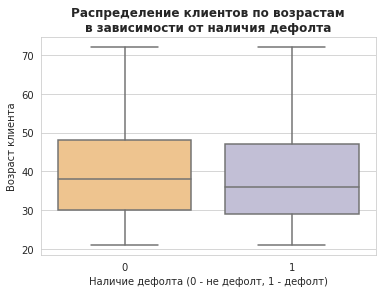

In [ ]:
sns.set_style('whitegrid')
ax = sns.boxplot(x="default_flg", y="client_age_cnt", data=df, palette='PuOr');
ax.set_title("Распределение клиентов по возрастам\nв зависимости от наличия дефолта", fontsize=12,  weight='bold')
ax.set_ylabel("Возраст клиента", fontsize=10)
ax.set_xlabel("Наличие дефолта (0 - не дефолт, 1 - дефолт)", fontsize=10)
fig = ax.get_figure()
fig.savefig('fig1.png')

Нет сильного различия между дефолтом и не дефолтом у клиентов разного возраста, средняя примерно одинакова

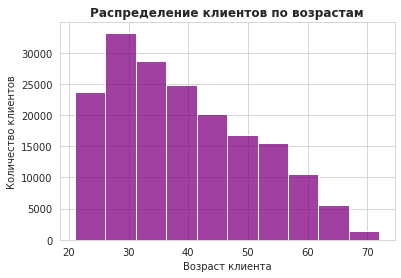

In [ ]:
ax = sns.histplot(data=df, x="client_age_cnt", bins=10, color='purple');
ax.set_title("Распределение клиентов по возрастам", fontsize=12,  weight='bold')
ax.set_ylabel("Количество клиентов", fontsize=10)
ax.set_xlabel("Возраст клиента", fontsize=10);

3. <b>client_score_bki_cnt</b> - скорринговый балл кредитной истории

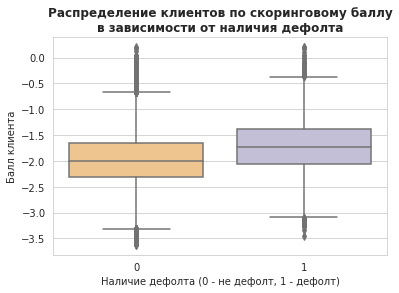

In [ ]:
ax = sns.boxplot(x="default_flg", y="client_score_bki_cnt", data=df, palette='PuOr');
ax.set_title("Распределение клиентов по скоринговому баллу\nв зависимости от наличия дефолта", fontsize=12, weight='bold')
ax.set_ylabel("Балл клиента", fontsize=10)
ax.set_xlabel("Наличие дефолта (0 - не дефолт, 1 - дефолт)", fontsize=10);
fig = ax.get_figure()
fig.savefig('fig3.png')

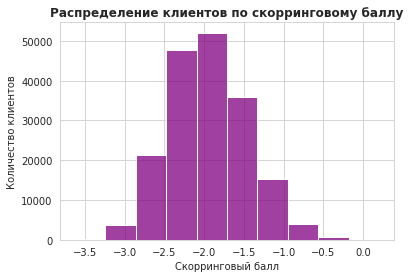

In [ ]:
ax = sns.histplot(data=df, x="client_score_bki_cnt", bins=10, color='purple');
ax.set_title("Распределение клиентов по скорринговому баллу", fontsize=12,  weight='bold')
ax.set_ylabel("Количество клиентов", fontsize=10)
ax.set_xlabel("Скорринговый балл", fontsize=10);
fig = ax.get_figure()
fig.savefig('fig4.png')

4. <b>out_request_cnt</b> - количество запросов в бюро

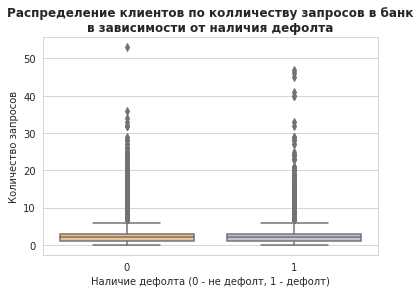

In [ ]:
ax = sns.boxplot(x="default_flg", y="out_request_cnt", data=df, palette='PuOr');
ax.set_title("Распределение клиентов по колличеству запросов в банк\nв зависимости от наличия дефолта", fontsize=12, weight='bold')
ax.set_ylabel("Количество запросов", fontsize=10)
ax.set_xlabel("Наличие дефолта (0 - не дефолт, 1 - дефолт)", fontsize=10);

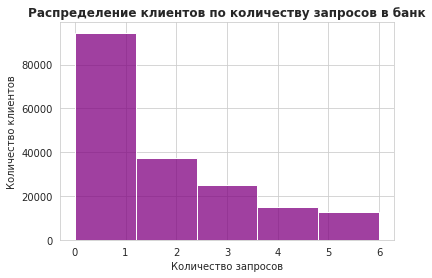

In [ ]:
ax = sns.histplot(data=df, x="out_request_cnt", bins=5, color='purple');
ax.set_title("Распределение клиентов по количеству запросов в банк", fontsize=12,  weight='bold')
ax.set_ylabel("Количество клиентов", fontsize=10)
ax.set_xlabel("Количество запросов", fontsize=10);

5. <b>client_income_cnt</b> - доход клиента

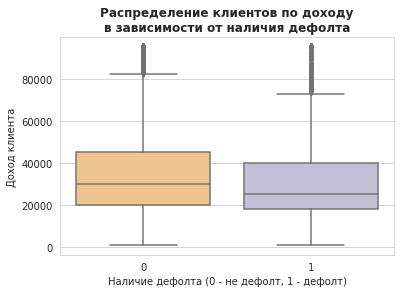

In [ ]:
ax =sns.boxplot(x="default_flg", y="client_income_cnt", data=df, palette='PuOr');
ax.set_title("Распределение клиентов по доходу\nв зависимости от наличия дефолта", fontsize=12, weight='bold')
ax.set_ylabel("Доход клиента", fontsize=10)
ax.set_xlabel("Наличие дефолта (0 - не дефолт, 1 - дефолт)", fontsize=10);

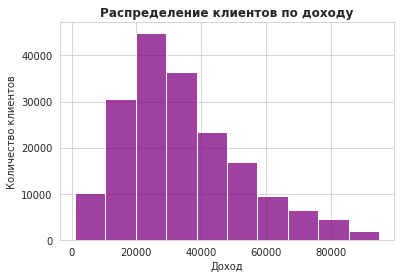

In [ ]:
ax = sns.histplot(data=df, x="client_income_cnt", bins=10, color='purple');
ax.set_title("Распределение клиентов по доходу", fontsize=12,  weight='bold')
ax.set_ylabel("Количество клиентов", fontsize=10)
ax.set_xlabel("Доход", fontsize=10);

## Перейдем к категориальным признакам
6. <b>client_SNA_cd</b> - связь заявителя с клиентами

In [ ]:
client_SNA = (df[df['default_flg']==1]['client_SNA_cd'].value_counts()) / (df['client_SNA_cd'].value_counts())
client_SNA

1    0.077957
4    0.169482
2    0.115186
3    0.132098
Name: client_SNA_cd, dtype: float64

In [ ]:
df['client_SNA_cd'].value_counts()

1    116770
4     29891
2     27373
3     10795
Name: client_SNA_cd, dtype: int64

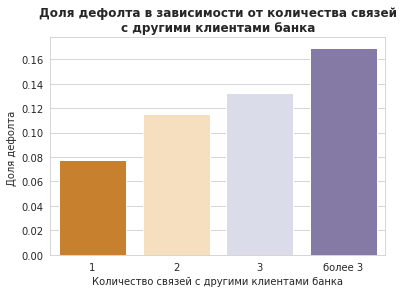

In [ ]:
ax = sns.barplot(x="client_SNA_cd", y="default_flg", data=df, palette='PuOr', ci=None);
ax.set_title("Доля дефолта в зависимости от количества связей\nс другими клиентами банка", fontsize=12, weight='bold')
ax.set_ylabel("Доля дефолта ", fontsize=10)
ax.set_xlabel("Количество связей с другими клиентами банка", fontsize=10);
ax.set_xticklabels(['1','2', '3', 'более 3']);ax = sns.barplot(x="client_SNA_cd", y="default_flg", data=df, palette='PuOr', ci=None);
ax.set_title("Доля дефолта в зависимости от количества связей\nс другими клиентами банка", fontsize=12, weight='bold')
ax.set_ylabel("Доля дефолта ", fontsize=10)
ax.set_xlabel("Количество связей с другими клиентами банка", fontsize=10);
ax.set_xticklabels(['1','2', '3', 'более 3']);

7. <b>client_education_cd</b> - уровень образования

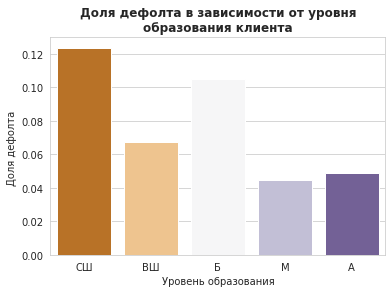

In [ ]:
ax = sns.barplot(x="client_education_cd", y="default_flg", data=df, palette='PuOr', ci=None);
ax.set_title("Доля дефолта в зависимости от уровня\nобразования клиента", fontsize=12, weight='bold')
ax.set_ylabel("Доля дефолта ", fontsize=10)
ax.set_xlabel("Уровень образования", fontsize=10);
ax.set_xticklabels(['СШ','ВШ', 'Б', 'М', 'А']);

8. <b>client_gender_cd</b> - пол клиента

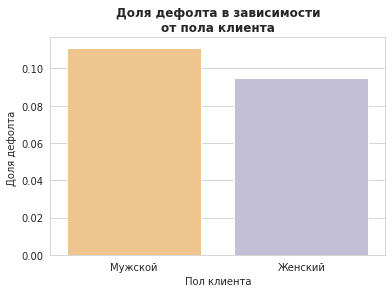

In [ ]:
ax = sns.barplot(x="client_gender_cd", y="default_flg", data=df, palette='PuOr', ci=None);
ax.set_title("Доля дефолта в зависимости\nот пола клиента", fontsize=12, weight='bold')
ax.set_ylabel("Доля дефолта ", fontsize=10)
ax.set_xlabel("Пол клиента", fontsize=10);
ax.set_xticklabels(['Мужской','Женский']);

9. <b>client_first_time_cd</b> - давность наличия информации о заявителе

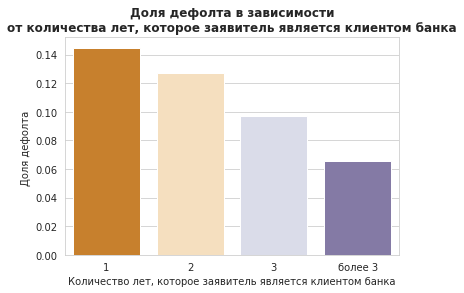

In [ ]:
ax = sns.barplot(x="client_first_time_cd", y="default_flg", data=df, palette='PuOr', ci=None);
ax.set_title("Доля дефолта в зависимости\nот количества лет, которое заявитель является клиентом банка", fontsize=12, weight='bold')
ax.set_ylabel("Доля дефолта ", fontsize=10)
ax.set_xlabel("Количество лет, которое заявитель является клиентом банка", fontsize=10);
ax.set_xticklabels(['1','2','3','более 3']);

10. <b>client_home_address_cd</b> - 

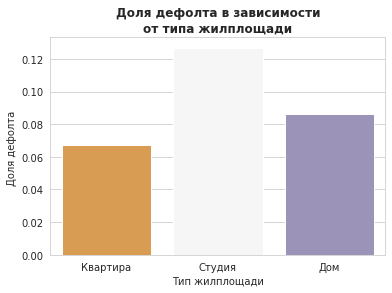

In [ ]:
ax = sns.barplot(x="client_home_address_cd", y="default_flg", data=df, palette='PuOr', ci=None);
ax.set_title("Доля дефолта в зависимости\nот типа жилплощади", fontsize=12, weight='bold')
ax.set_ylabel("Доля дефолта ", fontsize=10)
ax.set_xlabel("Тип жилплощади", fontsize=10);
ax.set_xticklabels(['Квартира','Студия','Дом']);

11. client_work_address_cd

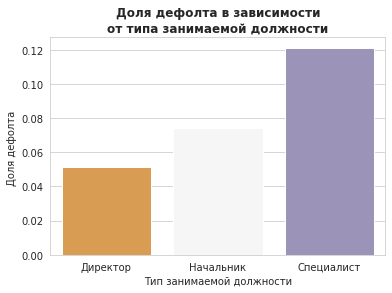

In [ ]:
ax = sns.barplot(x="client_work_address_cd", y="default_flg", data=df, palette='PuOr', ci=None);
ax.set_title("Доля дефолта в зависимости\nот типа занимаемой должности", fontsize=12, weight='bold')
ax.set_ylabel("Доля дефолта ", fontsize=10)
ax.set_xlabel("Тип занимаемой должности", fontsize=10);
ax.set_xticklabels(['Директор','Начальник','Специалист']);

12. region_rating_cd

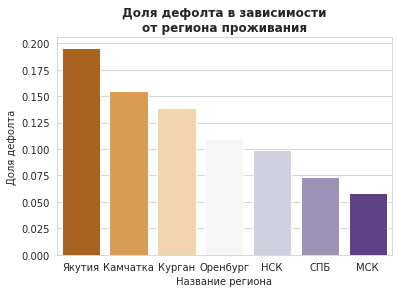

In [ ]:
ax = sns.barplot(x="region_rating_cd", y="default_flg", data=df, palette='PuOr', ci=None);
ax.set_title("Доля дефолта в зависимости\nот региона проживания", fontsize=12, weight='bold')
ax.set_ylabel("Доля дефолта", fontsize=10)
ax.set_xlabel("Название региона", fontsize=10);
ax.set_xticklabels(['Якутия','Камчатка','Курган','Оренбург','НСК','СПБ','МСК']);

## Перейдем к бинарным признакам
13. car_own_flg - наличие автомобиля у заявителя

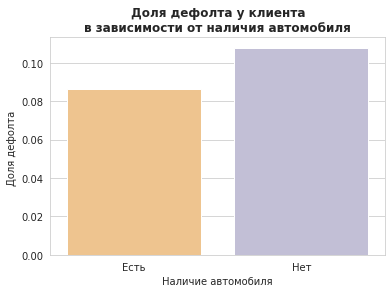

In [ ]:
ax = sns.barplot(x="car_own_flg", y="default_flg", data=df, palette='PuOr', ci=None);
ax.set_title("Доля дефолта у клиента\nв зависимости от наличия автомобиля", fontsize=12, weight='bold')
ax.set_ylabel("Доля дефолта ", fontsize=10)
ax.set_xlabel("Наличие автомобиля", fontsize=10);
ax.set_xticklabels(['Есть','Нет']);

14. car_type_flg - наличие иномарки

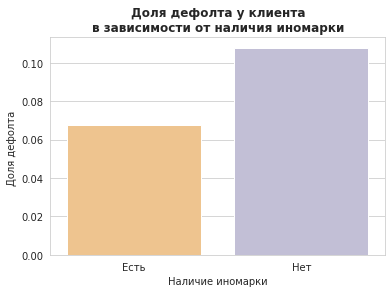

In [ ]:
ax = sns.barplot(x="car_type_flg", y="default_flg", data=df, palette='PuOr', ci=None);
ax.set_title("Доля дефолта у клиента\nв зависимости от наличия иномарки", fontsize=12, weight='bold')
ax.set_ylabel("Доля дефолта ", fontsize=10)
ax.set_xlabel("Наличие иномарки", fontsize=10);
ax.set_xticklabels(['Есть','Нет']);

15. good_work_flg - наличие "хорошей" работы у клиента

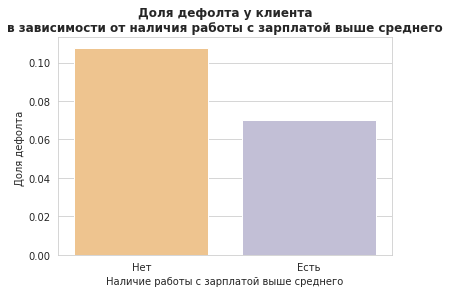

In [ ]:
ax = sns.barplot(x="good_work_flg", y="default_flg", data=df, palette='PuOr', ci=None);
ax.set_title("Доля дефолта у клиента\nв зависимости от наличия работы с зарплатой выше среднего", fontsize=12, weight='bold')
ax.set_ylabel("Доля дефолта ", fontsize=10)
ax.set_xlabel("Наличие работы с зарплатой выше среднего", fontsize=10);
ax.set_xticklabels(['Нет','Есть']);

16. inter_passport_flg

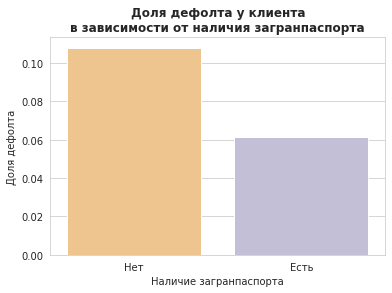

In [ ]:
ax = sns.barplot(x="inter_passport_flg", y="default_flg", data=df, palette='PuOr', ci=None);
ax.set_title("Доля дефолта у клиента\nв зависимости от наличия загранпаспорта", fontsize=12, weight='bold')
ax.set_ylabel("Доля дефолта", fontsize=10)
ax.set_xlabel("Наличие загранпаспорта", fontsize=10);
ax.set_xticklabels(['Нет','Есть']);

Посмотрим есть ли корреляция между числовыми признаками

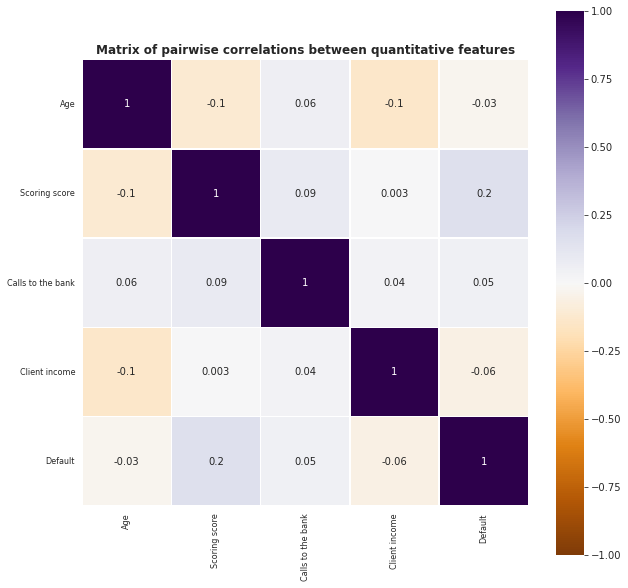

In [ ]:
corr_data = df[['client_age_cnt',
                'client_score_bki_cnt',
                'out_request_cnt',
                'client_income_cnt',
                'default_flg']]
plt.figure(figsize=(10, 10)) # зададим размер картинки
corr_data = corr_data.corr() # рассчитаем корреляцию
ax = sns.heatmap(corr_data, cmap=plt.cm.PuOr, vmin=-1, vmax=1, center=0, annot = True, fmt ='.1g', square=True,
                 annot_kws={'size':10}, linewidths=.5) # нарисуем график
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 8)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 8)
ax.set_title("Matrix of pairwise correlations between quantitative features", fontsize=12, weight='bold');
ax.set_xticklabels(['Age', 'Scoring score', 'Calls to the bank', 'Client income', 'Default']);
ax.set_yticklabels(['Age', 'Scoring score', 'Calls to the bank', 'Client income', 'Default']);

Сильно скорелированных между собой признаков нет, все берем в работу

Посмотрим есть ли корреляция между категориальными признаками

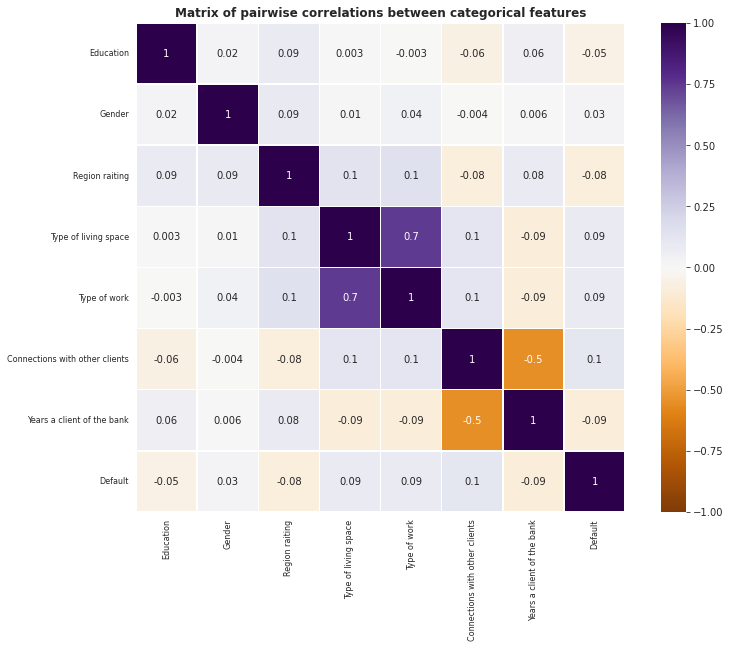

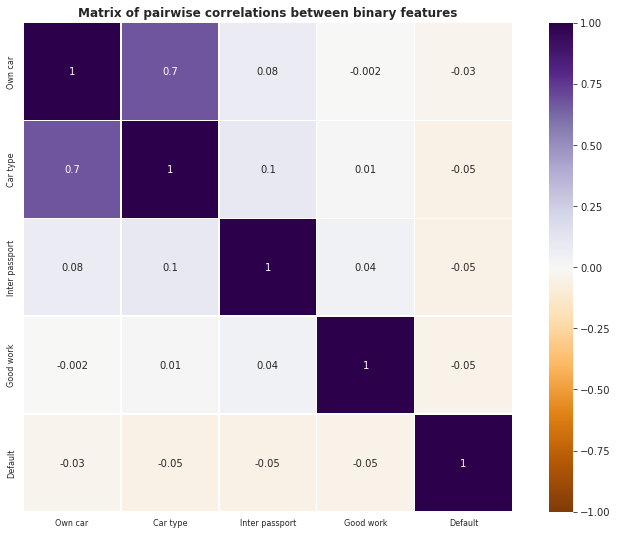

In [ ]:
corr_data = df[['car_own_num',
                'car_type_num',
                'inter_passport_num',
                'good_work_flg',
                'default_flg']]
plt.figure(figsize=(13, 9)) # зададим размер картинки
corr_data = corr_data.corr(method="spearman") # рассчитаем корреляцию
ax = sns.heatmap(corr_data, cmap=plt.cm.PuOr, vmin=-1, vmax=1, center=0, annot = True, fmt ='.1g', square=True,
                 annot_kws={'size':10}, linewidths=.5) # нарисуем график
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 8)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 8)
ax.set_title("Matrix of pairwise correlations between binary features", fontsize=12, weight='bold');
ax.set_xticklabels(['Own car', 'Car type', 'Inter passport', 'Good work', 'Default']);
ax.set_yticklabels(['Own car', 'Car type', 'Inter passport', 'Good work', 'Default']);

In [ ]:
df.columns.tolist()

['default_flg',
 'sample_cd',
 'client_education_cd',
 'client_gender_cd',
 'client_age_cnt',
 'car_own_flg',
 'car_type_flg',
 'good_work_flg',
 'client_score_bki_cnt',
 'out_request_cnt',
 'region_rating_cd',
 'client_home_address_cd',
 'client_work_address_cd',
 'client_income_cnt',
 'client_SNA_cd',
 'client_first_time_cd',
 'inter_passport_flg',
 'client_education_num',
 'client_gender_num',
 'car_own_num',
 'car_type_num',
 'inter_passport_num']

Сильно скорелированы между собой признаки

    'client_home_address_cd', 'client_work_address_cd'
    'client_SNA_cd', 'client_first_time_cd'

# Преобразуем непрерывные переменные в категориальные

1. <b>client_age_cnt</b>

In [ ]:
df['client_age_bins'] = pd.qcut(df['client_age_cnt'], 5,
                               labels=['lt_28', '28_to_34', '34_to_41', '41_to_51', 'gt_51'])

2. <b>client_score_bki_cnt</b>

In [ ]:
df['client_score_bki_bins'] = pd.qcut(df['client_score_bki_cnt'], 5,
                                     labels=['less_-2.387', '-2.387_to_-2.116', '-2.116_to_-1.865',
                                             '-1.865_to_-1.566', 'more_-1.566'])

3. <b>client_income_cnt</b>

In [ ]:
df['client_income_bins'] = pd.qcut(df['client_income_cnt'], 4,
                                   labels=['less_20000', '20000_to_30000', '30000_to_45000', 'more_45000'])

In [ ]:
df_1 = df.drop(['client_age_cnt', 'client_score_bki_cnt', 'client_income_cnt'], axis=1)
df_1.head(2)

default_flg sample_cd client_education_cd client_gender_cd car_own_flg  \
0            0         1                 SCH                M           Y   
1            0         1                 GRD                F           N   

  car_type_flg  good_work_flg  out_request_cnt  region_rating_cd  \
0            Y              0                0                40   
1            N              0                2                60   

   client_home_address_cd  client_work_address_cd  client_SNA_cd  \
0                       2                       3              1   
1                       2                       3              2   

   client_first_time_cd inter_passport_flg  client_education_num  \
0                     4                  N                     1   
1                     1                  N                     2   

   client_gender_num  car_own_num  car_type_num  inter_passport_num  \
0                  2            1             1                   0   
1                  1            0             0                   0   

  client_age_bins client_score_bki_bins client_income_bins  
0           lt_28      -2.116_to_-1.865     30000_to_45000  
1           lt_28           more_-1.566         more_45000

In [ ]:
df['client_income_bins'].value_counts()

less_20000        55214
20000_to_30000    49106
30000_to_45000    40360
more_45000        40149
Name: client_income_bins, dtype: int64

In [ ]:
client_age_dictionary = {'lt_28': 1, '28_to_34' : 2, '34_to_41' : 3, '41_to_51' : 4, 'gt_51' : 5}
df['client_age_num'] = df['client_age_bins'].apply(lambda x: client_age_dictionary[x])
df_1['client_age_num'] = df['client_age_num']

In [ ]:
client_score_bki_dictionary = {'more_-1.566': 1, '-1.865_to_-1.566' : 2, '-2.116_to_-1.865' : 3, '-2.387_to_-2.116' : 4, 'less_-2.387' : 5}
df['client_score_bki_num'] = df['client_score_bki_bins'].apply(lambda x: client_score_bki_dictionary[x])
df_1['client_score_bki_num'] = df['client_score_bki_num']

In [ ]:
client_income_dictionary = {'less_20000': 1, '20000_to_30000' : 2, '30000_to_45000' : 3, 'more_45000' : 4}
df['client_income_num'] = df['client_income_bins'].apply(lambda x: client_income_dictionary[x])
df_1['client_income_num'] = df['client_income_num']
df['client_income_num'].value_counts()

1    55214
2    49106
3    40360
4    40149
Name: client_income_num, dtype: int64

# Отбор признаков

## 1 способ

### Расчет IV и WoE

In [ ]:
def calculate_woe_iv(dataset, feature, target):
    lst = []
    for i in range(dataset[feature].nunique()):
        val = list(dataset[feature].unique())[i]
        lst.append({
            'Value': val,
            'All': dataset[dataset[feature] == val].count()[feature],
            'Good': dataset[(dataset[feature] == val) & (dataset[target] == 0)].count()[feature],
            'Bad': dataset[(dataset[feature] == val) & (dataset[target] == 1)].count()[feature]
        })
        
    dset = pd.DataFrame(lst)
    dset['Distr_Good'] = dset['Good'] / dset['Good'].sum()
    dset['Distr_Bad'] = dset['Bad'] / dset['Bad'].sum()
    dset['WoE'] = np.log(dset['Distr_Good'] / dset['Distr_Bad'])
    dset = dset.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * dset['WoE']
    iv = dset['IV'].sum()
    
    dset = dset.sort_values(by='WoE')
    
    return dset, iv

In [ ]:
cols = df_1[['default_flg',
 'client_education_cd',
 'client_gender_cd',
 'car_own_flg',
 'car_type_flg',
 'good_work_flg',
 'out_request_cnt',
 'region_rating_cd',
 'client_home_address_cd',
 'client_work_address_cd',
 'client_SNA_cd',
 'client_first_time_cd',
 'inter_passport_flg',
 'client_education_num',
 'client_gender_num',
 'car_own_num',
 'car_type_num',
 'inter_passport_num',
 'client_age_bins',
 'client_score_bki_bins',
 'client_income_bins',
 'client_age_num',
 'client_score_bki_num',
 'client_income_num']]
cols.head()

default_flg client_education_cd client_gender_cd car_own_flg car_type_flg  \
0            0                 SCH                M           Y            Y   
1            0                 GRD                F           N            N   
2            0                 SCH                M           N            N   
3            0                 GRD                F           N            N   
4            0                 UGR                F           N            N   

   good_work_flg  out_request_cnt  region_rating_cd  client_home_address_cd  \
0              0                0                40                       2   
1              0                2                60                       2   
2              1                0                40                       1   
3              1                2                20                       2   
4              0                1                50                       2   

   client_work_address_cd  client_SNA_cd  client_first_time_cd  \
0                       3              1                     4   
1                       3              2                     1   
2                       2              4                     3   
3                       3              1                     3   
4                       3              1                     2   

  inter_passport_flg  client_education_num  client_gender_num  car_own_num  \
0                  N                     1                  2            1   
1                  N                     2                  1            0   
2                  N                     1                  2            0   
3                  N                     2                  1            0   
4                  N                     3                  1            0   

   car_type_num  inter_passport_num client_age_bins client_score_bki_bins  \
0             1                   0           lt_28      -2.116_to_-1.865   
1             0                   0           lt_28           more_-1.566   
2             0                   0        34_to_41      -1.865_to_-1.566   
3             0                   0        34_to_41           less_-2.387   
4             0                   0           lt_28      -2.116_to_-1.865   

  client_income_bins client_age_num client_score_bki_num client_income_num  
0     30000_to_45000              1                    3                 3  
1         more_45000              1                    1                 4  
2         less_20000              3                    2                 1  
3         more_45000              3                    5                 4  
4     20000_to_30000              1                    3                 2

In [ ]:
for col in cols:
    if col == 'default_flg': continue
    else:
        print('WoE and IV for column: {}'.format(col))
        dataf, iv = calculate_woe_iv(cols, col, 'default_flg')
        print(dataf)
        print('IV score: {:.2f}'.format(iv))
        print('\n')

WoE and IV for column: client_education_cd
  Value    All   Good    Bad  Distr_Good  Distr_Bad       WoE        IV
0   SCH  95388  83594  11794    0.503333   0.629080 -0.223008  0.028043
2   UGR  26316  23554   2762    0.141822   0.147322 -0.038048  0.000209
1   GRD  60052  55999   4053    0.337179   0.216183  0.444488  0.053781
4   ACD    389    370     19    0.002228   0.001013  0.787675  0.000957
3   PGR   2684   2564    120    0.015438   0.006401  0.880444  0.007957
IV score: 0.09


WoE and IV for column: client_gender_cd
  Value     All   Good    Bad  Distr_Good  Distr_Bad       WoE        IV
0     M   76300  67821   8479    0.408361   0.452262 -0.102109  0.004483
1     F  108529  98260  10269    0.591639   0.547738  0.077099  0.003385
IV score: 0.01


WoE and IV for column: car_own_flg
  Value     All    Good    Bad  Distr_Good  Distr_Bad       WoE        IV
1     N  129753  115756  13997    0.696985   0.746586 -0.068747  0.003410
0     Y   55076   50325   4751    0.303015   0.25

Таблица для интерпретации IV:
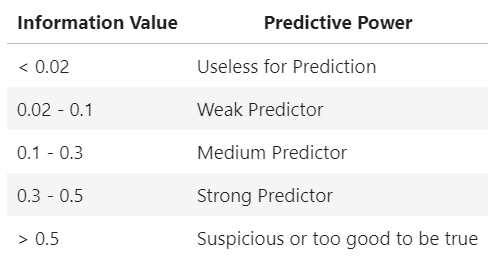

Отберем признаки, для которых IV больше чем 0.1:
- <b>client_score_bki_bins</b> (0.27)
- <b>client_home_address_cd</b> (0.11)
- <b>client_work_address_cd</b> (0.10)
- <b>client_SNA_cd</b> (0.13)

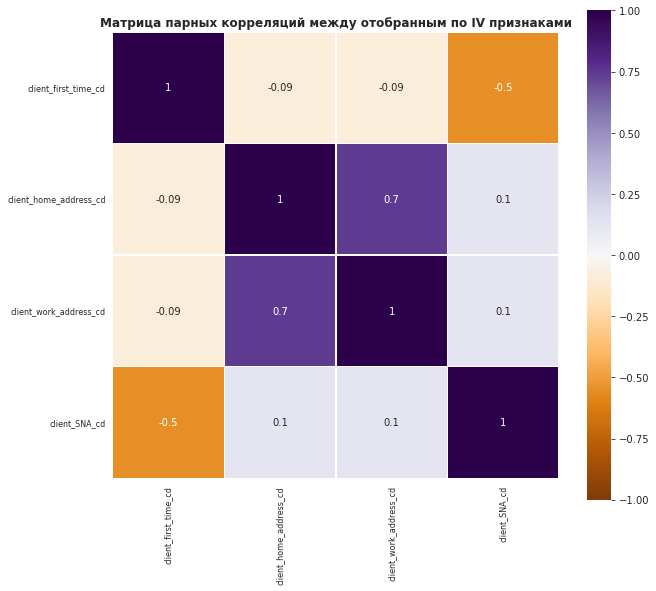

In [ ]:
corr_data = df_1[['client_score_bki_num',
                  'client_first_time_cd',
                  'client_home_address_cd',
                  'client_work_address_cd',
                  'client_SNA_cd']]
plt.figure(figsize=(10, 9)) # зададим размер картинки
corr_data = corr_data.corr() # рассчитаем корреляцию
ax = sns.heatmap(corr_data, cmap=plt.cm.PuOr, vmin=-1, vmax=1, center=0, annot = True, fmt ='.1g', square=True,
                 annot_kws={'size':10}, linewidths=.5) # нарисуем график
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 8)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 8)
ax.set_title("Матрица парных корреляций между отобранным по IV признаками", fontsize=12, weight='bold');

In [ ]:
df_1.columns.tolist()

['default_flg',
 'sample_cd',
 'client_education_cd',
 'client_gender_cd',
 'car_own_flg',
 'car_type_flg',
 'good_work_flg',
 'out_request_cnt',
 'region_rating_cd',
 'client_home_address_cd',
 'client_work_address_cd',
 'client_SNA_cd',
 'client_first_time_cd',
 'inter_passport_flg',
 'client_education_num',
 'client_gender_num',
 'car_own_num',
 'car_type_num',
 'inter_passport_num',
 'client_age_bins',
 'client_score_bki_bins',
 'client_income_bins',
 'client_age_num',
 'client_score_bki_num',
 'client_income_num']

### Создание фиктивных переменных

In [ ]:
education_dummies = pd.get_dummies(df_1['client_education_cd'], drop_first=True)

age_dummies = pd.get_dummies(df_1['client_age_bins'], drop_first=True)

client_score_bki_dummies = pd.get_dummies(df_1['client_score_bki_bins'], drop_first=True)

income_dummies = pd.get_dummies(df_1['client_income_bins'], drop_first=True)

home_address_dummies = pd.get_dummies(df_1['client_home_address_cd'], drop_first=True, prefix='home_address')

work_address_dummies = pd.get_dummies(df_1['client_work_address_cd'], drop_first=True, prefix='work_address')

client_SNA_dummies = pd.get_dummies(df_1['client_SNA_cd'], drop_first=True, prefix='client_SNA')

gender_dummies = pd.get_dummies(df_1['client_gender_cd'], drop_first=True, prefix='gender')

car_own_dummies = pd.get_dummies(df_1['car_own_flg'], drop_first=True, prefix='car_own')

car_type_dummies = pd.get_dummies(df_1['car_type_flg'], drop_first=True, prefix='car_type')

inter_passport_dummies = pd.get_dummies(df_1['inter_passport_flg'], drop_first=True, prefix='inter_passport')

first_time_dummies = pd.get_dummies(df_1['client_first_time_cd'], drop_first=True, prefix='first_time')

out_request_dummies	= pd.get_dummies(df_1['out_request_cnt'], drop_first=True, prefix='out_request')

region_rating_dummies = pd.get_dummies(df_1['region_rating_cd'], drop_first=True, prefix='region_rating')

df_features_1 = pd.concat([home_address_dummies, work_address_dummies, client_score_bki_dummies, client_SNA_dummies,
                           df[['sample_cd', 'default_flg']]], axis=1)
df_features_1.head(2)

home_address_2  home_address_3  work_address_2  work_address_3  \
0               1               0               0               1   
1               1               0               0               1   

   -2.387_to_-2.116  -2.116_to_-1.865  -1.865_to_-1.566  more_-1.566  \
0                 0                 1                 0            0   
1                 0                 0                 0            1   

   client_SNA_2  client_SNA_3  client_SNA_4 sample_cd  default_flg  
0             0             0             0         1            0  
1             1             0             0         1            0

In [ ]:
df_features_1.columns.tolist()

['home_address_2',
 'home_address_3',
 'work_address_2',
 'work_address_3',
 '-2.387_to_-2.116',
 '-2.116_to_-1.865',
 '-1.865_to_-1.566',
 'more_-1.566',
 'client_SNA_2',
 'client_SNA_3',
 'client_SNA_4',
 'sample_cd',
 'default_flg']

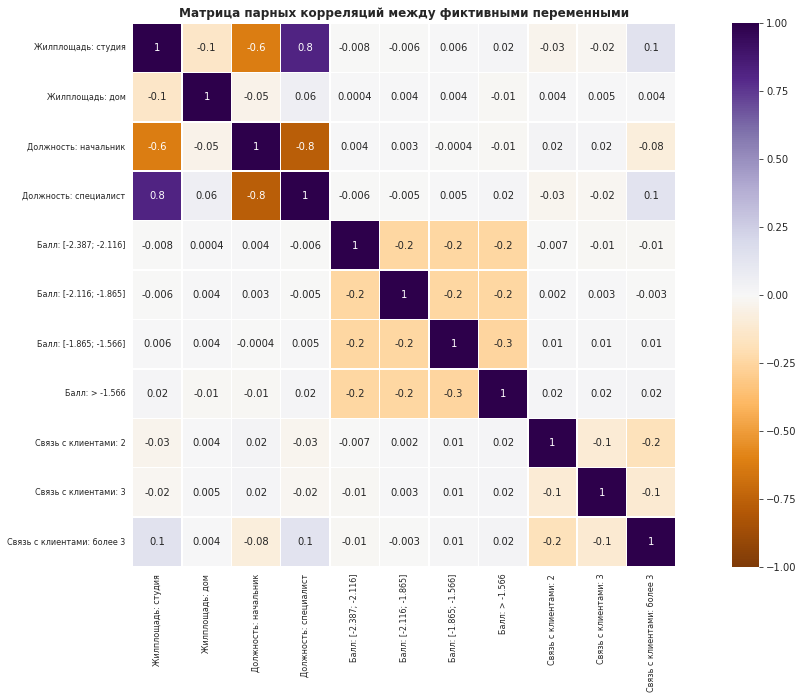

In [ ]:
corr_data = df_features_1[['home_address_2',
 'home_address_3',
 'work_address_2',
 'work_address_3',
 '-2.387_to_-2.116',
 '-2.116_to_-1.865',
 '-1.865_to_-1.566',
 'more_-1.566',
 'client_SNA_2',
 'client_SNA_3',
 'client_SNA_4']]
plt.figure(figsize=(20, 10)) # зададим размер картинки
corr_data = corr_data.corr() # рассчитаем корреляцию
ax = sns.heatmap(corr_data, cmap=plt.cm.PuOr, vmin=-1, vmax=1, center=0, annot = True, fmt ='.1g', square=True,
                 annot_kws={'size':10}, linewidths=.5) # нарисуем график
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 8)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 8)
ax.set_title("Матрица парных корреляций между фиктивными переменными", fontsize=12, weight='bold');
ax.set_xticklabels(['Жилплощадь: студия', 'Жилплощадь: дом', 'Должность: начальник', 'Должность: специалист',
                    'Балл: [-2.387; -2.116]', 'Балл: [-2.116; -1.865]', 'Балл: [-1.865; -1.566]', 'Балл: > -1.566',
                    'Связь с клиентами: 2','Связь с клиентами: 3', 'Связь с клиентами: более 3']);
ax.set_yticklabels(['Жилплощадь: студия', 'Жилплощадь: дом', 'Должность: начальник', 'Должность: специалист',
                    'Балл: [-2.387; -2.116]', 'Балл: [-2.116; -1.865]', 'Балл: [-1.865; -1.566]', 'Балл: > -1.566',
                    'Связь с клиентами: 2','Связь с клиентами: 3', 'Связь с клиентами: более 3']);

Между собой скореллированы:

1.   **home_address_2** и **work_address_3**
2.   **work_address_2** и **work_address_3**

Из двух нужно оставить тот, у которого больше вес доказательства.

1.   home_address_2
2.   work_address_2



In [ ]:
df_features_1 = df_features_1.drop('work_address_3', 1)

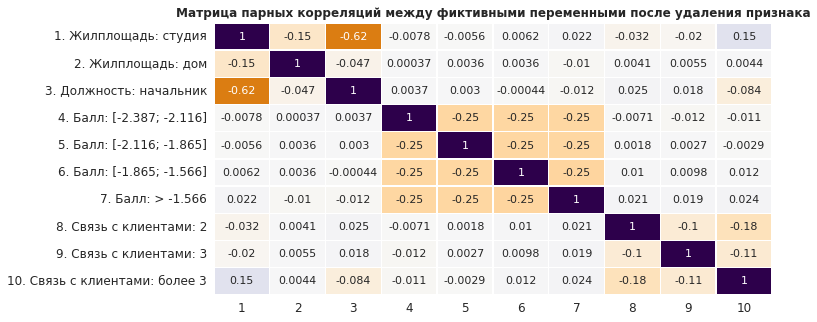

In [ ]:
corr_data = df_features_1[['home_address_2',
 'home_address_3',
 'work_address_2',
 '-2.387_to_-2.116',
 '-2.116_to_-1.865',
 '-1.865_to_-1.566',
 'more_-1.566',
 'client_SNA_2',
 'client_SNA_3',
 'client_SNA_4']]
plt.figure(figsize=(10, 5)) # зададим размер картинки
corr_data = corr_data.corr() # рассчитаем корреляцию
ax = sns.heatmap(corr_data, cmap=plt.cm.PuOr, vmin=-1, vmax=1, center=0, annot = True,
                 annot_kws={'size':11}, linewidths=.5, cbar=False) # нарисуем график
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 12)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 12, rotation=0)
ax.set_title("Матрица парных корреляций между фиктивными переменными после удаления признака", fontsize=12, weight='bold');
ax.set_xticklabels(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']);
ax.set_yticklabels(['1. Жилплощадь: студия', '2. Жилплощадь: дом', '3. Должность: начальник',
                    '4. Балл: [-2.387; -2.116]', '5. Балл: [-2.116; -1.865]', '6. Балл: [-1.865; -1.566]', '7. Балл: > -1.566',
                    '8. Связь с клиентами: 2','9. Связь с клиентами: 3', '10. Связь с клиентами: более 3']);

### Применение метода RFE

In [ ]:
X = df_features_1.drop(['sample_cd','default_flg'], axis=1) # удаляем столбец default_flag
y = df_features_1['default_flg']

In [ ]:
n_features = 10

In [ ]:
log_reg = LogisticRegression()
rfe = RFE(log_reg, n_features_to_select=n_features)
rfe = rfe.fit(X, y)

In [ ]:
print(rfe.n_features_)
print(rfe.support_)
print(rfe.ranking_)

In [ ]:
final_lst = X.loc[:, rfe.support_].columns.tolist()
final_lst

## 2 способ

### Метод **Feature_selector**

In [ ]:
df_2 = pd.concat([education_dummies, home_address_dummies, age_dummies, client_score_bki_dummies, income_dummies, 
              work_address_dummies, client_SNA_dummies, gender_dummies, car_own_dummies, car_type_dummies,
              inter_passport_dummies, first_time_dummies, out_request_dummies, region_rating_dummies,
              df[['default_flg', 'sample_cd', 'good_work_flg']]], axis=1)
X = df_2.drop(['default_flg', 'sample_cd'], axis=1)
y = df['default_flg']

In [ ]:
fs = FeatureSelector(data = X, labels = y)

In [ ]:
fs.identify_missing(missing_threshold = 0.6)

In [ ]:
fs.missing_stats.head()

In [ ]:
fs.plot_missing()

In [ ]:
fs.identify_collinear(correlation_threshold = 0.75)
fs.plot_collinear(plot_all=True)

In [ ]:
collinear_features = fs.ops['collinear']
collinear_features
fs.record_collinear.head()

In [ ]:
fs.identify_zero_importance(task = 'classification', eval_metric = 'AUC', n_iterations = 10, 
                             early_stopping = True)

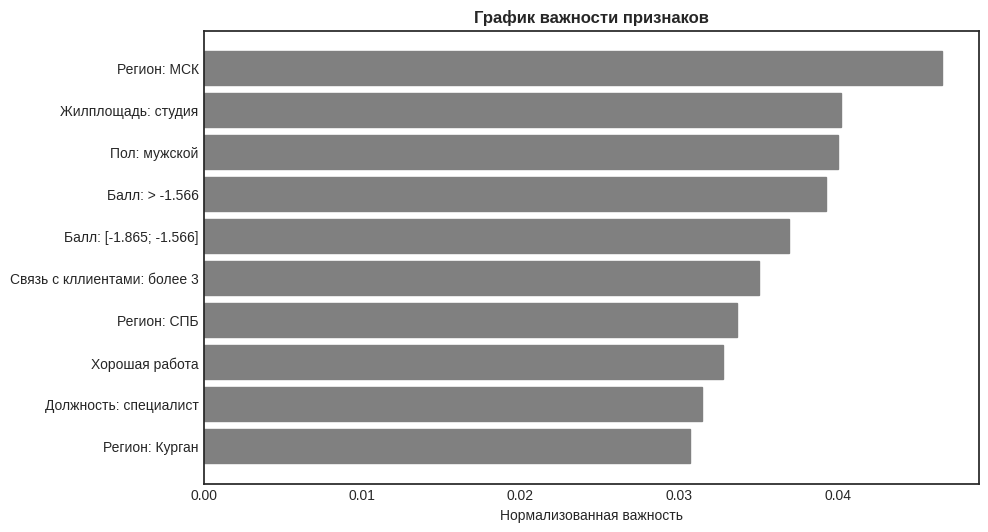

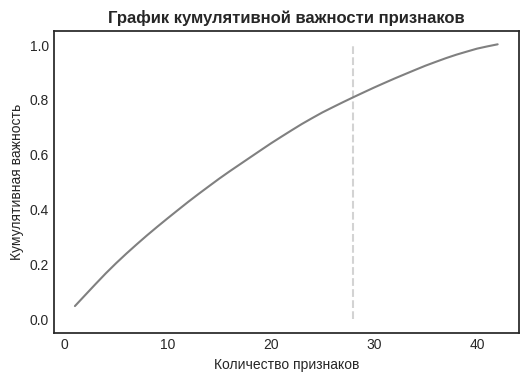

28 features required for 0.80 of cumulative importance


In [ ]:
fs.plot_feature_importances(threshold = 0.8, plot_n = 10)

In [ ]:
fs.identify_low_importance(cumulative_importance = 0.74)

24 features required for cumulative importance of 0.74 after one hot encoding.
18 features do not contribute to cumulative importance of 0.74.



In [ ]:
fs.feature_importances

feature  importance  normalized_importance  cumulative_importance
0   region_rating_80       214.2               0.046575               0.046575
1           gender_M       184.9               0.040204               0.086780
2     home_address_2       184.0               0.040009               0.126788
3        more_-1.566       180.5               0.039248               0.166036
4   -1.865_to_-1.566       169.9               0.036943               0.202979
5       client_SNA_4       161.3               0.035073               0.238052
6   region_rating_70       154.7               0.033638               0.271689
7   region_rating_40       150.6               0.032746               0.304436
8      good_work_flg       144.6               0.031442               0.335877
9     work_address_3       141.1               0.030681               0.366558
10      first_time_4       138.5               0.030115               0.396673
11               GRD       137.3               0.029854               0.426528
12      first_time_3       132.0               0.028702               0.455229
13             gt_51       128.4               0.027919               0.483149
14  -2.116_to_-1.865       127.5               0.027723               0.510872
15     out_request_3       121.3               0.026375               0.537247
16      client_SNA_2       117.3               0.025506               0.562753
17     out_request_5       117.2               0.025484               0.588237
18        car_type_Y       117.0               0.025440               0.613677
19               SCH       116.2               0.025266               0.638943
20        more_45000       110.1               0.023940               0.662883
21          41_to_51       108.4               0.023570               0.686454
22     out_request_4       106.3               0.023114               0.709567
23      client_SNA_3        98.6               0.021439               0.731007
24      first_time_2        95.9               0.020852               0.751859
25     out_request_6        86.7               0.018852               0.770711
26    work_address_2        85.2               0.018526               0.789237
27     out_request_2        82.7               0.017982               0.807219
28         car_own_Y        81.0               0.017613               0.824831
29  region_rating_50        80.2               0.017439               0.842270
30  inter_passport_Y        76.7               0.016678               0.858948
31  -2.387_to_-2.116        75.7               0.016460               0.875408
32    30000_to_45000        72.4               0.015743               0.891150
33          34_to_41        72.0               0.015656               0.906806
34  region_rating_60        70.7               0.015373               0.922179
35    20000_to_30000        64.2               0.013960               0.936138
36     out_request_1        62.8               0.013655               0.949793
37               PGR        57.5               0.012503               0.962296
38          28_to_34        51.1               0.011111               0.973407
39  region_rating_30        49.8               0.010828               0.984236
40    home_address_3        37.7               0.008197               0.992433
41               UGR        34.8               0.007567               1.000000

In [ ]:
total_remove_all = fs.remove(methods = 'all', keep_one_hot=False)
total_remove_all

['missing', 'collinear', 'zero_importance', 'low_importance'] methods have been run

Removed 19 features including one-hot features.


GRD  SCH  home_address_2  41_to_51  gt_51  -2.116_to_-1.865  \
0         0    1               1         0      0                 1   
1         1    0               1         0      0                 0   
2         0    1               0         0      0                 0   
3         1    0               1         0      0                 0   
4         0    0               1         0      0                 1   
...     ...  ...             ...       ...    ...               ...   
205288    0    1               0         0      0                 0   
205290    0    0               0         0      0                 1   
205291    0    1               0         1      0                 1   
205293    0    0               0         0      0                 0   
205294    1    0               0         1      0                 0   

        -1.865_to_-1.566  more_-1.566  more_45000  client_SNA_2  client_SNA_3  \
0                      0            0           0             0             0   
1                      0            1           1             1             0   
2                      1            0           0             0             0   
3                      0            0           1             0             0   
4                      0            0           0             0             0   
...                  ...          ...         ...           ...           ...   
205288                 1            0           1             0             0   
205290                 0            0           1             0             0   
205291                 0            0           0             0             1   
205293                 0            1           0             0             0   
205294                 0            1           0             0             0   

        client_SNA_4  gender_M  car_type_Y  first_time_3  first_time_4  \
0                  0         1           1             0             1   
1                  0         0           0             0             0   
2                  1         1           0             1             0   
3                  0         0           0             1             0   
4                  0         0           0             0             0   
...              ...       ...         ...           ...           ...   
205288             0         0           0             0             1   
205290             0         0           0             1             0   
205291             0         0           0             0             0   
205293             0         1           1             1             0   
205294             0         0           0             0             1   

        out_request_3  out_request_4  out_request_5  region_rating_40  \
0                   0              0              0                 1   
1                   0              0              0                 0   
2                   0              0              0                 1   
3                   0              0              0                 0   
4                   0              0              0                 0   
...               ...            ...            ...               ...   
205288              0              0              0                 0   
205290              0              0              0                 0   
205291              1              0              0                 0   
205293              0              0              0                 0   
205294              0              1              0                 0   

        region_rating_70  region_rating_80  good_work_flg  
0                      0                 0              0  
1                      0                 0              0  
2                      0                 0              1  
3                      0                 0              1  
4                      0                 0              0  
...                  ...               ...            ..

In [ ]:
df_features_20 = pd.concat([total_remove_all, df[['default_flg', 'sample_cd']]], axis=1)

### Метод RFE

In [ ]:
X = df_features_20.drop(['default_flg', 'sample_cd'], axis=1)
y = df_features_20['default_flg']

In [ ]:
n_features = 10

In [ ]:
log_reg = LogisticRegression()
rfe = RFE(log_reg, n_features_to_select=n_features)
rfe = rfe.fit(X, y)

In [ ]:
print(rfe.n_features_)
print(rfe.support_)
print(rfe.ranking_)

In [ ]:
final_lst = X.loc[:, rfe.support_].columns.tolist()
final_lst

In [ ]:
df_features_20

In [ ]:
df_features_2 = df_features_20[['GRD',
 'home_address_2',
 '-2.116_to_-1.865',
 '-1.865_to_-1.566',
 'more_-1.566',
 'client_SNA_4',
 'car_type_Y',
 'first_time_4',
 'region_rating_70',
 'region_rating_80', 'default_flg', 'sample_cd']]

# Построение модели

## 1.1 Логистическая регрессия

In [ ]:
train_data = df_features_1.query('sample_cd == 1').drop(['sample_cd'], axis=1)
test_data = df_features_1.query('sample_cd == 0').drop(['sample_cd'], axis=1)

y_1 = train_data['default_flg']
X_1 = train_data.drop(['default_flg'], axis=1)

In [ ]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=0.2, random_state=42)
print('Размер тренировочной выборки')
print(y_train.value_counts())
print()
print('Размер тестовой выборки')
print(y_test.value_counts())

Размер тренировочной выборки
0    115652
1     15051
Name: default_flg, dtype: int64

Размер тестовой выборки
0    28979
1     3697
Name: default_flg, dtype: int64


In [ ]:
# Расчитаем соотношение доли дефолтов в процентах, для этого поделим кол-во дефолтов на общее кол-во наблюдений:
w_train = (y_train.value_counts()[1] / y_train.value_counts().sum()) * 100
# round() позволяет округлить результат. Указывая вторым аргументом "2" получим округление до 2го значка после запятой
print('Доля дефолтов в тренировочной выборке:', round(w_train, 2), '%')

# Расчитаем соотношение доли дефолтов в процентах, для этого поделим кол-во дефолтов на общее кол-во наблюдений:
w_test = (y_test.value_counts()[1] / y_test.value_counts().sum()) * 100
# round() позволяет округлить результат. Указывая вторым аргументом "2" получим округление до 2го значка после запятой
print('Доля дефолтов в тестовой выборке:', round(w_test, 2), '%')

# Расчитаем соотношение доли дефолтов в полной выборке:
w = df[df.default_flg == 1]['default_flg'].sum() / df.shape[0] * 100
print('Доля дефолтов в полной выборке:', round(w, 2), '%')

Доля дефолтов в тренировочной выборке: 11.52 %
Доля дефолтов в тестовой выборке: 11.31 %
Доля дефолтов в полной выборке: 10.14 %


### Первая модель

In [ ]:
model_logreg_1 = LogisticRegression(random_state=17)

model_logreg_1.fit(X_train, y_train)

y_pred_prob_logreg_1 = model_logreg_1.predict_proba(X_test)[:,1]
y_pred_logreg_1 = model_logreg_1.predict(X_test)

In [ ]:
mi_logreg_1 = ModelInspect(model_logreg_1, X_test, y_test)

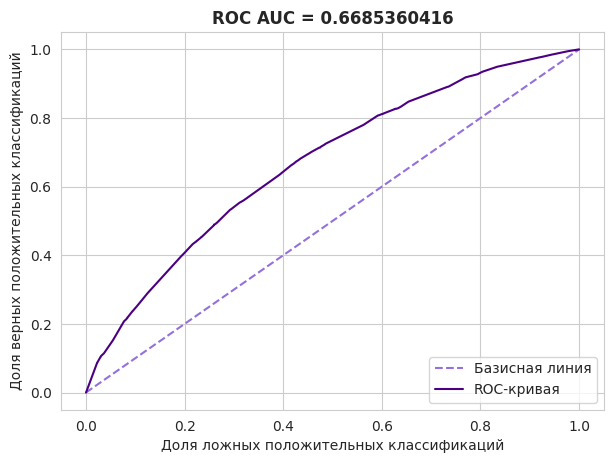

Коэффициент Джини:  0.34


In [ ]:
mi_logreg_1.roc_curve_plot()

Вывод: метрика ROC_AUC - достаточно велика, т.е. построенная модель обладает неплохой предсказательной силой, которая заметно отличается от случайного угадывания

In [ ]:
mi_logreg_1.get_metrics()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy     0.886859
precision    0.000000
recall       0.000000
F1           0.000000
ROC_AUC      0.668536
dtype: float64

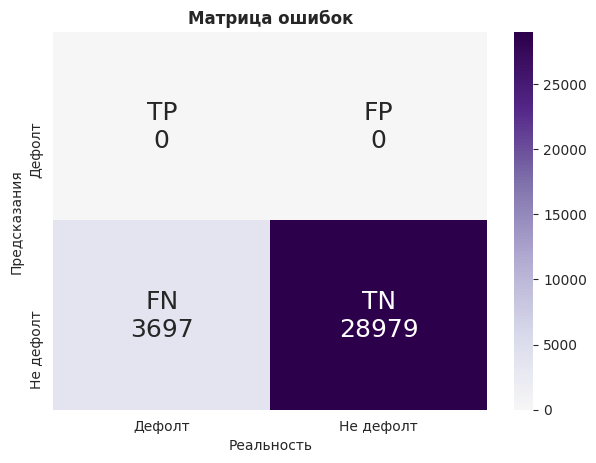

In [ ]:
mi_logreg_1.confusion_matrix_plot()

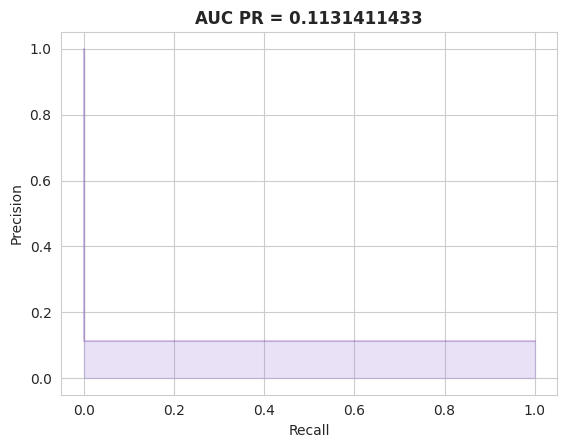

In [ ]:
mi_logreg_1.recall_precision_plot()

**Вывод**: несмотря на то, что метрика ROC_AUC и accuracy достаточно велики, значения метрик recall, precision и F1, говорят о том, что предсказаельная способность очень низкая.

Для улучшения модели попробуем: 

*   сбалансировать модель
*   применить регуляризацию



### Подбор параметров №1

In [ ]:
# запускаем GridSearch на небольшом кол-ве итераций max_iter=50 и с достаточно большой дельтой останова tol1e-3
# чтобы получить оптимальные параметры модели в первом приближении
model = LogisticRegression(random_state=17)

iter_ = 50
epsilon_stop = 1e-3

param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]

gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_
##печатаем параметры
best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))
    ##печатаем метрики
preds = model.predict(X_test)
print('Accuracy: %.4f' % accuracy_score(y_test, preds))
print('Precision: %.4f' % precision_score(y_test, preds))
print('Recall: %.4f' % recall_score(y_test, preds))
print('F1: %.4f' % f1_score(y_test, preds))

In [ ]:
# вторая модель на параметрах после первой оптимизации
model_logreg_11 = LogisticRegression(random_state=17, 
                           C=1, 
                           class_weight= 'balanced', 
                           dual= False, 
                           fit_intercept= True, 
                           intercept_scaling= 1, 
                           l1_ratio= None, 
                           multi_class= 'auto', 
                           n_jobs= None, 
                           penalty= 'l2', 
                           solver = 'sag', 
                           verbose= 0, 
                           warm_start= False)

model_logreg_11.fit(X_train, y_train)

y_pred_prob_logreg_11 = model_logreg_11.predict_proba(X_test)[:,1]
y_pred_logreg_11 = model_logreg_11.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [ ]:
mi_logreg_11 = ModelInspect(model_logreg_11, X_test, y_test)

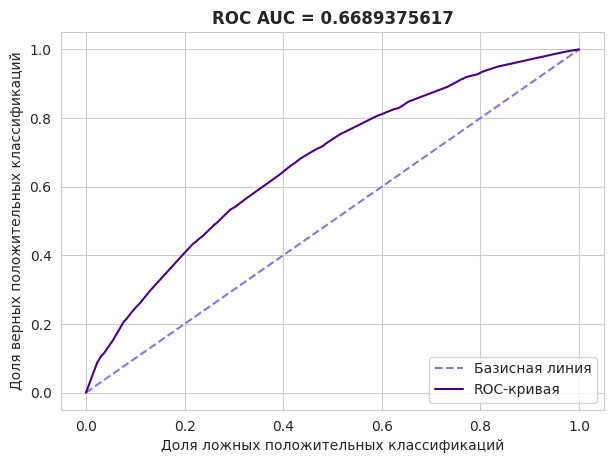

Коэффициент Джини:  0.34


In [ ]:
mi_logreg_11.roc_curve_plot()

In [ ]:
metrics = pd.concat([mi_logreg_1.get_metrics(), mi_logreg_11.get_metrics(), ],axis = 1)
metrics.columns = ['best params 1', 'best params 11']
metrics

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


best params 1  best params 11
accuracy        0.886859        0.588720
precision       0.000000        0.168052
recall          0.000000        0.667027
F1              0.000000        0.268467
ROC_AUC         0.668536        0.668938

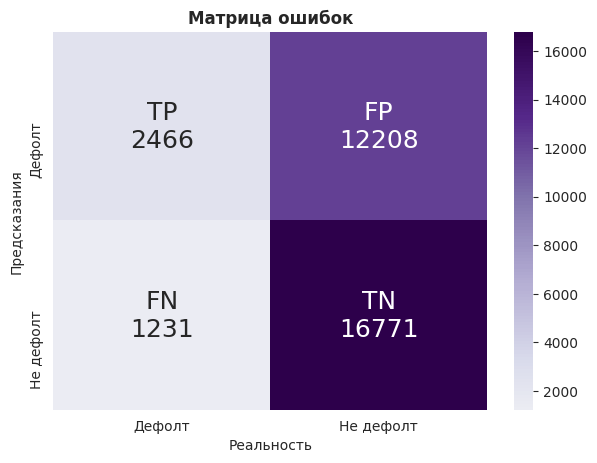

In [ ]:
mi_logreg_11.confusion_matrix_plot()

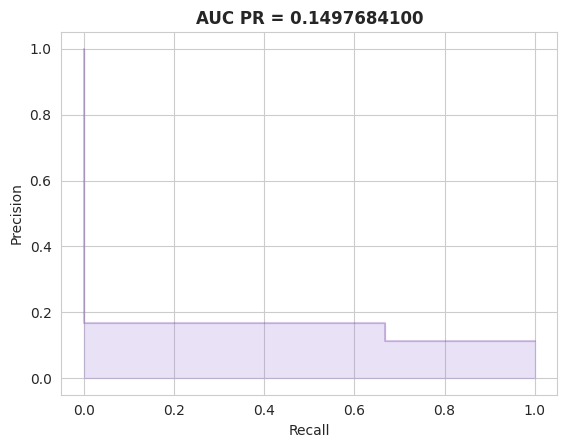

In [ ]:
mi_logreg_11.recall_precision_plot()

После применения параметра балансировки метрики recall, precision и F1 возросли, это означает, что предсказание модели улучшилось. Вместе с этим очень сильно возрасла ошибка первого рода (не дефолт классифицирован как дефолт)

### Проверка нулевых коэффициентов

In [ ]:
# регуляризация первого порядка l1 позволяет оценить по нулевым или слишком низким коэффициентам признаки,
# которые не нравятся модели (в них могут быть выбросы или неподходящий формат)
# можно это поможет избавиться от большой дисперсии при кросс-валидации
model = LogisticRegression(random_state=17, 
                           C=1, 
                           class_weight= 'balanced', 
                           dual= False, 
                           fit_intercept= True, 
                           intercept_scaling= 1, 
                           l1_ratio= None, 
                           multi_class= 'auto', 
                           n_jobs= None, 
                           penalty= 'l1', 
                           solver = 'liblinear', 
                           verbose= 0, 
                           warm_start= False)

model.fit(X_train, y_train)
display(X_train.columns, model.coef_[0])

Index(['home_address_2', 'home_address_3', 'work_address_2',
       '-2.387_to_-2.116', '-2.116_to_-1.865', '-1.865_to_-1.566',
       'more_-1.566', 'client_SNA_2', 'client_SNA_3', 'client_SNA_4'],
      dtype='object')

array([0.45732895, 0.33761425, 0.16425542, 0.38017109, 0.66041723,
       0.97931031, 1.4366597 , 0.39853295, 0.56007947, 0.77797139])

Нулевых коэффициентов нет

### Подбор параметров №2

In [ ]:
model = LogisticRegression(multi_class = 'ovr', class_weight='balanced', solver='liblinear', random_state=17)

param_grid = [
     {'penalty': ['l1'], 'C':[0, 1, 0.1], 'max_iter':[1000],'tol':[1e-5]},
     {'penalty': ['l2'], 'C':[0, 1, 0.1], 'max_iter':[1000],'tol':[1e-5]},
     {'penalty': ['none'], 'max_iter':[1000],'tol':[1e-5]},
 ]
gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_

best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
         print('\t%s: %r' % (param_name, best_parameters[param_name]))

preds = model.predict(X_test)
print('Accuracy: %.4f' % accuracy_score(y_test, preds))
print('Precision: %.4f' % precision_score(y_test, preds))
print('Recall: %.4f' % recall_score(y_test, preds))
print('F1: %.4f' % f1_score(y_test, preds))

	C: 0.1
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 1000
	multi_class: 'ovr'
	n_jobs: None
	penalty: 'l2'
	random_state: 17
	solver: 'liblinear'
	tol: 1e-05
	verbose: 0
	warm_start: False
Accuracy: 0.5887
Precision: 0.1681
Recall: 0.6670
F1: 0.2685


Коэффициент регуляризации получился сликшом большой, модель могла переобучиться, поэтому нужно проверить с помощью кросс-валидации

In [ ]:
# третья модель
model_logreg_12 = LogisticRegression(C=0.1,
                           penalty='l2', 
                           multi_class = 'ovr', 
                           class_weight='balanced', 
                           solver='liblinear', 
                           random_state=17,
                           max_iter = 1000)

model_logreg_12.fit(X_train, y_train)

y_pred_prob_logreg_12 = model_logreg_12.predict_proba(X_test)[:,1]
y_pred_logreg_12 = model_logreg_12.predict(X_test)

In [ ]:
mi_logreg_12 = ModelInspect(model_logreg_12, X_test, y_test)

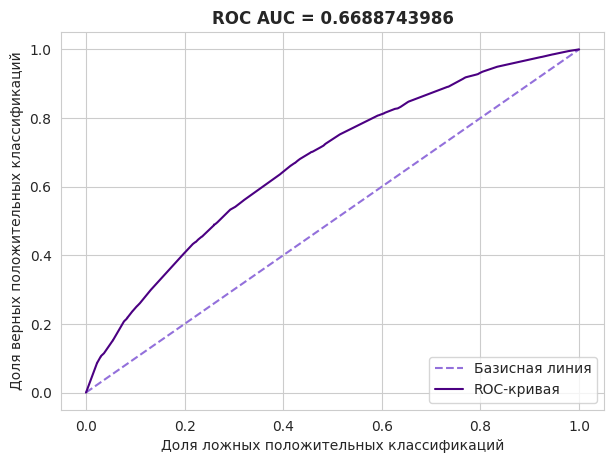

Коэффициент Джини:  0.34


In [ ]:
mi_logreg_12.roc_curve_plot()

In [ ]:
metrics = pd.concat([mi_logreg_1.get_metrics(), mi_logreg_11.get_metrics(), mi_logreg_12.get_metrics()],axis = 1)
metrics.columns = ['best params 1', 'best params 11', 'best params 12']
metrics

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


best params 1  best params 11  best params 12
accuracy        0.886859        0.588720        0.588720
precision       0.000000        0.168052        0.168052
recall          0.000000        0.667027        0.667027
F1              0.000000        0.268467        0.268467
ROC_AUC         0.668536        0.668938        0.668874

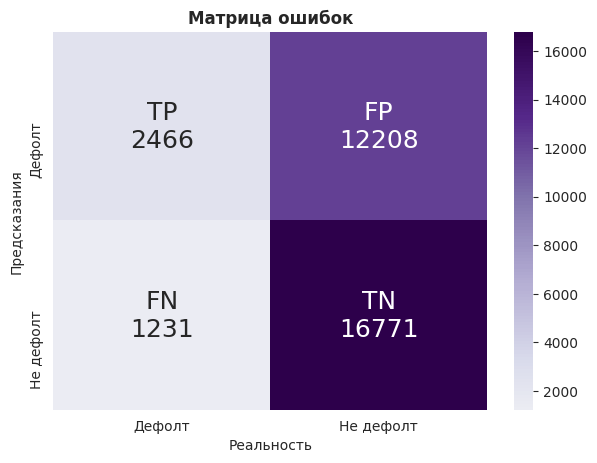

In [ ]:
mi_logreg_12.confusion_matrix_plot()

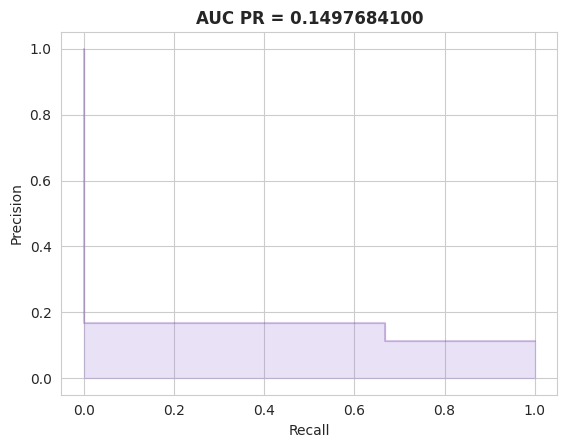

In [ ]:
mi_logreg_12.recall_precision_plot()

### Кросс-валидация

In [ ]:
train_data = df_features_1.query('sample_cd == 1').drop(['sample_cd'], axis=1)
test_data = df_features_1.query('sample_cd == 0').drop(['sample_cd'], axis=1)

y_1 = train_data['default_flg']
X_1 = train_data.drop(['default_flg'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=0.2, random_state=42)

In [ ]:
# без регуляризации
model_logreg_0 = LogisticRegression(
  C = 1,
  class_weight = 'balanced',
  dual = False,
  fit_intercept = True,
  intercept_scaling = 1,
  l1_ratio = None,
  max_iter = 50,
  multi_class = 'auto',
  n_jobs = None,
  penalty = 'l2',
  random_state = 42,
  solver = 'liblinear',
  tol = 0.001,
  verbose = 0,
  warm_start = False
)

In [ ]:
model_logreg_01 = LogisticRegression(
  C = 0.1,
  class_weight = 'balanced',
  dual = False,
  fit_intercept = True,
  intercept_scaling = 1,
  l1_ratio = None,
  max_iter = 50,
  multi_class = 'auto',
  n_jobs = None,
  penalty = 'l2',
  random_state = 42,
  solver = 'liblinear',
  tol = 0.001,
  verbose = 0,
  warm_start = False)

In [ ]:
scores0 = cross_val_score(model_logreg_0, X, y, cv=10, scoring='f1')
scores1 = cross_val_score(model_logreg_01, X, y, cv=10, scoring='f1')

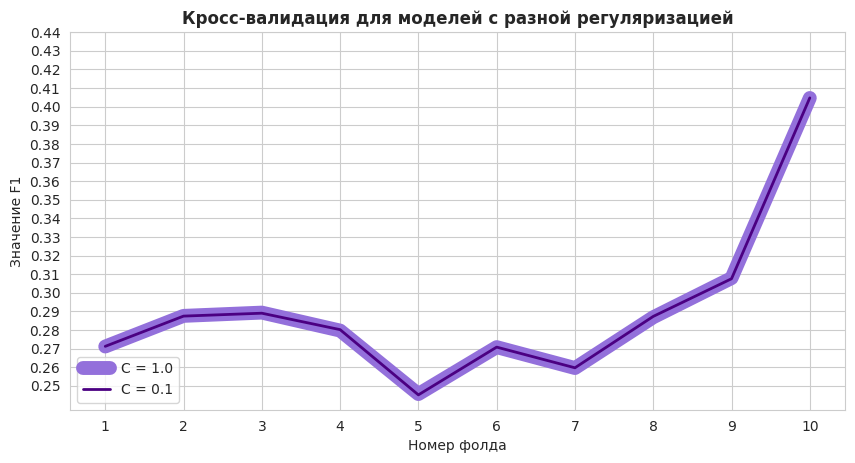

In [ ]:
x = np.arange(1,11)

fig, ax = plt.subplots(1, 1, figsize = (10,5))
plt.plot(x, scores0, label = 'C = 1.0', linewidth=10, color='lightgray')
plt.plot(x, scores1, label = 'C = 0.1', linewidth=2, color='grey')
plt.legend(loc = 'lower left')
plt.title('Кросс-валидация для моделей с разной регуляризацией', fontsize=12,  weight='bold')
plt.ylabel('Значение F1', fontsize=10)
plt.xlabel('Номер фолда', fontsize=10)
ax.set_xticks(x)
yticks = np.arange(0.25, 0.45, 0.01)
ax.set_yticks(yticks)
ax.grid(True)

### Подбор параметров №3 LogisticRegressionCV

In [ ]:
train_data = df_features_1.query('sample_cd == 1').drop(['sample_cd'], axis=1)
test_data = df_features_1.query('sample_cd == 0').drop(['sample_cd'], axis=1)

y_1 = train_data['default_flg']
X_1 = train_data.drop(['default_flg'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=0.2, random_state=42)

In [ ]:
# без регуляризации
model_logreg_0 = LogisticRegression(
  C = 1,
  class_weight = 'balanced',
  dual = False,
  fit_intercept = True,
  intercept_scaling = 1,
  l1_ratio = None,
  max_iter = 50,
  multi_class = 'auto',
  n_jobs = None,
  penalty = 'l2',
  random_state = 42,
  solver = 'liblinear',
  tol = 0.001,
  verbose = 0,
  warm_start = False
)

In [ ]:
model_logreg_01 = LogisticRegression(
  C = 0.00064281,
  solver = 'saga',
  tol = 0.0001,
  max_iter = 1000,   
  class_weight = 'balanced',
  n_jobs = -1,
  random_state = 42,
)

In [ ]:
scores0 = cross_val_score(model_logreg_0, X, y, cv=10, scoring='f1')
scores1 = cross_val_score(model_logreg_01, X, y, cv=10, scoring='f1')

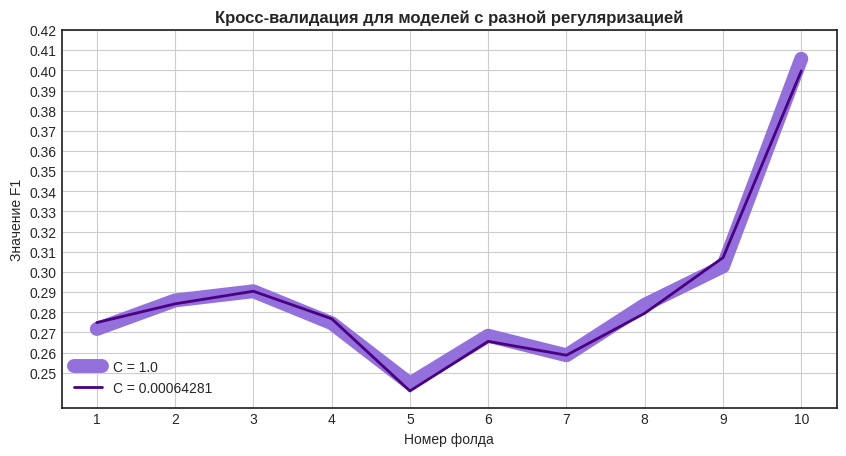

In [ ]:
x = np.arange(1,11)

fig, ax = plt.subplots(1, 1, figsize = (10,5))
plt.plot(x, scores0, label = 'C = 1.0', linewidth=10, color='lightgray')
plt.plot(x, scores1, label = 'C = 0.00064281', linewidth=2, color='grey')
plt.legend(loc = 'lower left')
plt.title('Кросс-валидация для моделей с разной регуляризацией', fontsize=12,  weight='bold')
plt.ylabel('Значение F1', fontsize=10)
plt.xlabel('Номер фолда', fontsize=10)
ax.set_xticks(x)
yticks = np.arange(0.25, 0.43, 0.01)
ax.set_yticks(yticks)
ax.grid(True)

In [ ]:
Cs_ = np.logspace(-4, 4, 100)

In [ ]:
from sklearn.linear_model import LogisticRegressionCV

model = LogisticRegressionCV(
  Cs = Cs_,
  cv = 5,
  scoring = 'f1',
  solver = 'saga',
  tol = 0.0001,
  max_iter = 1000,   
  class_weight = 'balanced',
  n_jobs = -1,
  random_state = 42,
)

model.fit(X_train, y_train)

LogisticRegressionCV(Cs=array([1.00000000e-04, 1.20450354e-04, 1.45082878e-04, 1.74752840e-04,
       2.10490414e-04, 2.53536449e-04, 3.05385551e-04, 3.67837977e-04,
       4.43062146e-04, 5.33669923e-04, 6.42807312e-04, 7.74263683e-04,
       9.32603347e-04, 1.12332403e-03, 1.35304777e-03, 1.62975083e-03,
       1.96304065e-03, 2.36448941e-03, 2.84803587e-03, 3.43046929e-03,
       4.13201240e-03, 4.97...
       1.29154967e+03, 1.55567614e+03, 1.87381742e+03, 2.25701972e+03,
       2.71858824e+03, 3.27454916e+03, 3.94420606e+03, 4.75081016e+03,
       5.72236766e+03, 6.89261210e+03, 8.30217568e+03, 1.00000000e+04]),
                     class_weight='balanced', cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=1000, multi_class='auto', n_jobs=-1, penalty='l2',
                     random_state=42, refit=True, scoring='f1', solver='saga',
                     tol=0.0001, verbose=0)

In [ ]:
model.C_

array([0.00064281])

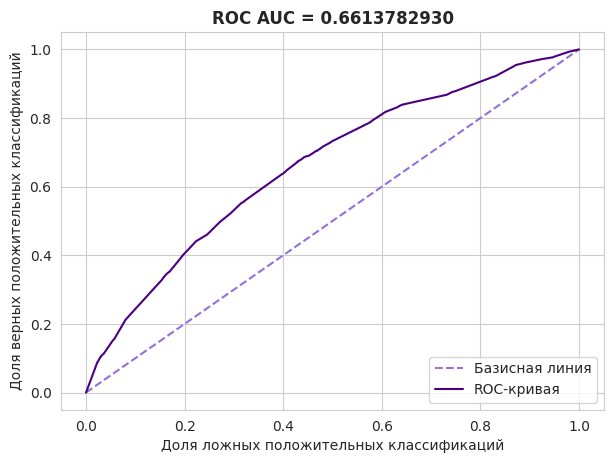

Коэффициент Джини:  0.32


In [ ]:
mi_CV = ModelInspect(model, X_test, y_test)
mi_CV.roc_curve_plot()

In [ ]:
metrics = pd.concat([mi_logreg_1.get_metrics(), mi_logreg_11.get_metrics(), mi_logreg_12.get_metrics(), mi_CV.get_metrics()],axis = 1)
metrics.columns = ['best params 1', 'best params 11', 'best params 12', 'best params CV']
metrics

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


best params 1  best params 11  best params 12  best params CV
accuracy        0.886859        0.588720        0.588720        0.598972
precision       0.000000        0.168052        0.168052        0.168698
recall          0.000000        0.667027        0.667027        0.647823
F1              0.000000        0.268467        0.268467        0.267687
ROC_AUC         0.668536        0.668938        0.668874        0.661378

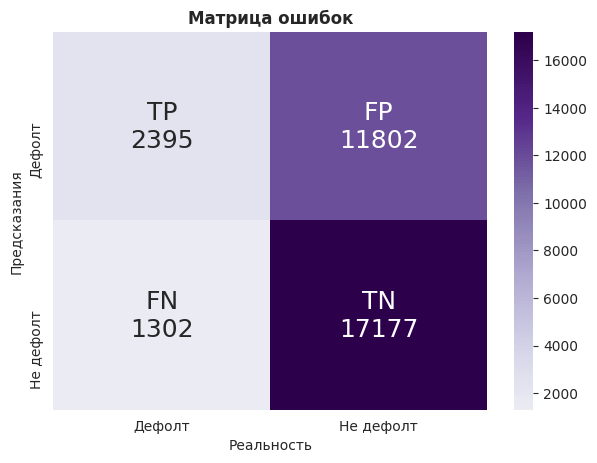

In [ ]:
mi_CV.confusion_matrix_plot()

Метод LogisticRegressionCV улучшил предсказаетльные способности модели

### Undersampling

In [ ]:
train_data = df_features_1.query('sample_cd == 1').drop(['sample_cd'], axis=1)
test_data = df_features_1.query('sample_cd == 0').drop(['sample_cd'], axis=1)

y_1 = train_data['default_flg']
X_1 = train_data.drop(['default_flg'], axis=1)

In [ ]:
rus = RandomUnderSampler(random_state=42)
X_us, y_us = rus.fit_resample(X_1, y_1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_us, y_us, test_size=0.10, shuffle = True, random_state=42)

In [ ]:
Cs_ = np.logspace(-4, 4, 100)

In [ ]:
model_logreg_us_1 = LogisticRegressionCV(
  Cs = Cs_,
  cv = 5,
  scoring = 'f1',
  solver = 'saga',
  tol = 0.0001,
  max_iter = 1000,   
  n_jobs = -1,
  random_state = 42,
)

model_logreg_us_1.fit(X_train, y_train)
mi_logreg_us_1 = ModelInspect(model_logreg_us_1, X_test, y_test)

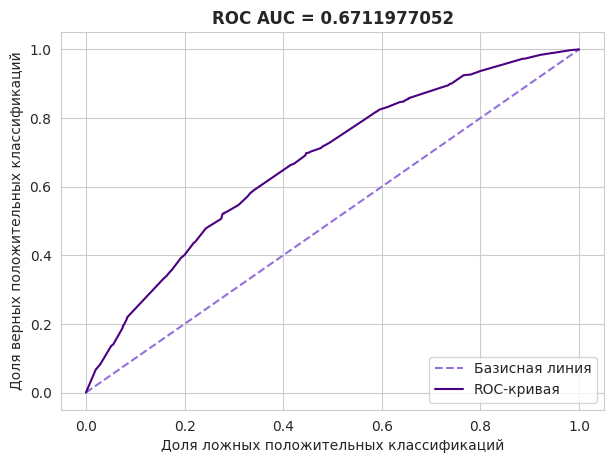

Коэффициент Джини:  0.34


In [ ]:
mi_logreg_us_1.roc_curve_plot()

In [ ]:
mi_logreg_us_1.get_metrics()

accuracy     0.622133
precision    0.609229
recall       0.666488
F1           0.636573
ROC_AUC      0.671198
dtype: float64

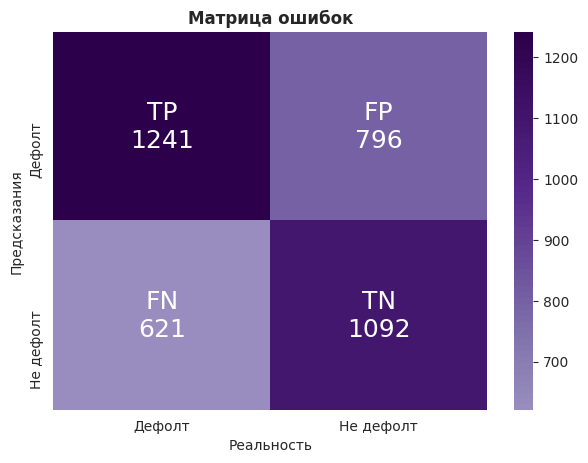

In [ ]:
mi_logreg_us_1.confusion_matrix_plot()

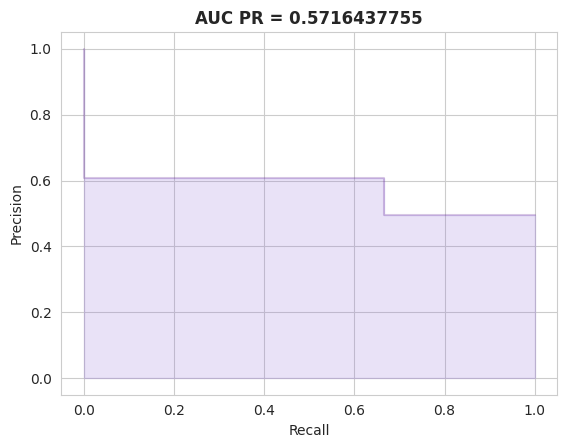

In [ ]:
mi_logreg_us_1.recall_precision_plot()

## 1.2 Логистическая регрессия 

In [ ]:
train_data = df_features_2.query('sample_cd == 1').drop(['sample_cd'], axis=1)
test_data = df_features_2.query('sample_cd == 0').drop(['sample_cd'], axis=1)

y_2 = train_data['default_flg']
X_2 = train_data.drop(['default_flg'], axis=1)

In [ ]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X_2, y_2, test_size=0.2, random_state=42)

### Первая модель

In [ ]:
model_logreg_2 = LogisticRegression(random_state=17)

model_logreg_2.fit(X_train, y_train)

y_pred_prob_logreg_2 = model_logreg_2.predict_proba(X_test)[:,1]
y_pred_logreg_2 = model_logreg_2.predict(X_test)

In [ ]:
mi_logreg_2 = ModelInspect(model_logreg_2, X_test, y_test)

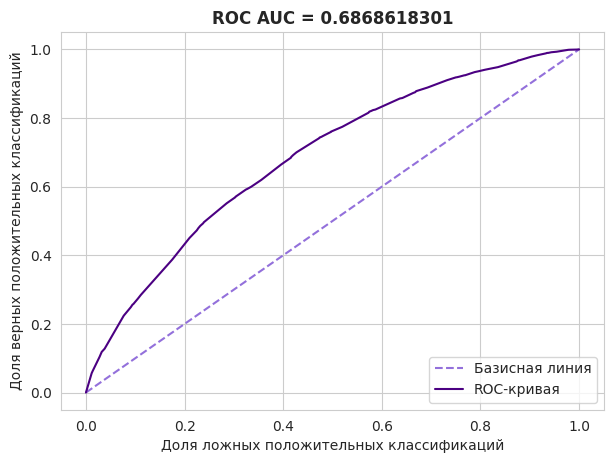

Коэффициент Джини:  0.37


In [ ]:
mi_logreg_2.roc_curve_plot()

Вывод: метрика ROC_AUC - достаточно велика, т.е. построенная модель обладает неплохой предсказательной силой, которая заметно отличается от случайного угадывания

In [ ]:
mi_logreg_2.get_metrics()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy     0.886859
precision    0.000000
recall       0.000000
F1           0.000000
ROC_AUC      0.686862
dtype: float64

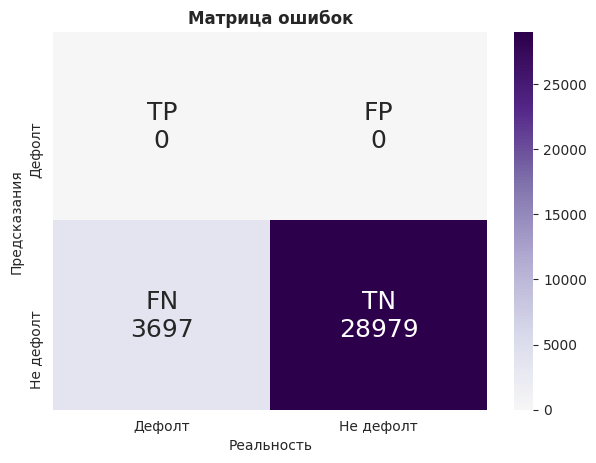

In [ ]:
mi_logreg_2.confusion_matrix_plot()

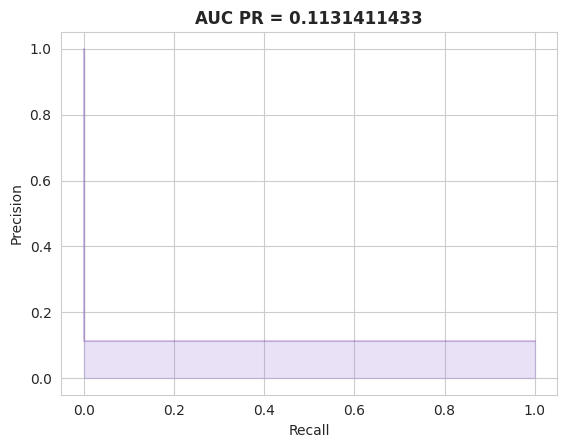

In [ ]:
mi_logreg_2.recall_precision_plot()

### Подбор параметров №1

In [ ]:
# запускаем GridSearch на небольшом кол-ве итераций max_iter=50 и с достаточно большой дельтой останова tol1e-3
# чтобы получить оптимальные параметры модели в первом приближении
model = LogisticRegression(random_state=17)

iter_ = 50
epsilon_stop = 1e-3

param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]
gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_
##печатаем параметры
best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))
    ##печатаем метрики
preds = model.predict(X_test)
print('Accuracy: %.4f' % accuracy_score(y_test, preds))
print('Precision: %.4f' % precision_score(y_test, preds))
print('Recall: %.4f' % recall_score(y_test, preds))
print('F1: %.4f' % f1_score(y_test, preds))

In [ ]:
# вторая модель на параметрах после первой оптимизации
model_logreg_21 = LogisticRegression(random_state=17, 
                           C=1, 
                           class_weight= 'balanced', 
                           dual= False, 
                           fit_intercept= True, 
                           intercept_scaling= 1, 
                           l1_ratio= None, 
                           multi_class= 'auto', 
                           n_jobs= None, 
                           penalty= 'l1', 
                           solver = 'liblinear', 
                           verbose= 0, 
                           warm_start= False)

model_logreg_21.fit(X_train, y_train)

y_pred_prob_logreg_21 = model_logreg_21.predict_proba(X_test)[:,1]
y_pred_logreg_21 = model_logreg_21.predict(X_test)

In [ ]:
mi_logreg_21 = ModelInspect(model_logreg_21, X_test, y_test)

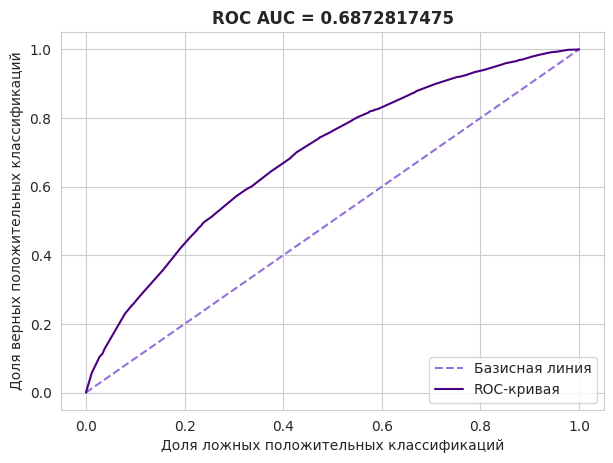

Коэффициент Джини:  0.37


In [ ]:
mi_logreg_21.roc_curve_plot()

In [ ]:
metrics = pd.concat([mi_logreg_2.get_metrics(), mi_logreg_21.get_metrics()],axis = 1)
metrics.columns = ['best params 2', 'best params 21']
metrics

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


best params 2  best params 21
accuracy        0.886859        0.626729
precision       0.000000        0.179680
recall          0.000000        0.644847
F1              0.000000        0.281049
ROC_AUC         0.686862        0.687282

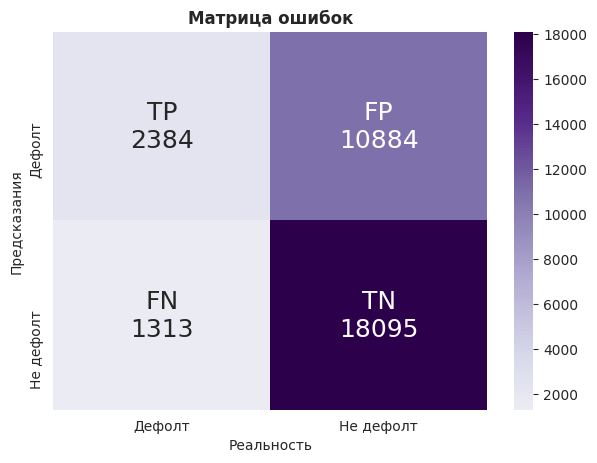

In [ ]:
mi_logreg_21.confusion_matrix_plot()

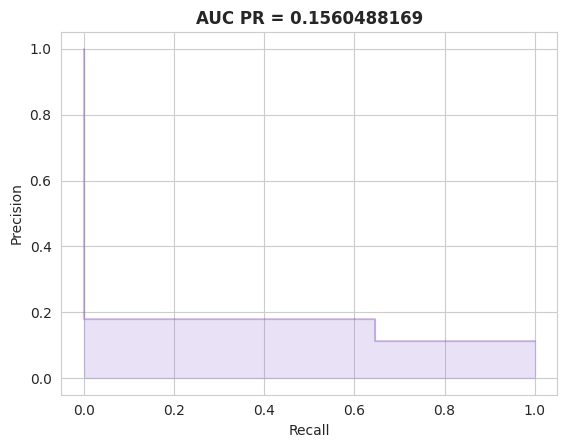

In [ ]:
mi_logreg_21.recall_precision_plot()

### Проверка нулевых коэффициентов

In [ ]:
# регуляризация первого порядка l1 позволяет оценить по нулевым или слишком низким коэффициентам признаки,
# которые не нравятся модели (в них могут быть выбросы или неподходящий формат)
# можно это поможет избавиться от большой дисперсии при кросс-валидации
model = LogisticRegression(random_state=17, 
                           C=1, 
                           class_weight= 'balanced', 
                           dual= False, 
                           fit_intercept= True, 
                           intercept_scaling= 1, 
                           l1_ratio= None, 
                           multi_class= 'auto', 
                           n_jobs= None, 
                           penalty= 'l1', 
                           solver = 'liblinear', 
                           verbose= 0, 
                           warm_start= False)

model.fit(X_train, y_train)
display(X_train.columns, model.coef_[0])

Index(['SCH', 'UGR', 'home_address_2', '-2.387_to_-2.116', '-2.116_to_-1.865',
       '-1.865_to_-1.566', 'more_-1.566', 'client_SNA_4', 'region_rating_70',
       'region_rating_80'],
      dtype='object')

array([ 0.57621325,  0.41471205,  0.47079394,  0.37013446,  0.66794809,
        0.99516515,  1.49402883,  0.55722568, -0.50464993, -0.7846265 ])

### Подбор параметров №2

In [ ]:
model = LogisticRegression(multi_class = 'ovr', class_weight='balanced', solver='liblinear', random_state=17)

param_grid = [
     {'penalty': ['l1'], 'C':[0, 1, 0.1], 'max_iter':[1000],'tol':[1e-5]},
     {'penalty': ['l2'], 'C':[0, 1, 0.1], 'max_iter':[1000],'tol':[1e-5]},
     {'penalty': ['none'], 'max_iter':[1000],'tol':[1e-5]},
 ]
gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_

best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
         print('\t%s: %r' % (param_name, best_parameters[param_name]))

preds = model.predict(X_test)
print('Accuracy: %.4f' % accuracy_score(y_test, preds))
print('Precision: %.4f' % precision_score(y_test, preds))
print('Recall: %.4f' % recall_score(y_test, preds))
print('F1: %.4f' % f1_score(y_test, preds))

	C: 1
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 1000
	multi_class: 'ovr'
	n_jobs: None
	penalty: 'l1'
	random_state: 17
	solver: 'liblinear'
	tol: 1e-05
	verbose: 0
	warm_start: False
Accuracy: 0.6380
Precision: 0.1892
Recall: 0.6496
F1: 0.2930


In [ ]:
model_logreg_22 = LogisticRegression(C=0.1,
                           penalty='l1', 
                           multi_class = 'ovr', 
                           class_weight='balanced', 
                           solver='liblinear', 
                           random_state=17,
                           max_iter = 1000)

model_logreg_22.fit(X_train, y_train)

y_pred_prob_logreg_22 = model_logreg_22.predict_proba(X_test)[:,1]
y_pred_logreg_22 = model_logreg_22.predict(X_test)

In [ ]:
mi_logreg_22 = ModelInspect(model_logreg_22, X_test, y_test)

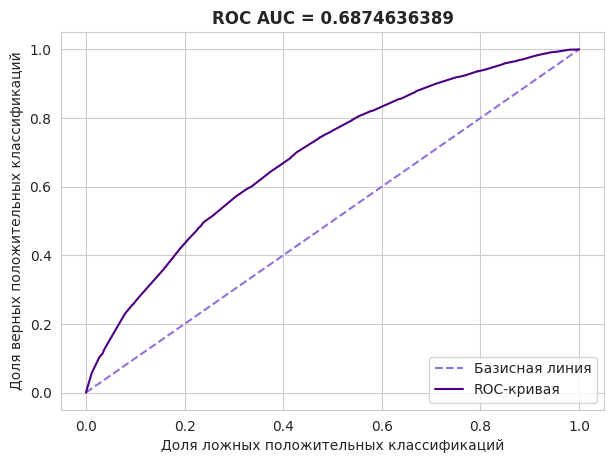

Коэффициент Джини:  0.37


In [ ]:
mi_logreg_22.roc_curve_plot()

In [ ]:
metrics = pd.concat([mi_logreg_2.get_metrics(), mi_logreg_21.get_metrics(), mi_logreg_22.get_metrics()],axis = 1)
metrics.columns = ['best params 2', 'best params 21', 'best params 22']
metrics

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


best params 2  best params 21  best params 22
accuracy        0.886859        0.626729        0.626729
precision       0.000000        0.179680        0.179680
recall          0.000000        0.644847        0.644847
F1              0.000000        0.281049        0.281049
ROC_AUC         0.686862        0.687282        0.687464

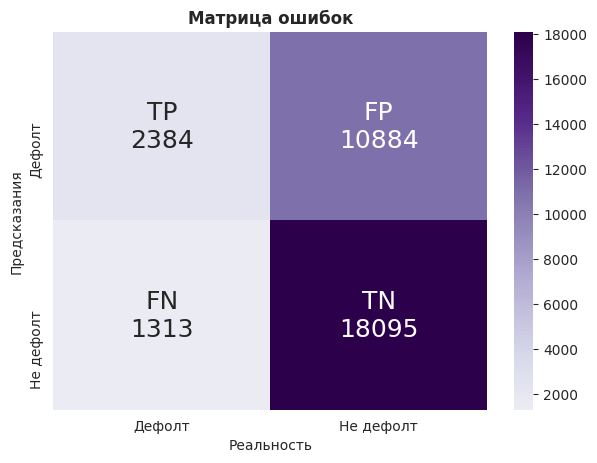

In [ ]:
mi_logreg_22.confusion_matrix_plot()

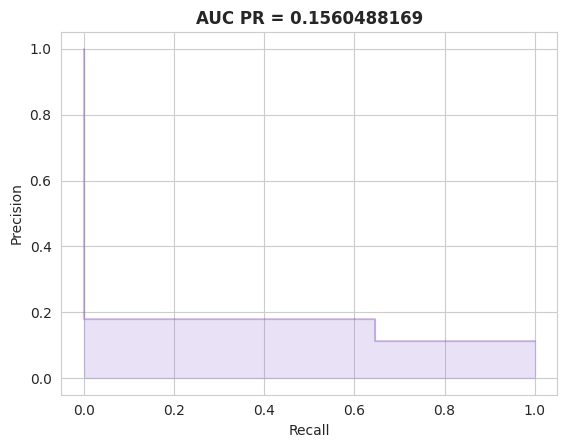

In [ ]:
mi_logreg_22.recall_precision_plot()

### Подбор параметров №3 LogisticRegressionCV

In [ ]:
train_data = df_features_2.query('sample_cd == 1').drop(['sample_cd'], axis=1)
test_data = df_features_2.query('sample_cd == 0').drop(['sample_cd'], axis=1)

y_2 = train_data['default_flg']
X_2 = train_data.drop(['default_flg'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_2, y_2, test_size=0.2, random_state=42)

In [ ]:
Cs_ = np.logspace(-4, 4, 100)

In [ ]:
model = LogisticRegressionCV(
  Cs = Cs_,
  cv = 5,
  scoring = 'f1',
  solver = 'saga',
  tol = 0.0001,
  max_iter = 1000,   
  class_weight = 'balanced',
  n_jobs = -1,
  random_state = 42,
)

model.fit(X_train, y_train)

LogisticRegressionCV(Cs=array([1.00000000e-04, 1.20450354e-04, 1.45082878e-04, 1.74752840e-04,
       2.10490414e-04, 2.53536449e-04, 3.05385551e-04, 3.67837977e-04,
       4.43062146e-04, 5.33669923e-04, 6.42807312e-04, 7.74263683e-04,
       9.32603347e-04, 1.12332403e-03, 1.35304777e-03, 1.62975083e-03,
       1.96304065e-03, 2.36448941e-03, 2.84803587e-03, 3.43046929e-03,
       4.13201240e-03, 4.97...
       1.29154967e+03, 1.55567614e+03, 1.87381742e+03, 2.25701972e+03,
       2.71858824e+03, 3.27454916e+03, 3.94420606e+03, 4.75081016e+03,
       5.72236766e+03, 6.89261210e+03, 8.30217568e+03, 1.00000000e+04]),
                     class_weight='balanced', cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=1000, multi_class='auto', n_jobs=-1, penalty='l2',
                     random_state=42, refit=True, scoring='f1', solver='saga',
                     tol=0.0001, verbose=0)

In [ ]:
# без регуляризации
model_logreg_0 = LogisticRegression(
  C = 1,
  class_weight = 'balanced',
  dual = False,
  fit_intercept = True,
  intercept_scaling = 1,
  l1_ratio = None,
  max_iter = 50,
  multi_class = 'auto',
  n_jobs = None,
  penalty = 'l2',
  random_state = 42,
  solver = 'liblinear',
  tol = 0.001,
  verbose = 0,
  warm_start = False
)

In [ ]:
model_logreg_01 = LogisticRegression(
  C = 0.00722081,
  solver = 'saga',
  tol = 0.0001,
  max_iter = 1000,   
  class_weight = 'balanced',
  n_jobs = -1,
  random_state = 42,
)

In [ ]:
scores0 = cross_val_score(model_logreg_0, X, y, cv=10, scoring='f1')
scores1 = cross_val_score(model_logreg_01, X, y, cv=10, scoring='f1')

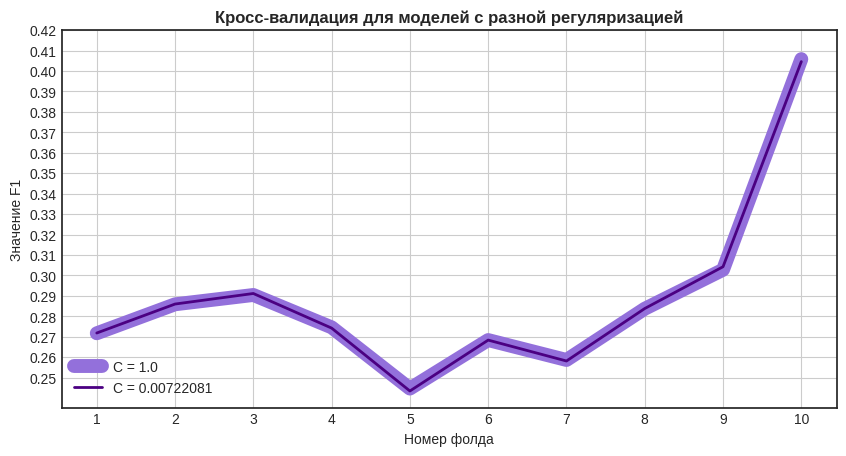

In [ ]:
x = np.arange(1,11)

fig, ax = plt.subplots(1, 1, figsize = (10,5))
plt.plot(x, scores0, label = 'C = 1.0', linewidth=10, color='lightgray')
plt.plot(x, scores1, label = 'C = 0.00722081', linewidth=2, color='grey')
plt.legend(loc = 'lower left')
plt.title('Кросс-валидация для моделей с разной регуляризацией', fontsize=12,  weight='bold')
plt.ylabel('Значение F1', fontsize=10)
plt.xlabel('Номер фолда', fontsize=10)
ax.set_xticks(x)
yticks = np.arange(0.25, 0.43, 0.01)
ax.set_yticks(yticks)
ax.grid(True)

In [ ]:
model.C_

array([0.00722081])

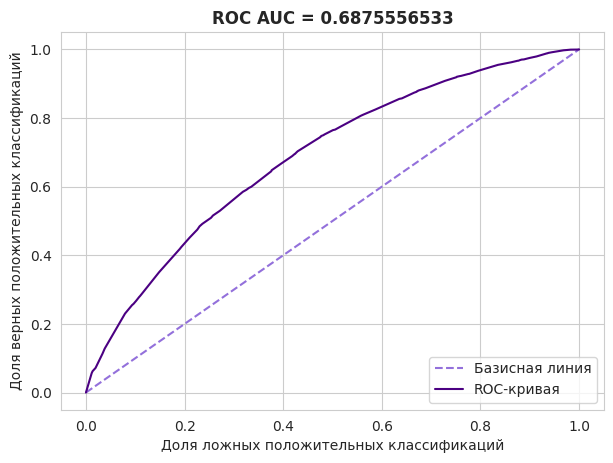

Коэффициент Джини:  0.38


In [ ]:
mi_CV = ModelInspect(model, X_test, y_test)
mi_CV.roc_curve_plot()

In [ ]:
metrics = pd.concat([mi_logreg_2.get_metrics(), mi_logreg_21.get_metrics(), mi_logreg_22.get_metrics(), mi_CV.get_metrics()],axis = 1)
metrics.columns = ['best params 2', 'best params 21', 'best params 22', 'best params CV']
metrics

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


best params 2  best params 21  best params 22  best params CV
accuracy        0.886859        0.626729        0.626729        0.657394
precision       0.000000        0.179680        0.179680        0.185803
recall          0.000000        0.644847        0.644847        0.599675
F1              0.000000        0.281049        0.281049        0.283703
ROC_AUC         0.686862        0.687282        0.687464        0.687556

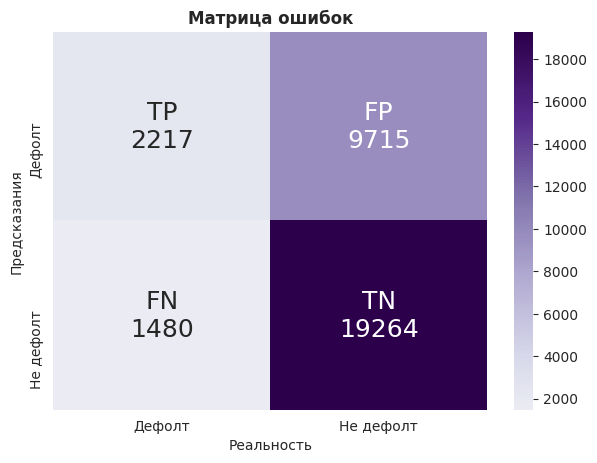

In [ ]:
mi_CV.confusion_matrix_plot()

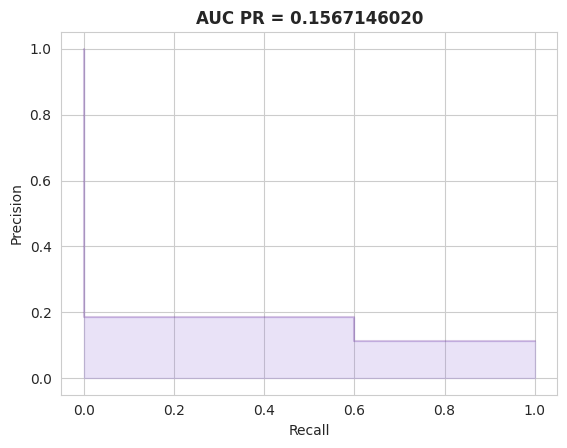

In [ ]:
mi_CV.recall_precision_plot()

Метод LogisticRegressionCV улучшил предсказаетльные способности модели

### Undersampling

In [ ]:
train_data = df_features_2.query('sample_cd == 1').drop(['sample_cd'], axis=1)
test_data = df_features_2.query('sample_cd == 0').drop(['sample_cd'], axis=1)

y_2 = train_data['default_flg']
X_2 = train_data.drop(['default_flg'], axis=1)

In [ ]:
rus = RandomUnderSampler(random_state=42)
X_us, y_us = rus.fit_resample(X_2, y_2)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_us, y_us, test_size=0.10, shuffle = True, random_state=42)

In [ ]:
Cs_ = np.logspace(-4, 4, 100)

In [ ]:
model_logreg_us = LogisticRegressionCV(
  Cs = Cs_,
  cv = 5,
  scoring = 'f1',
  solver = 'saga',
  tol = 0.0001,
  max_iter = 1000,   
  n_jobs = -1,
  random_state = 42,
)

model_logreg_us.fit(X_train, y_train)
mi_logreg_us = ModelInspect(model_logreg_us, X_test, y_test)

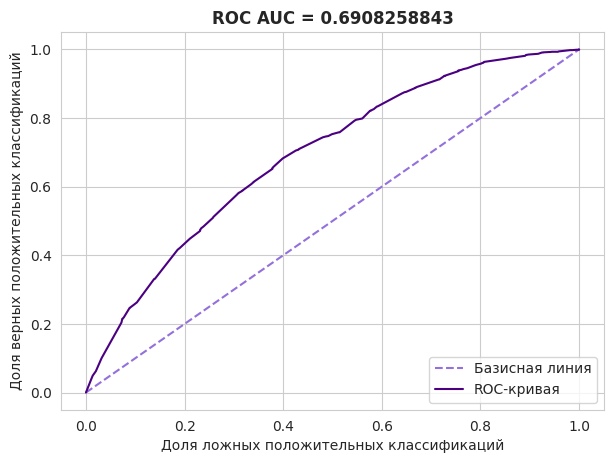

Коэффициент Джини:  0.38


In [ ]:
mi_logreg_us.roc_curve_plot()

In [ ]:
mi_logreg_us.get_metrics()

accuracy     0.638133
precision    0.630626
recall       0.654672
F1           0.642424
ROC_AUC      0.690826
dtype: float64

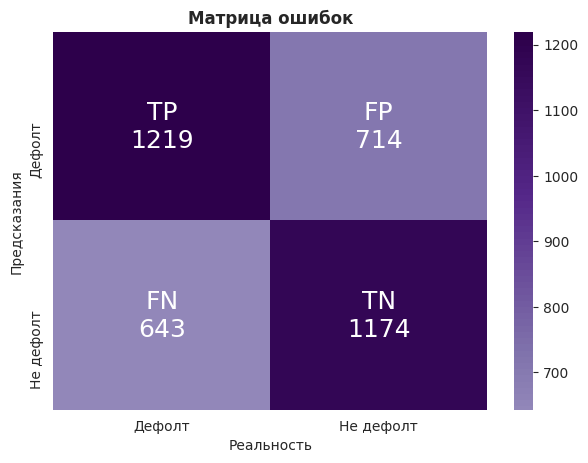

In [ ]:
mi_logreg_us.confusion_matrix_plot()

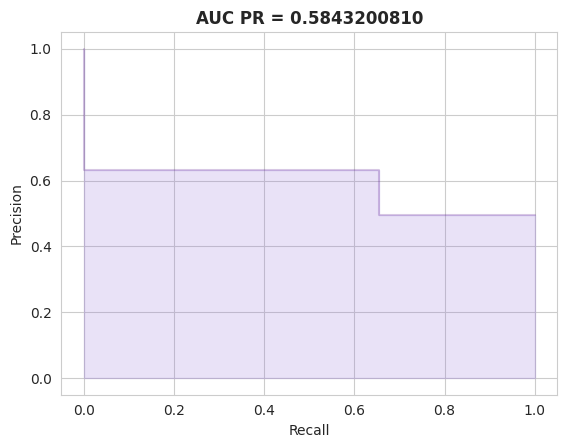

In [ ]:
mi_logreg_us.recall_precision_plot()

## 2.1 К-ближайших соседей

In [ ]:
train_data = df_features_1.query('sample_cd == 1').drop(['sample_cd'], axis=1)
test_data = df_features_1.query('sample_cd == 0').drop(['sample_cd'], axis=1)

y_1 = train_data['default_flg']
X_1 = train_data.drop(['default_flg'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=0.2, random_state=42)

### Первая модель

In [ ]:
# первая модель на автомате
model_knn_1 = KNeighborsClassifier(n_neighbors=6)

model_knn_1.fit(X_train, y_train)

y_pred_prob_knn_1 = model_knn_1.predict_proba(X_test)[:,1]
y_pred_knn_1 = model_knn_1.predict(X_test)

In [ ]:
mi_knn_1 = ModelInspect(model_knn_1, X_test, y_test)

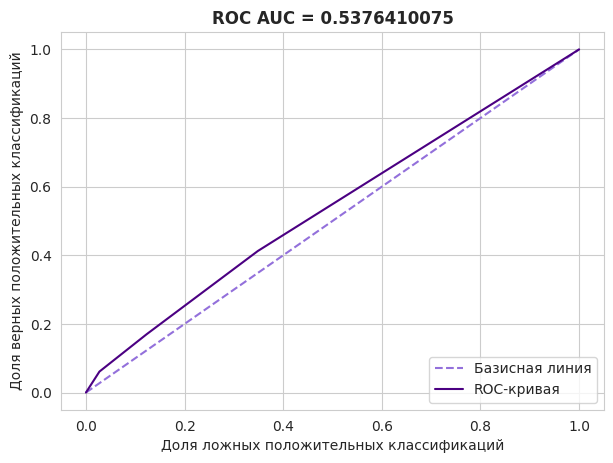

Коэффициент Джини:  0.08


In [ ]:
mi_knn_1.roc_curve_plot()

In [ ]:
mi_knn_1.get_metrics()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy     0.886859
precision    0.000000
recall       0.000000
F1           0.000000
ROC_AUC      0.537641
dtype: float64

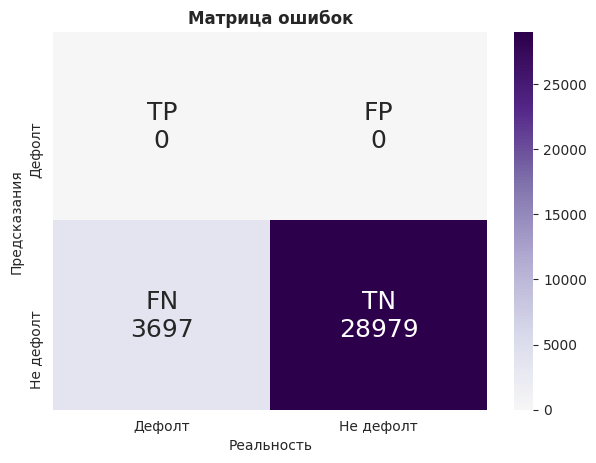

In [ ]:
mi_knn_1.confusion_matrix_plot()

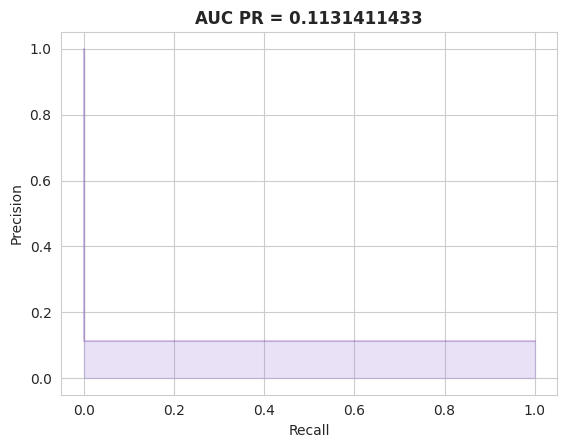

In [ ]:
mi_knn_1.recall_precision_plot()

### Подбор параметров 1

In [ ]:
knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_jobs=-1))])

In [ ]:
knn_params = {'knn__n_neighbors': range(1, 10)}

In [ ]:
knn_grid = GridSearchCV(knn_pipe, knn_params, cv=5, n_jobs=-1, verbose=True)

In [ ]:
knn_grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 29.3min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('knn',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=-1,
                                                             n_neighbors=5, p=2,
                                                             weights='uniform'))],
                                verbose=False),
             

In [ ]:
knn_grid.best_params_, knn_grid.best_score_

({'knn__n_neighbors': 2}, 0.8847463331324237)

### Вторая модель

In [ ]:
# вторая модель с настроенными гиперпараметрами
model_knn_11 = KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=2, p=2,
                                            weights='distance')

model_knn_11.fit(X_train, y_train)

y_pred_prob_knn_11 = model_knn_11.predict_proba(X_test)[:,1]
y_pred_knn_11 = model_knn_11.predict(X_test)

In [ ]:
mi_knn_11 = ModelInspect(model_knn_11, X_test, y_test)

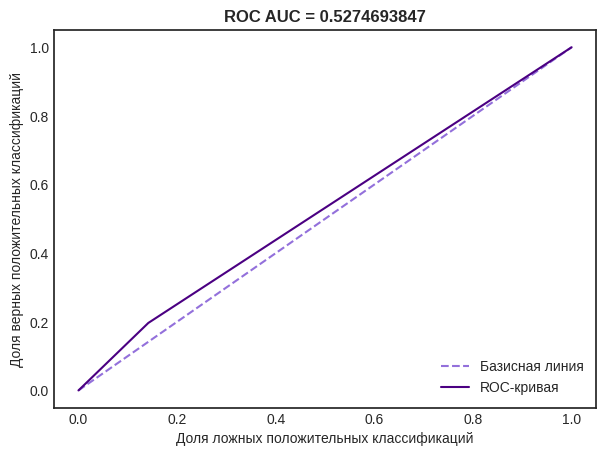

Коэффициент Джини:  0.05


In [ ]:
mi_knn_11.roc_curve_plot()

In [ ]:
metrics = pd.concat([mi_knn_1.get_metrics(), mi_knn_11.get_metrics()],axis = 1)
metrics.columns = ['best params 1', 'best params 11']
metrics

NameError: ignored

In [ ]:
mi_knn_11.get_metrics()

accuracy     0.886492
precision    0.125000
recall       0.000541
F1           0.001077
ROC_AUC      0.527469
dtype: float64

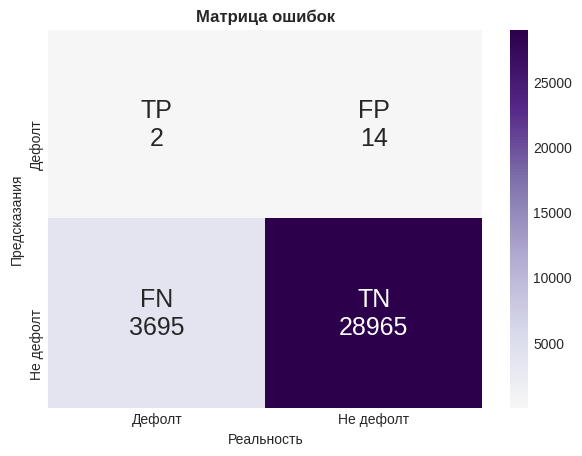

In [ ]:
mi_knn_11 .confusion_matrix_plot()

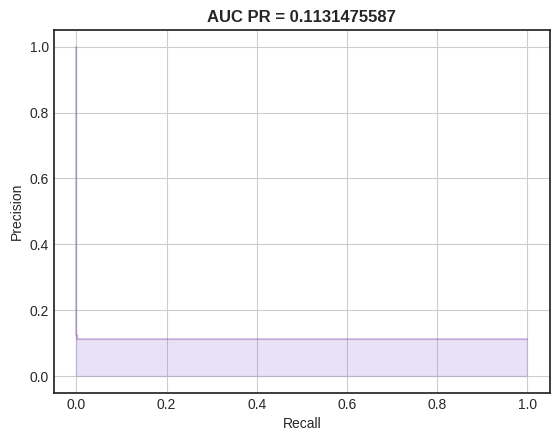

In [ ]:
mi_knn_11 .recall_precision_plot()

### Undersampling

In [ ]:
train_data = df_features_1.query('sample_cd == 1').drop(['sample_cd'], axis=1)
test_data = df_features_2.query('sample_cd == 0').drop(['sample_cd'], axis=1)

y_1 = train_data['default_flg']
X_1 = train_data.drop(['default_flg'], axis=1)

In [ ]:
rus = RandomUnderSampler(random_state=42)
X_us, y_us = rus.fit_resample(X_1, y_1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
(X_us.shape, y_us.shape)

((37496, 10), (37496,))

In [ ]:
print(len(y_us[y_us == 0]), len(y_us[y_us == 1]))

18748 18748


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_us, y_us, test_size=0.10, shuffle = True, random_state=42)

In [ ]:
knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_jobs=-1))])

In [ ]:
knn_params = {'knn__n_neighbors': range(1, 10)}

In [ ]:
knn_grid = GridSearchCV(knn_pipe, knn_params, cv=5, verbose=True, scoring='f1')

In [ ]:
knn_grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  2.3min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('knn',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=-1,
                                                             n_neighbors=5, p=2,
                                                             weights='uniform'))],
                                verbose=False),
             

In [ ]:
knn_grid.best_params_

{'knn__n_neighbors': 9}

In [ ]:
model_knn_us = KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=9, p=2,
                                            weights='uniform')

model_knn_us.fit(X_train, y_train)
mi_knn_us = ModelInspect(model_knn_us, X_test, y_test)

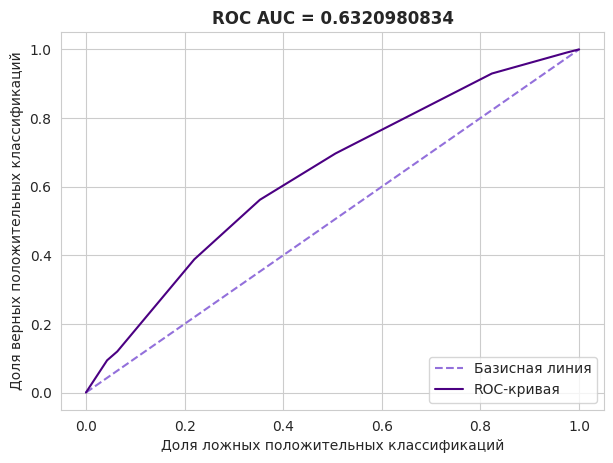

Коэффициент Джини:  0.26


In [ ]:
mi_knn_us.roc_curve_plot()

In [ ]:
mi_knn_us.get_metrics()

accuracy     0.604800
precision    0.610981
recall       0.561762
F1           0.585339
ROC_AUC      0.632098
dtype: float64

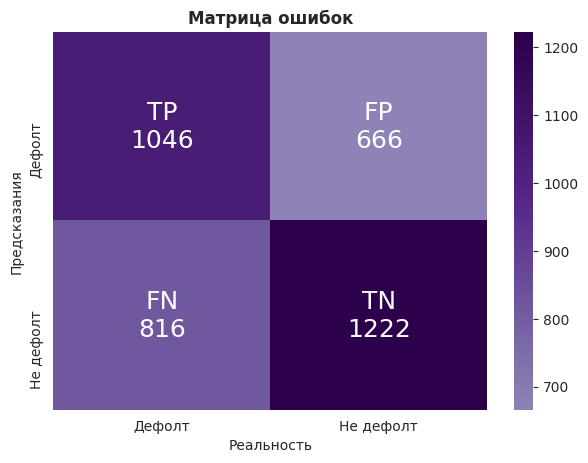

In [ ]:
mi_knn_us.confusion_matrix_plot()

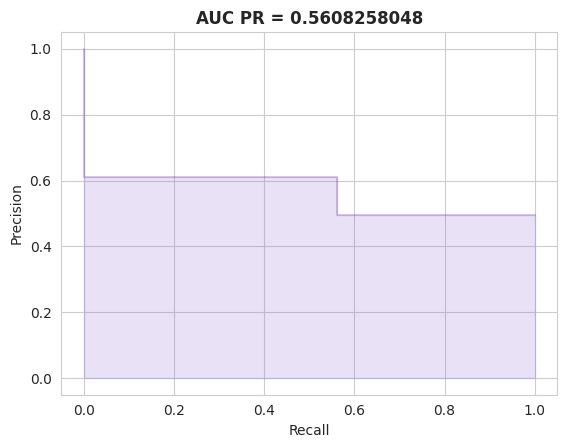

In [ ]:
mi_knn_us.recall_precision_plot()

## 2.2 К-ближайших соседей

In [ ]:
train_data = df_features_2.query('sample_cd == 1').drop(['sample_cd'], axis=1)
test_data = df_features_2.query('sample_cd == 0').drop(['sample_cd'], axis=1)

y_2 = train_data['default_flg']
X_2 = train_data.drop(['default_flg'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_2, y_2, test_size=0.2, random_state=42)

### Первая модель

In [ ]:
# первая модель на автомате
model_knn_2 = KNeighborsClassifier(n_neighbors=6)

model_knn_2.fit(X_train, y_train)

y_pred_prob_knn_2 = model_knn_2.predict_proba(X_test)[:,1]
y_pred_knn_2 = model_knn_2.predict(X_test)

In [ ]:
mi_knn_2 = ModelInspect(model_knn_2, X_test, y_test)

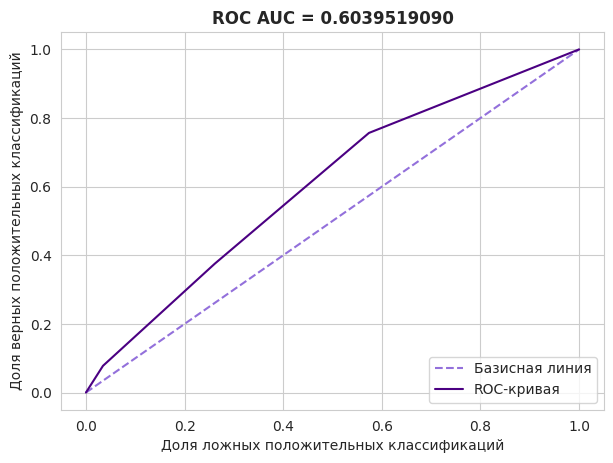

Коэффициент Джини:  0.21


In [ ]:
mi_knn_2.roc_curve_plot()

In [ ]:
mi_knn_2.get_metrics()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy     0.886859
precision    0.000000
recall       0.000000
F1           0.000000
ROC_AUC      0.603952
dtype: float64

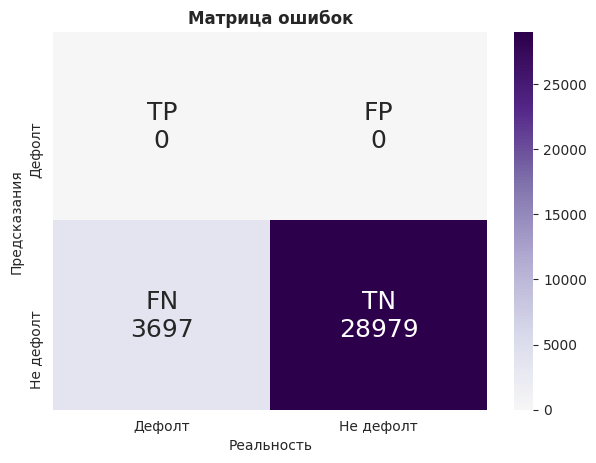

In [ ]:
mi_knn_2.confusion_matrix_plot()

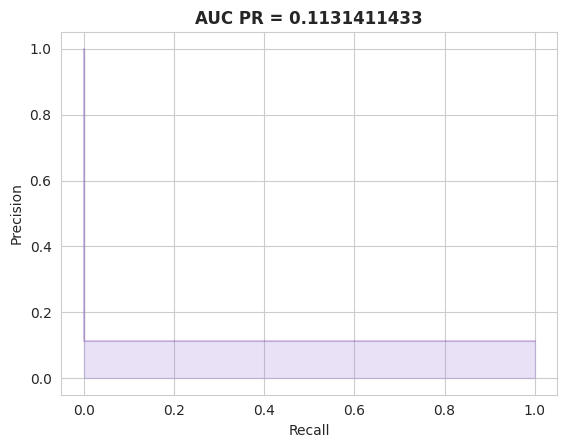

In [ ]:
mi_knn_2.recall_precision_plot()

### Подбор параметров 1

In [ ]:
knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_jobs=-1))])

In [ ]:
knn_params = {'knn__n_neighbors': range(1, 10)}

In [ ]:
knn_grid = GridSearchCV(knn_pipe, knn_params, cv=5, n_jobs=-1, verbose=True, scoring='f1')

In [ ]:
knn_grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 30.5min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('knn',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=-1,
                                                             n_neighbors=5, p=2,
                                                             weights='uniform'))],
                                verbose=False),
             

In [ ]:
knn_grid.best_params_, knn_grid.best_score_

({'knn__n_neighbors': 1}, 0.1752475120589744)

### Вторая модель

In [ ]:
# вторая модель с настроенными гиперпараметрами
model_knn_21 = KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=3, p=2,
                                            weights='distance')

model_knn_21.fit(X_train, y_train)

y_pred_prob_knn_21 = model_knn_21.predict_proba(X_test)[:,1]
y_pred_knn_21 = model_knn_21.predict(X_test)

In [ ]:
mi_knn_21 = ModelInspect(model_knn_21, X_test, y_test)

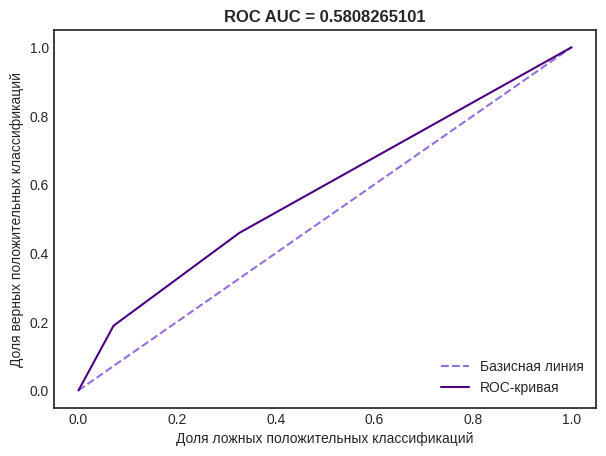

Коэффициент Джини:  0.16


In [ ]:
mi_knn_21.roc_curve_plot()

In [ ]:
metrics = pd.concat([mi_knn_2.get_metrics(), mi_knn_21.get_metrics()],axis = 1)
metrics.columns = ['best params 2', 'best params 21']
metrics

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


best params 2  best params 21
accuracy        0.886859        0.867487
precision       0.000000        0.184447
recall          0.000000        0.050041
F1              0.000000        0.078723
ROC_AUC         0.603952        0.577539

In [ ]:
mi_knn_21.get_metrics()

accuracy     0.845054
precision    0.252536
recall       0.188531
F1           0.215890
ROC_AUC      0.580827
dtype: float64

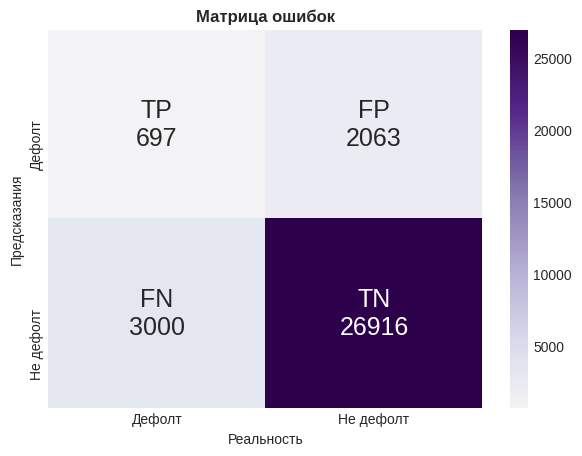

In [ ]:
mi_knn_21.confusion_matrix_plot()

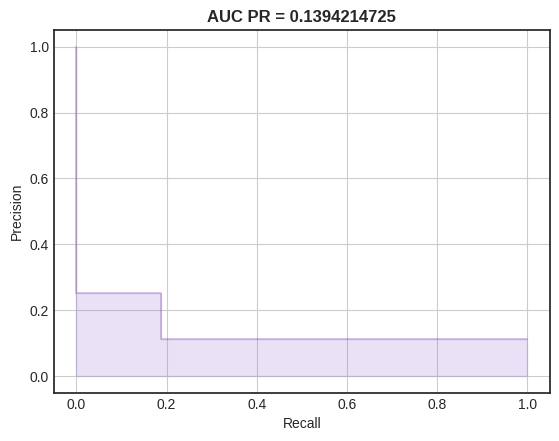

In [ ]:
mi_knn_21.recall_precision_plot()

### Undersampling

In [ ]:
train_data = df_features_2.query('sample_cd == 1').drop(['sample_cd'], axis=1)
test_data = df_features_2.query('sample_cd == 0').drop(['sample_cd'], axis=1)

y_2 = train_data['default_flg']
X_2 = train_data.drop(['default_flg'], axis=1)

In [ ]:
rus = RandomUnderSampler(random_state=42)
X_us, y_us = rus.fit_resample(X_2, y_2)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
(X_us.shape, y_us.shape)

((37496, 10), (37496,))

In [ ]:
print(len(y_us[y_us == 0]), len(y_us[y_us == 1]))

18748 18748


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_us, y_us, test_size=0.10, shuffle = True, random_state=42)

In [ ]:
knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_jobs=-1))])

In [ ]:
knn_params = {'knn__n_neighbors': range(1, 10)}

In [ ]:
knn_grid = GridSearchCV(knn_pipe, knn_params, cv=5, verbose=True, scoring='f1')

In [ ]:
knn_grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  2.4min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('knn',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=-1,
                                                             n_neighbors=5, p=2,
                                                             weights='uniform'))],
                                verbose=False),
             

In [ ]:
knn_grid.best_params_

{'knn__n_neighbors': 9}

In [ ]:
model_knn_us = KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=9, p=2,
                                            weights='uniform')

model_knn_us.fit(X_train, y_train)
mi_knn_us = ModelInspect(model_knn_us, X_test, y_test)

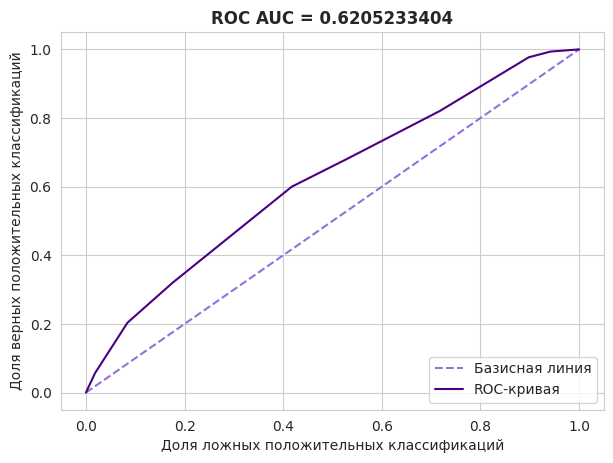

Коэффициент Джини:  0.24


In [ ]:
mi_knn_us.roc_curve_plot()

In [ ]:
mi_knn_us.get_metrics()

accuracy     0.591200
precision    0.586352
recall       0.599893
F1           0.593045
ROC_AUC      0.620523
dtype: float64

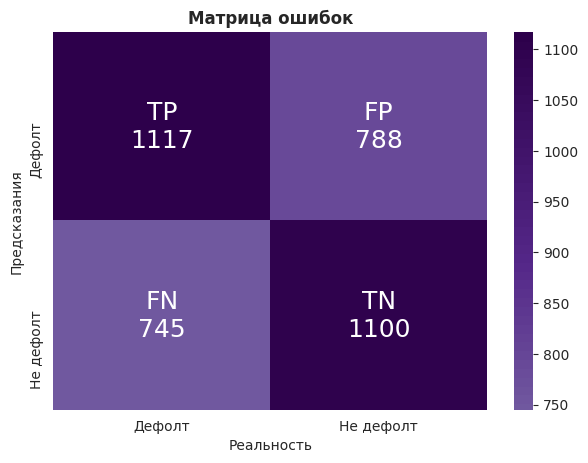

In [ ]:
mi_knn_us.confusion_matrix_plot()

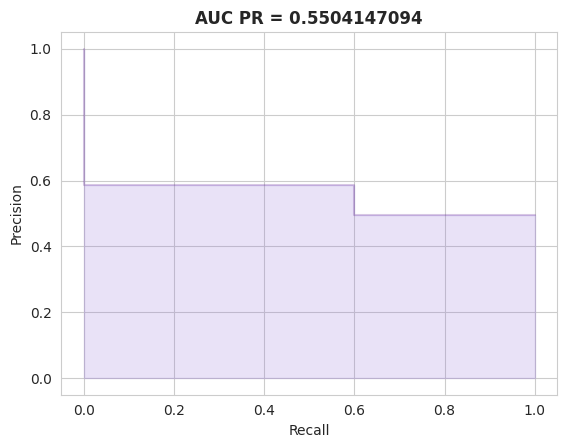

In [ ]:
mi_knn_us.recall_precision_plot()

## 3.1 Деревья решений

In [ ]:
train_data = df_features_1.query('sample_cd == 1').drop(['sample_cd'], axis=1)
test_data = df_features_1.query('sample_cd == 0').drop(['sample_cd'], axis=1)

y_1 = train_data['default_flg']
X_1 = train_data.drop(['default_flg'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=0.2, random_state=42)

### Первая модель

In [ ]:
model_tree_1 = DecisionTreeClassifier(max_depth=3, max_features=5, random_state=17)
model_tree_1.fit(X_train, y_train)

y_pred_prob_tree_1 = model_tree_1.predict_proba(X_test)[:,1]
y_pred_tree_1 = model_tree_1.predict(X_test)

In [ ]:
mi_tree_1 = ModelInspect(model_tree_1, X_test, y_test)

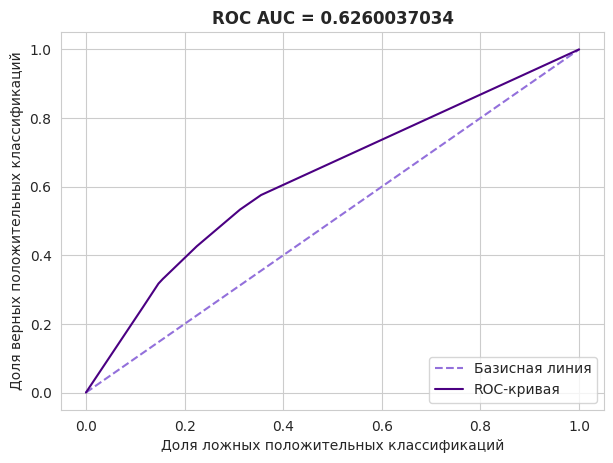

Коэффициент Джини:  0.25


In [ ]:
mi_tree_1.roc_curve_plot()

In [ ]:
mi_tree_1.get_metrics()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy     0.886859
precision    0.000000
recall       0.000000
F1           0.000000
ROC_AUC      0.626004
dtype: float64

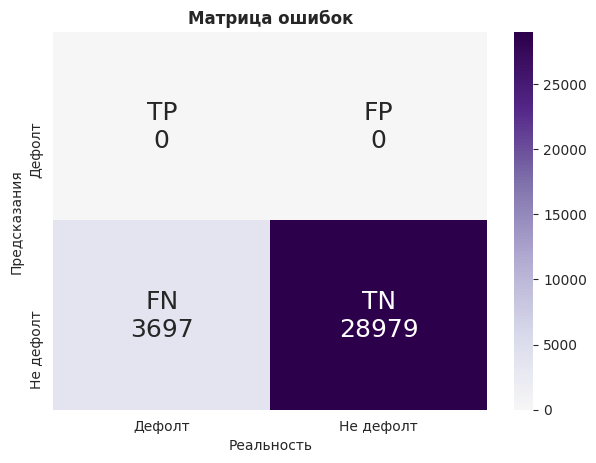

In [ ]:
mi_tree_1.confusion_matrix_plot()

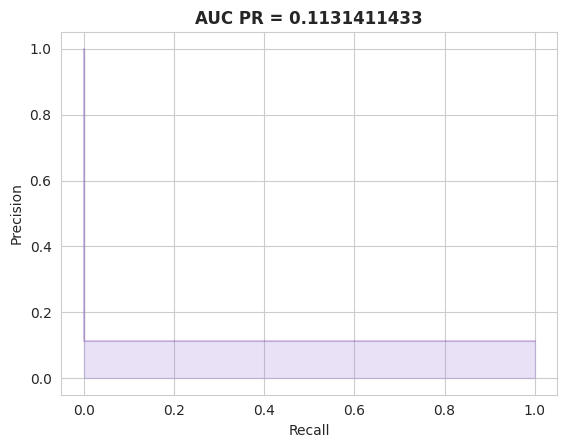

In [ ]:
mi_tree_1.recall_precision_plot()

### Подбор параметров №1

In [ ]:
clf = DecisionTreeClassifier()

In [ ]:
#tree_params = {'max_depth': range(1,11), 'max_features': range(4,19)}
tree_params = {'criterion': ['gini', 'entropy'], 'max_depth': range(1,20), 'min_samples_split': range(2,50, 2), 'min_samples_leaf': range(1,20)}

In [ ]:
#tree_grid = GridSearchCV(model_tree_1, tree_params, cv=5, n_jobs=-1, verbose=True, scoring='recall')
tree_grid = GridSearchCV(clf, tree_params, cv=5, n_jobs=-1)

In [ ]:
tree_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                     

In [ ]:
tree_grid.best_params_

{'criterion': 'gini',
 'max_depth': 1,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [ ]:
best_clf = grid_search_cv_clf.best_estimator_

### Вторая модель

In [ ]:
train_data = df_features_1.query('sample_cd == 1').drop(['sample_cd'], axis=1)
test_data = df_features_1.query('sample_cd == 0').drop(['sample_cd'], axis=1)

y_1 = train_data['default_flg']
X_1 = train_data.drop(['default_flg'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=0.2, random_state=42)

In [ ]:
model_tree_11 = DecisionTreeClassifier(criterion='gini', max_depth=2, min_samples_leaf=1, min_samples_split=2)
model_tree_11.fit(X_train, y_train)

y_pred_prob_tree_11 = model_tree_11.predict_proba(X_test)[:,1]
y_pred_tree_11 = model_tree_11.predict(X_test)

In [ ]:
mi_tree_11 = ModelInspect(model_tree_11, X_test, y_test)

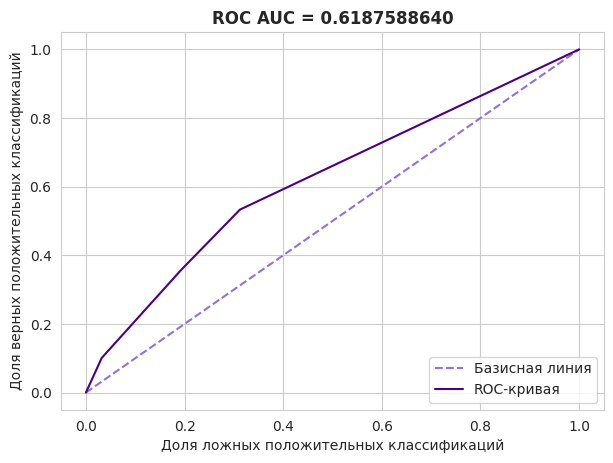

Коэффициент Джини:  0.24


In [ ]:
mi_tree_11.roc_curve_plot()

In [ ]:
metrics = pd.concat([mi_tree_1.get_metrics(), mi_tree_11.get_metrics()],axis = 1)
metrics.columns = ['best params 1', 'best params 11']
metrics

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


best params 1  best params 11
accuracy        0.886859        0.886859
precision       0.000000        0.000000
recall          0.000000        0.000000
F1              0.000000        0.000000
ROC_AUC         0.626004        0.618759

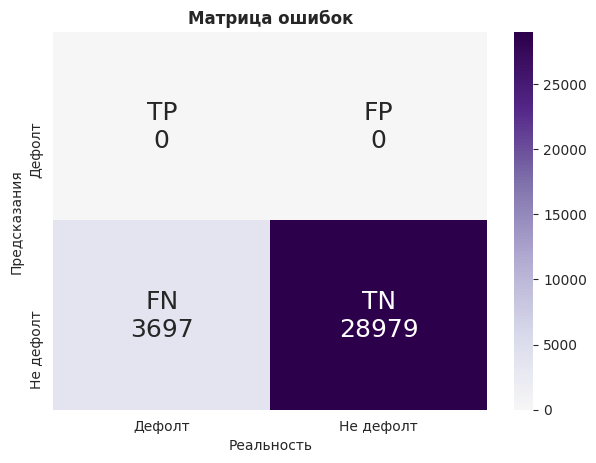

In [ ]:
mi_tree_11.confusion_matrix_plot()

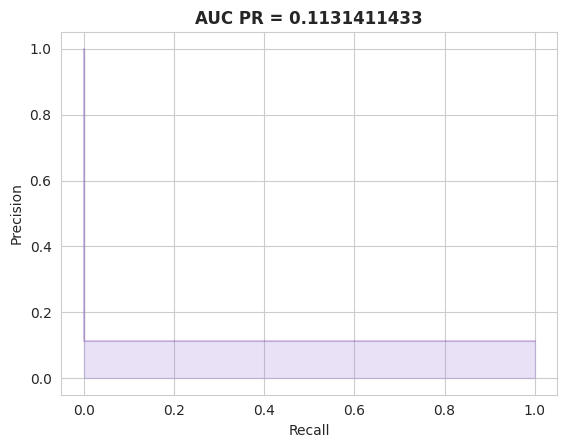

In [ ]:
mi_tree_11.recall_precision_plot()

### Undersampling

In [ ]:
train_data = df_features_1.query('sample_cd == 1').drop(['sample_cd'], axis=1)
test_data = df_features_1.query('sample_cd == 0').drop(['sample_cd'], axis=1)

y_1 = train_data['default_flg']
X_1 = train_data.drop(['default_flg'], axis=1)

In [ ]:
rus = RandomUnderSampler(random_state=42)
X_us, y_us = rus.fit_resample(X_1, y_1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
(X_us.shape, y_us.shape)

((37496, 10), (37496,))

In [ ]:
print(len(y_us[y_us == 0]), len(y_us[y_us == 1]))

18748 18748


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_us, y_us, test_size=0.10, shuffle = True, random_state=42)

In [ ]:
clf = DecisionTreeClassifier()

In [ ]:
tree_params = {'criterion': ['gini', 'entropy'], 'max_depth': range(1,20), 'max_features': range(4,11)}

In [ ]:
tree_grid = GridSearchCV(clf, tree_params, cv=5, n_jobs=-1, scoring='f1')

In [ ]:
tree_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                     

In [ ]:
tree_grid.best_params_

{'criterion': 'gini', 'max_depth': 9, 'max_features': 4}

In [ ]:
model_tree_us = DecisionTreeClassifier(criterion='gini', max_depth=9, max_features=4)
model_tree_us.fit(X_train, y_train)

mi_tree_us = ModelInspect(model_tree_us, X_test, y_test)

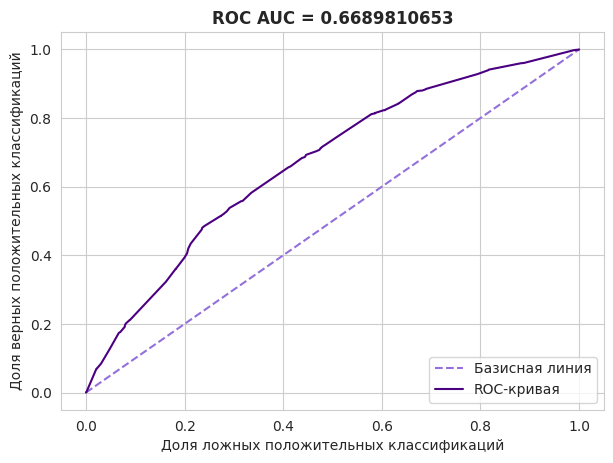

Коэффициент Джини:  0.34


In [ ]:
mi_tree_us.roc_curve_plot()

In [ ]:
mi_tree_us.get_metrics()

accuracy     0.622400
precision    0.606292
recall       0.683136
F1           0.642424
ROC_AUC      0.668981
dtype: float64

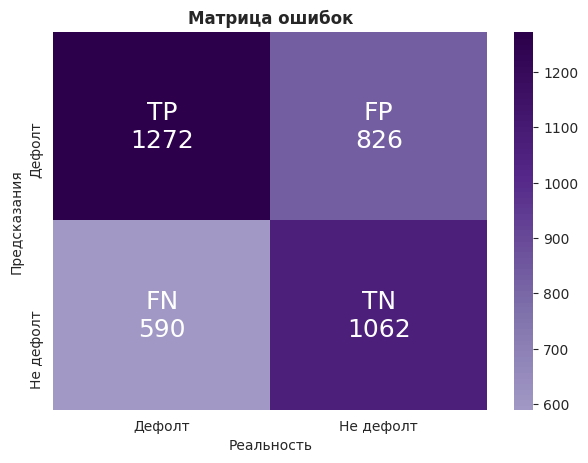

In [ ]:
mi_tree_us.confusion_matrix_plot()

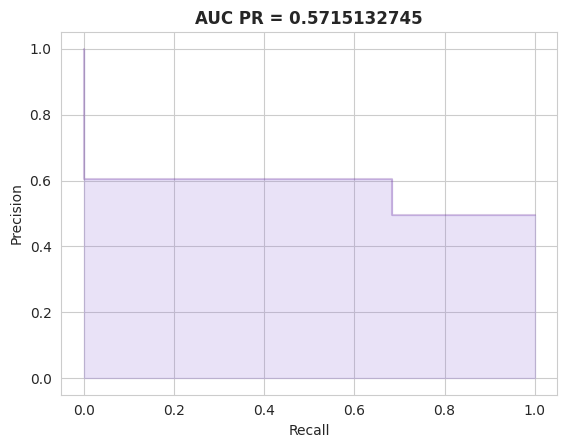

In [ ]:
mi_tree_us.recall_precision_plot()

## 3.2 Деревья решений

In [ ]:
train_data = df_features_2.query('sample_cd == 1').drop(['sample_cd'], axis=1)
test_data = df_features_2.query('sample_cd == 0').drop(['sample_cd'], axis=1)

y_2 = train_data['default_flg']
X_2 = train_data.drop(['default_flg'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_2, y_2, test_size=0.2, random_state=42)

### Первая модель

In [ ]:
model_tree_2 = DecisionTreeClassifier(criterion='gini', max_depth=2, max_features=3)
model_tree_2.fit(X_train, y_train)

y_pred_prob_tree_2 = model_tree_2.predict_proba(X_test)[:,1]
y_pred_tree_2 = model_tree_2.predict(X_test)

In [ ]:
mi_tree_2 = ModelInspect(model_tree_2, X_test, y_test)

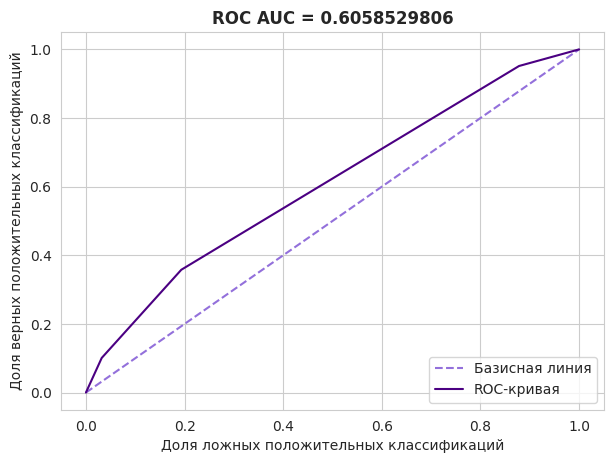

Коэффициент Джини:  0.21


In [ ]:
mi_tree_2.roc_curve_plot()

In [ ]:
mi_tree_2.get_metrics()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy     0.886859
precision    0.000000
recall       0.000000
F1           0.000000
ROC_AUC      0.605853
dtype: float64

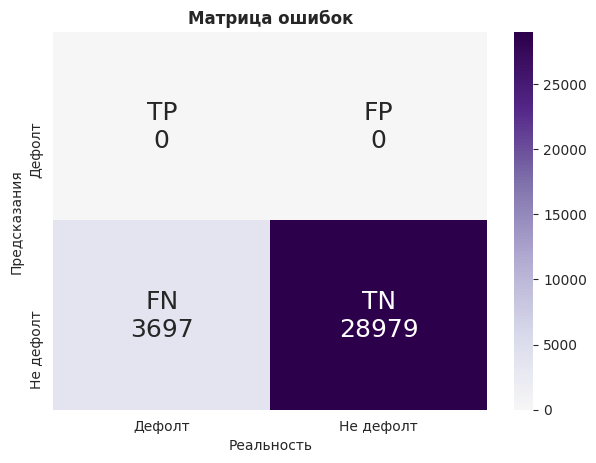

In [ ]:
mi_tree_2.confusion_matrix_plot()

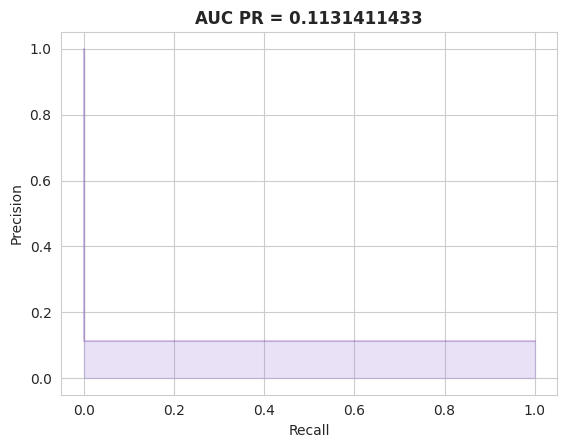

In [ ]:
mi_tree_2.recall_precision_plot()

### Подбор параметров №1

In [ ]:
clf = DecisionTreeClassifier()

In [ ]:
#tree_params = {'max_depth': range(1,11), 'max_features': range(4,19)}
tree_params = {'criterion': ['gini', 'entropy'], 'max_depth': range(1,20), 'min_samples_split': range(2,50, 2), 'min_samples_leaf': range(1,20)}

In [ ]:
#tree_grid = GridSearchCV(model_tree_1, tree_params, cv=5, n_jobs=-1, verbose=True, scoring='recall')
tree_grid = GridSearchCV(clf, tree_params, cv=5, n_jobs=-1)

In [ ]:
tree_grid.fit(X_train, y_train)

KeyboardInterrupt: ignored

In [ ]:
tree_grid.best_params_

In [ ]:
best_clf = grid_search_cv_clf.best_estimator_

### Вторая модель

In [ ]:
model_tree_21 = DecisionTreeClassifier(criterion='gini', max_depth=7, min_samples_leaf=3, min_samples_split=3)
model_tree_21.fit(X_train, y_train)

y_pred_prob_tree_21 = model_tree_21.predict_proba(X_test)[:,1]
y_pred_tree_21 = model_tree_21.predict(X_test)

In [ ]:
mi_tree_21 = ModelInspect(model_tree_21, X_test, y_test)

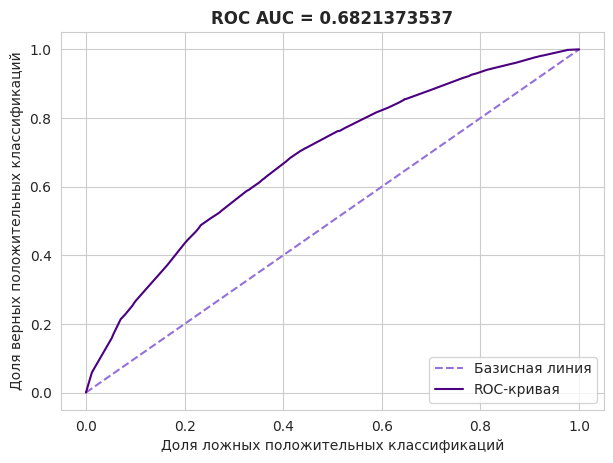

Коэффициент Джини:  0.36


In [ ]:
mi_tree_21.roc_curve_plot()

In [ ]:
metrics = pd.concat([mi_tree_2.get_metrics(), mi_tree_21.get_metrics()],axis = 1)
metrics.columns = ['best params 2', 'best params 21']
metrics

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


best params 2  best params 21
accuracy        0.886859        0.886859
precision       0.000000        0.000000
recall          0.000000        0.000000
F1              0.000000        0.000000
ROC_AUC         0.605853        0.682137

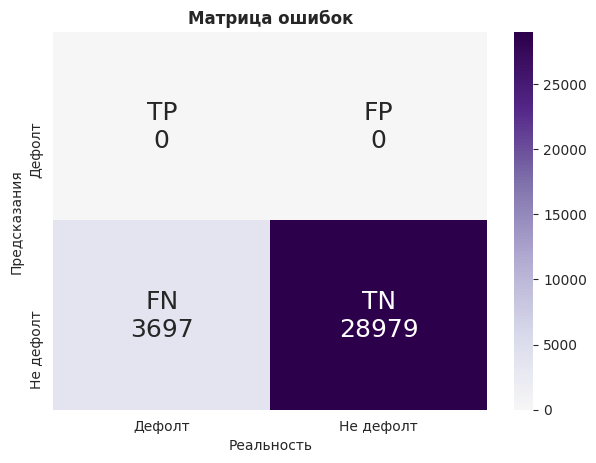

In [ ]:
mi_tree_21.confusion_matrix_plot()

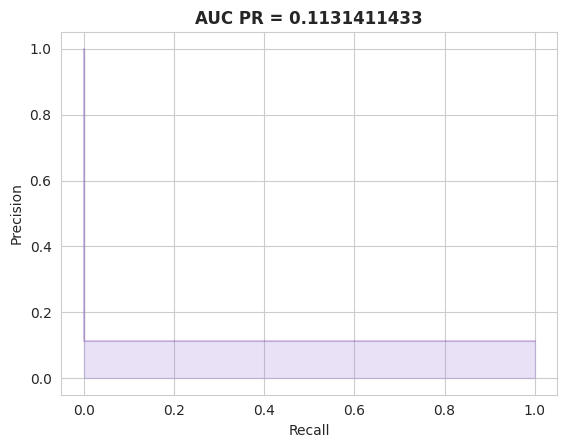

In [ ]:
mi_tree_21.recall_precision_plot()

### Undersampling

In [ ]:
train_data = df_features_2.query('sample_cd == 1').drop(['sample_cd'], axis=1)
test_data = df_features_2.query('sample_cd == 0').drop(['sample_cd'], axis=1)

y_2 = train_data['default_flg']
X_2 = train_data.drop(['default_flg'], axis=1)

In [ ]:
rus = RandomUnderSampler(random_state=42)
X_us, y_us = rus.fit_resample(X_2, y_2)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
(X_us.shape, y_us.shape)

((37496, 10), (37496,))

In [ ]:
print(len(y_us[y_us == 0]), len(y_us[y_us == 1]))

18748 18748


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_us, y_us, test_size=0.10, shuffle = True, random_state=42)

In [ ]:
clf = DecisionTreeClassifier()

In [ ]:
tree_params = {'criterion': ['gini', 'entropy'], 'max_depth': range(1,20), 'max_features': range(4,11)}

In [ ]:
tree_grid = GridSearchCV(clf, tree_params, cv=5, n_jobs=-1, scoring='f1')

In [ ]:
tree_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                     

In [ ]:
tree_grid.best_params_

{'criterion': 'entropy', 'max_depth': 8, 'max_features': 7}

In [ ]:
model_tree_us = DecisionTreeClassifier(criterion='entropy', max_depth=8, max_features=7)
model_tree_us.fit(X_train, y_train)

mi_tree_us = ModelInspect(model_tree_us, X_test, y_test)

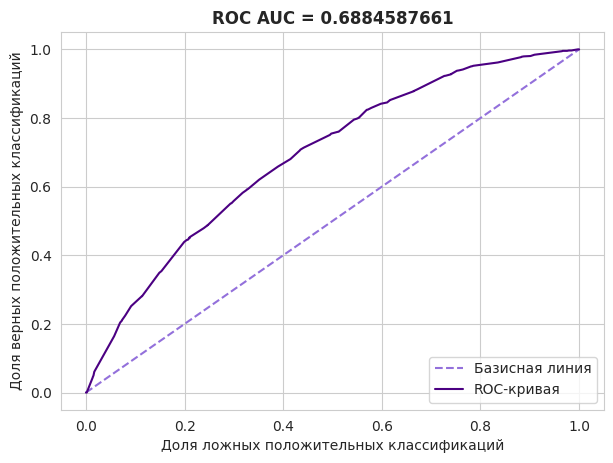

Коэффициент Джини:  0.38


In [ ]:
mi_tree_us.roc_curve_plot()

In [ ]:
mi_tree_us.get_metrics()

accuracy     0.635467
precision    0.616034
recall       0.705693
F1           0.657822
ROC_AUC      0.688459
dtype: float64

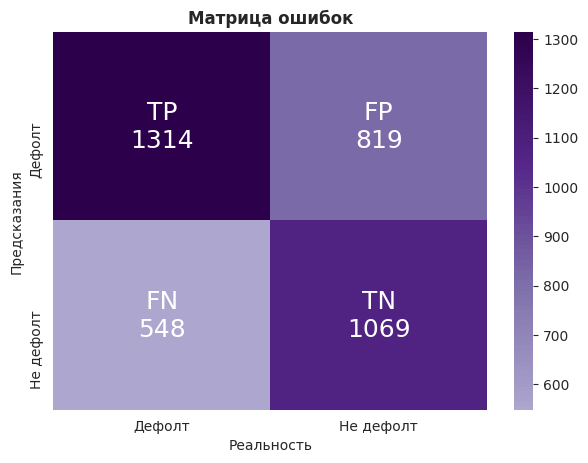

In [ ]:
mi_tree_us.confusion_matrix_plot()

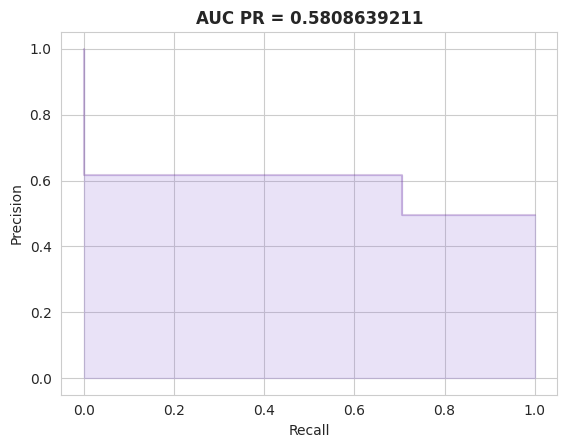

In [ ]:
mi_tree_us.recall_precision_plot()

## 4.1 Случайный лес

In [ ]:
train_data = df_features_1.query('sample_cd == 1').drop(['sample_cd'], axis=1)
test_data = df_features_1.query('sample_cd == 0').drop(['sample_cd'], axis=1)

y_1 = train_data['default_flg']
X_1 = train_data.drop(['default_flg'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=0.2, random_state=42)

### Первая модель

In [ ]:
model_rndForest_1 = RandomForestClassifier(n_estimators=3, max_depth=2, max_features=3)
model_rndForest_1 = model_rndForest_1.fit(X_train, y_train) # оценим параметры модели

y_pred_rndForest_1 = model_rndForest_1.predict(X_test)  # прогноз отношения к классу 0 или 1
y_pred_rndForest_proba_1 = model_rndForest_1.predict_proba(X_test)[:, 1]  # прогнозные вероятности отношения к классу 0 

In [ ]:
mi_rndForest_1 = ModelInspect(model_rndForest_1, X_test, y_test)

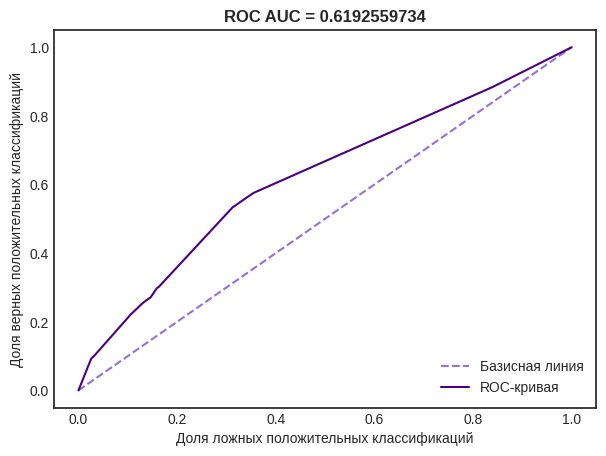

Коэффициент Джини:  0.24


In [ ]:
mi_rndForest_1.roc_curve_plot()

In [ ]:
mi_rndForest_1.get_metrics()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy     0.886859
precision    0.000000
recall       0.000000
F1           0.000000
ROC_AUC      0.619256
dtype: float64

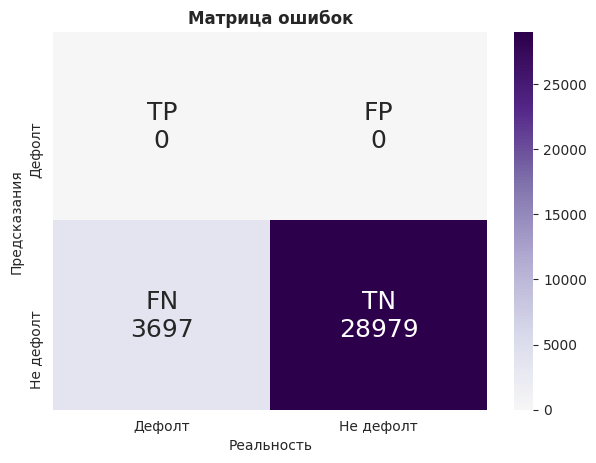

In [ ]:
mi_rndForest_1.confusion_matrix_plot()

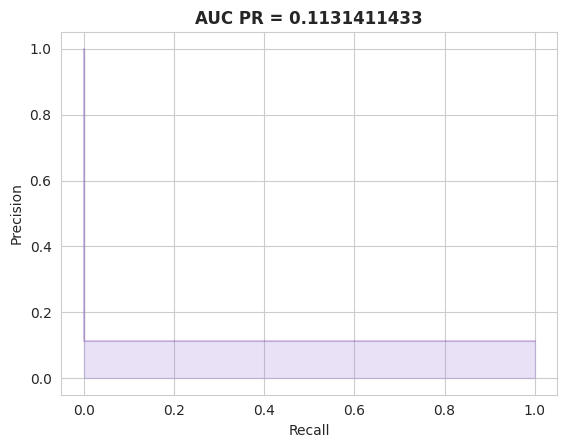

In [ ]:
mi_rndForest_1.recall_precision_plot()

### Подбор параметров №1

In [ ]:
random_search = {'criterion': ['entropy', 'gini'],
               'max_depth': list(np.linspace(10, 1200, 10, dtype = int)) + [None],
               'max_features': ['auto', 'sqrt','log2', None],
               'min_samples_leaf': [4, 6, 8, 12],
               'min_samples_split': [5, 7, 10, 14],
               'n_estimators': list(np.linspace(151, 1200, 10, dtype = int))}

clf = RandomForestClassifier()
model = RandomizedSearchCV(estimator = clf, param_distributions = random_search, n_iter = 80, 
                               cv = 4, verbose= 5, random_state= 101, n_jobs = -1)
model.fit(X_train, y_train)

Fitting 4 folds for each of 80 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 21.1min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 54.2min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed: 107.4min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed: 125.8min finished


RandomizedSearchCV(cv=4, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
model.best_params_, model.best_score_

({'criterion': 'gini',
  'max_depth': 1200,
  'max_features': 'log2',
  'min_samples_leaf': 4,
  'min_samples_split': 14,
  'n_estimators': 267},
 0.8848457955847226)

### Вторая модель

In [ ]:
train_data = df_features_1.query('sample_cd == 1').drop(['sample_cd'], axis=1)
test_data = df_features_1.query('sample_cd == 0').drop(['sample_cd'], axis=1)

y_1 = train_data['default_flg']
X_1 = train_data.drop(['default_flg'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=0.2, random_state=42)

In [ ]:
model_rndForest_11 = RandomForestClassifier(n_estimators=267,criterion='gini', max_depth=1200,max_features='log2',
                                            min_samples_leaf=4, min_samples_split=14, class_weight='balanced')
model_rndForest_11 = model_rndForest_11.fit(X_train, y_train) # оценим параметры модели

y_pred_rndForest_11 = model_rndForest_11.predict(X_test)  # прогноз отношения к классу 0 или 1
y_pred_rndForest_proba_11 = model_rndForest_11.predict_proba(X_test)[:, 1]  # прогнозные вероятности отношения к классу 0 

In [ ]:
mi_rndForest_11 = ModelInspect(model_rndForest_11, X_test, y_test)

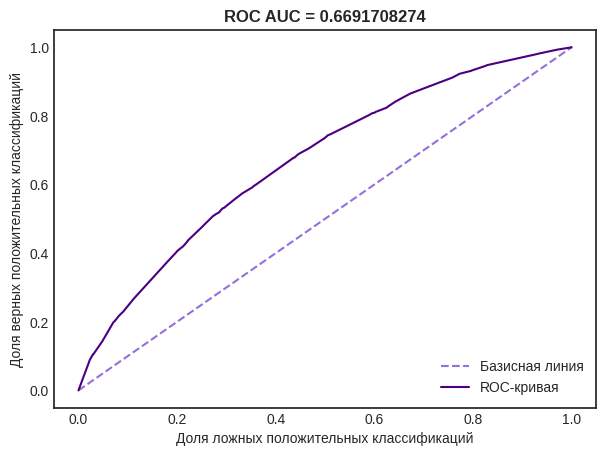

Коэффициент Джини:  0.34


In [ ]:
mi_rndForest_11.roc_curve_plot()

In [ ]:
metrics = pd.concat([mi_rndForest_1.get_metrics(), mi_rndForest_11.get_metrics()],axis = 1)
metrics.columns = ['best params 1', 'best params 11']
metrics

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


best params 1  best params 11
accuracy        0.886859        0.633492
precision       0.000000        0.174900
recall          0.000000        0.602380
F1              0.000000        0.271089
ROC_AUC         0.619256        0.669171

In [ ]:
mi_rndForest_11.get_metrics()

accuracy     0.633492
precision    0.174900
recall       0.602380
F1           0.271089
ROC_AUC      0.669171
dtype: float64

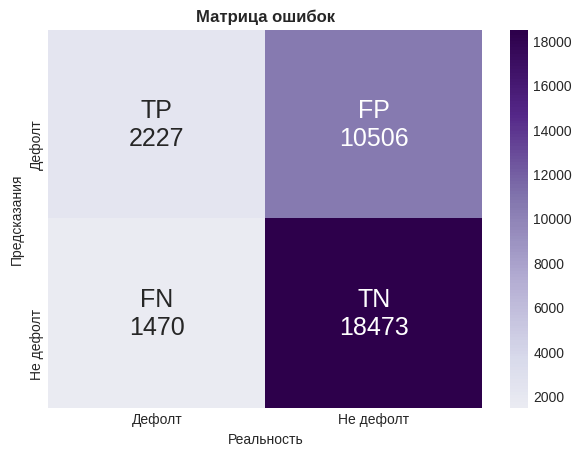

In [ ]:
mi_rndForest_11.confusion_matrix_plot()

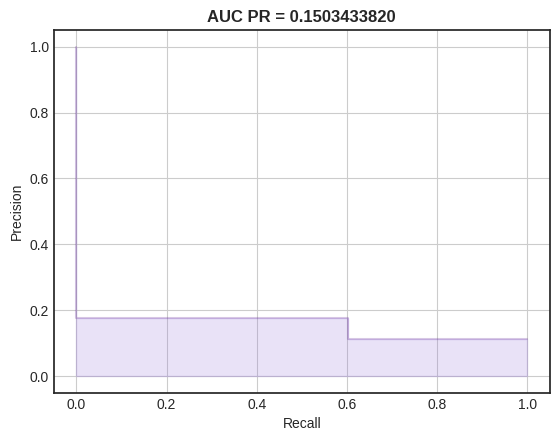

In [ ]:
mi_rndForest_11.recall_precision_plot()

### Undersampling

In [ ]:
train_data = df_features_1.query('sample_cd == 1').drop(['sample_cd'], axis=1)
test_data = df_features_1.query('sample_cd == 0').drop(['sample_cd'], axis=1)

y_1 = train_data['default_flg']
X_1 = train_data.drop(['default_flg'], axis=1)

In [ ]:
rus = RandomUnderSampler(random_state=42)
X_us, y_us = rus.fit_resample(X_1, y_1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
(X_us.shape, y_us.shape)

((37496, 10), (37496,))

In [ ]:
print(len(y_us[y_us == 0]), len(y_us[y_us == 1]))

18748 18748


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_us, y_us, test_size=0.10, shuffle = True, random_state=42)

In [ ]:
clf = RandomForestClassifier()

In [ ]:
rndForest_params = { 'max_features': range(4,10), 'n_estimators': [10, 20, 30, 40], 'max_depth': range(1,11)}

In [ ]:
rndForest_grid = GridSearchCV(clf, rndForest_params, cv=5, n_jobs=-1, scoring='f1')

In [ ]:
rndForest_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [ ]:
rndForest_grid.best_params_

{'max_depth': 9, 'max_features': 5, 'n_estimators': 30}

In [ ]:
model_rndForest_us = RandomForestClassifier(n_estimators=30, max_depth=9, max_features=5)
model_rndForest_us.fit(X_train, y_train)

mi_rndForest_us = ModelInspect(model_rndForest_us, X_test, y_test)

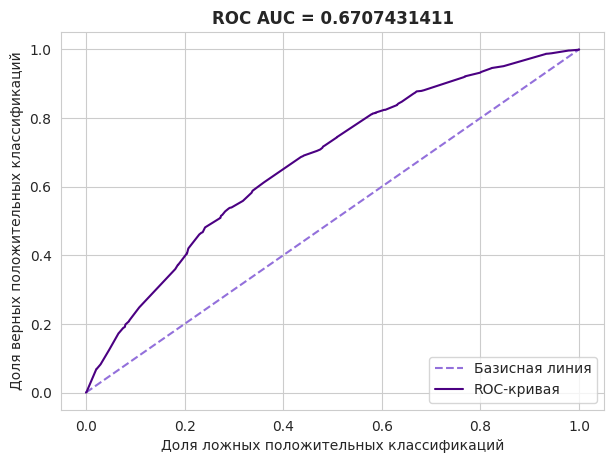

Коэффициент Джини:  0.34


In [ ]:
mi_rndForest_us.roc_curve_plot()

In [ ]:
mi_rndForest_us.get_metrics()

accuracy     0.624000
precision    0.606604
recall       0.690655
F1           0.645907
ROC_AUC      0.670743
dtype: float64

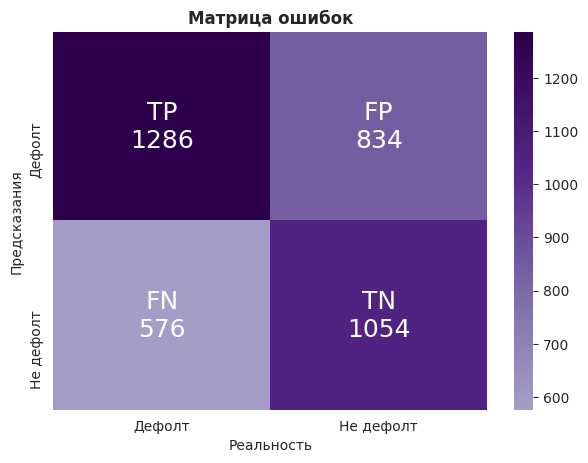

In [ ]:
mi_rndForest_us.confusion_matrix_plot()

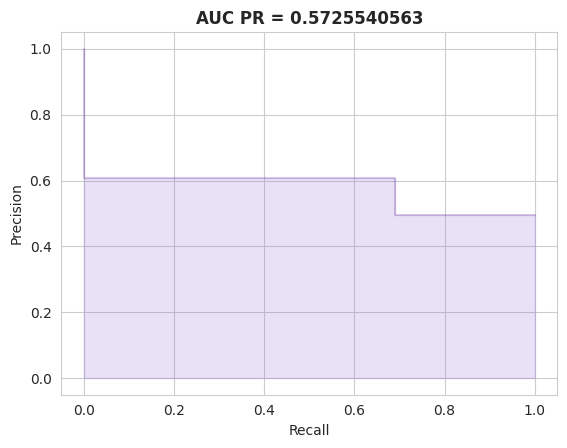

In [ ]:
mi_rndForest_us.recall_precision_plot()

## 4.2 Случайный лес

In [ ]:
train_data = df_features_2.query('sample_cd == 1').drop(['sample_cd'], axis=1)
test_data = df_features_2.query('sample_cd == 0').drop(['sample_cd'], axis=1)

y_2 = train_data['default_flg']
X_2 = train_data.drop(['default_flg'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_2, y_2, test_size=0.2, random_state=42)

### Первая модель

In [ ]:
model_rndForest_2 = RandomForestClassifier(random_state=42, max_depth=3, max_features=5)
model_rndForest_2.fit(X_train, y_train) # оценим параметры модели

y_pred_rndForest_2 = model_rndForest_2.predict(X_test)  # прогноз отношения к классу 0 или 1
y_pred_rndForest_proba_2 = model_rndForest_2.predict_proba(X_test)[:, 1]  # прогнозные вероятности отношения к классу 0 

In [ ]:
mi_rndForest_2 = ModelInspect(model_rndForest_2, X_test, y_test)

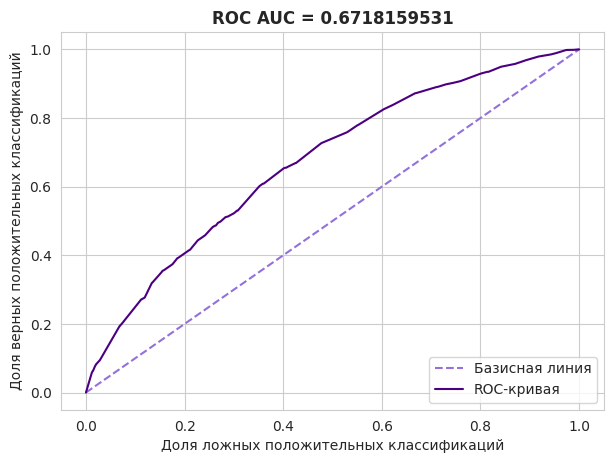

Коэффициент Джини:  0.34


In [ ]:
mi_rndForest_2.roc_curve_plot()

In [ ]:
mi_rndForest_2.get_metrics()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy     0.886859
precision    0.000000
recall       0.000000
F1           0.000000
ROC_AUC      0.671816
dtype: float64

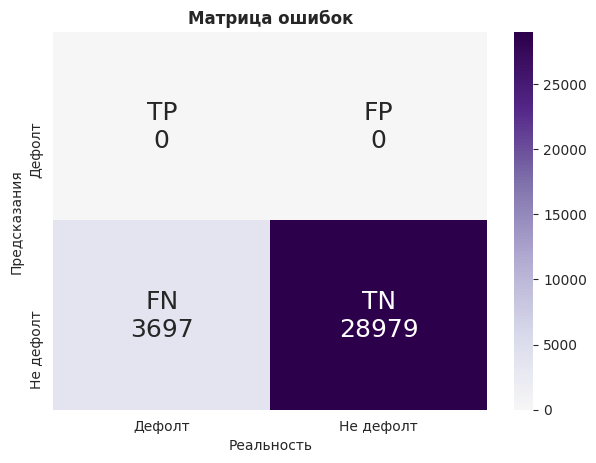

In [ ]:
mi_rndForest_2.confusion_matrix_plot()

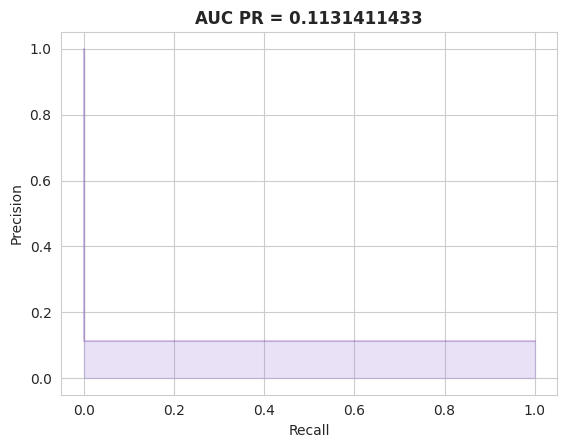

In [ ]:
mi_rndForest_2.recall_precision_plot()

### Подбор параметров №1

In [ ]:
random_search = {'n_estimators': [10, 20, 30], 'max_depth': [2,5,7,10]}

clf = RandomForestClassifier()
model = RandomizedSearchCV(estimator = clf, param_distributions = random_search, n_iter = 80, 
                               cv = 4, verbose= 5, random_state= 101, n_jobs = -1)
model.fit(X_train, y_train)

Fitting 4 folds for each of 12 candidates, totalling 48 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 12 is smaller than n_iter=80. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   26.8s finished


RandomizedSearchCV(cv=4, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
model.best_params_

{'max_depth': 2, 'n_estimators': 10}

### Вторая модель

In [ ]:
train_data = df_features_2.query('sample_cd == 1').drop(['sample_cd'], axis=1)
test_data = df_features_2.query('sample_cd == 0').drop(['sample_cd'], axis=1)

y_2 = train_data['default_flg']
X_2 = train_data.drop(['default_flg'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_2, y_2, test_size=0.2, random_state=42)

In [ ]:
model_rndForest_21 = RandomForestClassifier(criterion='gini', n_estimators=10, max_depth=2, class_weight='balanced')
model_rndForest_21 = model_rndForest_21.fit(X_train, y_train) # оценим параметры модели

y_pred_rndForest_21 = model_rndForest_21.predict(X_test)  # прогноз отношения к классу 0 или 1
y_pred_rndForest_proba_21 = model_rndForest_21.predict_proba(X_test)[:, 1]  # прогнозные вероятности отношения к классу 0 

In [ ]:
mi_rndForest_21 = ModelInspect(model_rndForest_21, X_test, y_test)

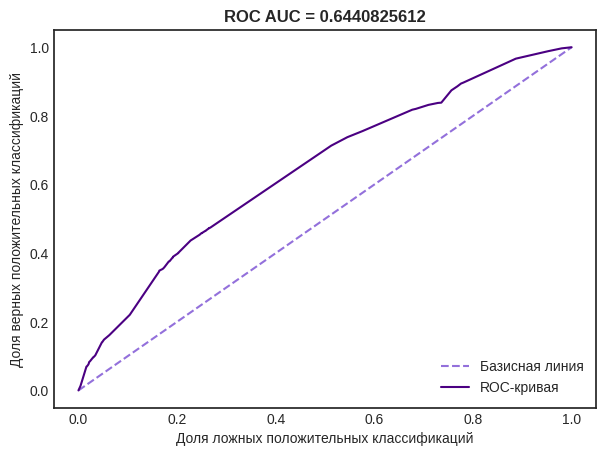

Коэффициент Джини:  0.29


In [ ]:
mi_rndForest_21.roc_curve_plot()

In [ ]:
metrics = pd.concat([mi_rndForest_2.get_metrics(), mi_rndForest_21.get_metrics()],axis = 1)
metrics.columns = ['best params 2', 'best params 21']
metrics

NameError: ignored

In [ ]:
mi_rndForest_21.get_metrics()

accuracy     0.703146
precision    0.184484
recall       0.474709
F1           0.265708
ROC_AUC      0.644083
dtype: float64

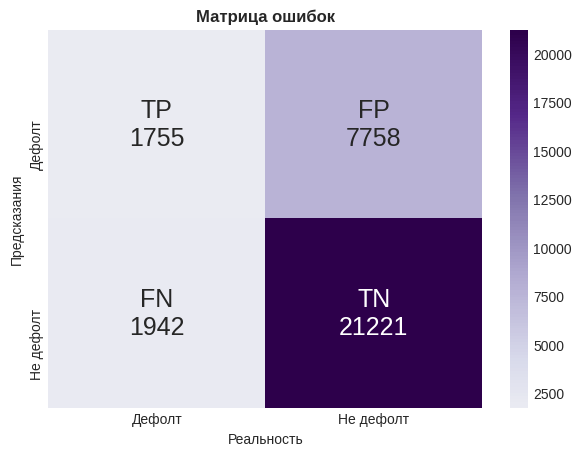

In [ ]:
mi_rndForest_21.confusion_matrix_plot()

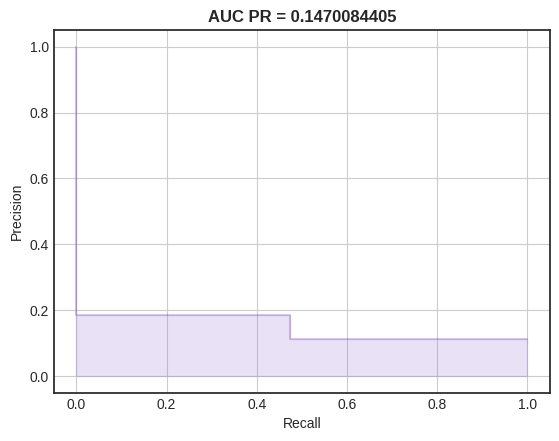

In [ ]:
mi_rndForest_21.recall_precision_plot()

### Undersampling

In [ ]:
train_data = df_features_2.query('sample_cd == 1').drop(['sample_cd'], axis=1)
test_data = df_features_2.query('sample_cd == 0').drop(['sample_cd'], axis=1)

y_2 = train_data['default_flg']
X_2 = train_data.drop(['default_flg'], axis=1)

In [ ]:
rus = RandomUnderSampler(random_state=42)
X_us, y_us = rus.fit_resample(X_2, y_2)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
(X_us.shape, y_us.shape)

((37496, 10), (37496,))

In [ ]:
print(len(y_us[y_us == 0]), len(y_us[y_us == 1]))

18748 18748


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_us, y_us, test_size=0.10, shuffle = True, random_state=42)

In [ ]:
clf = RandomForestClassifier()

In [ ]:
rndForest_params = { 'max_features': range(4,10), 'n_estimators': [10, 20, 30, 40], 'max_depth': range(1,11)}

In [ ]:
rndForest_grid = GridSearchCV(clf, rndForest_params, cv=5, n_jobs=-1, scoring='f1')

In [ ]:
rndForest_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [ ]:
rndForest_grid.best_params_

{'max_depth': 9, 'max_features': 4, 'n_estimators': 10}

In [ ]:
model_rndForest_us = RandomForestClassifier(n_estimators=10, max_depth=9, max_features=4)
model_rndForest_us.fit(X_train, y_train)

mi_rndForest_us = ModelInspect(model_rndForest_us, X_test, y_test)

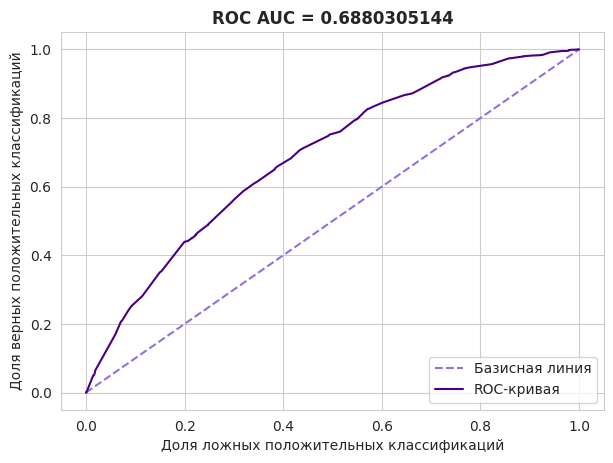

Коэффициент Джини:  0.38


In [ ]:
mi_rndForest_us.roc_curve_plot()

In [ ]:
mi_rndForest_us.get_metrics()

accuracy     0.633067
precision    0.618421
recall       0.681525
F1           0.648441
ROC_AUC      0.688031
dtype: float64

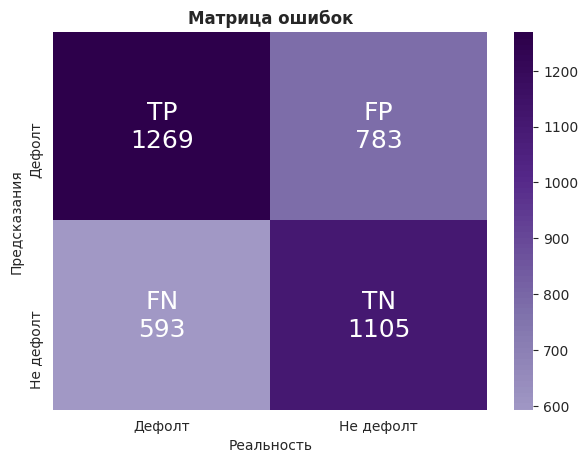

In [ ]:
mi_rndForest_us.confusion_matrix_plot()

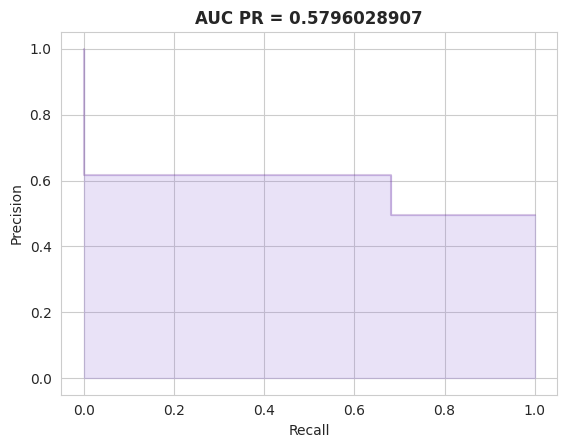

In [ ]:
mi_rndForest_us.recall_precision_plot()

## 5.1 SVM модель

In [ ]:
train_data = df_features_1.query('sample_cd == 1').drop(['sample_cd'], axis=1)
test_data = df_features_1.query('sample_cd == 0').drop(['sample_cd'], axis=1)

y_1 = train_data['default_flg']
X_1 = train_data.drop(['default_flg'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=0.2, random_state=42)

### Первая модель

In [ ]:
model_SVM_1 = SVC(kernel='rbf', C=100, gamma=0.1)
model_SVM_1.fit(X_train, y_train) # оценим параметры модели

y_pred_SVM_1 = model_SVM_1.predict(X_test)  # прогноз отношения к классу 0 или 1

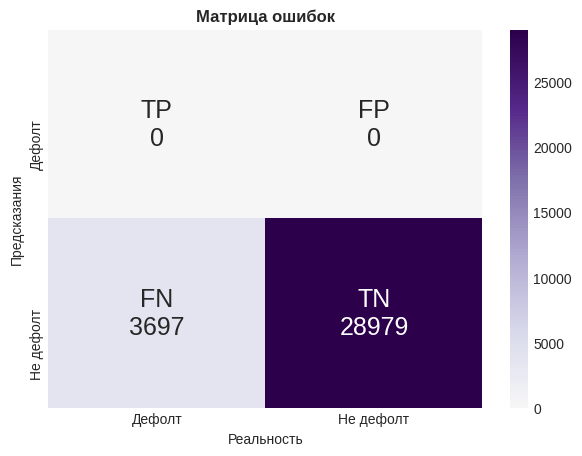

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_SVM_1).ravel()
cf_matrix = np.array([[tp,fp],[fn,tn]])
group_names = ['TP','FP','FN','TN']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(7,5))
sns.heatmap(cf_matrix, center=0, annot=labels, annot_kws={"size": 18}, fmt='', cmap= 'binary', cbar = True, \
            xticklabels = ['Дефолт','Не дефолт'], yticklabels= ['Дефолт','Не дефолт'])
plt.title('Матрица ошибок', fontsize=12,  weight='bold')
plt.xlabel('Реальность', fontsize=10)
plt.ylabel('Предсказания', fontsize=10)
plt.show()

In [ ]:
result = pd.Series({
            'accuracy' : accuracy_score(y_test, y_pred_SVM_1),
            'precision' : precision_score(y_test, y_pred_SVM_1),
            'recall' : recall_score(y_test, y_pred_SVM_1),
            'F1' : f1_score(y_test, y_pred_SVM_1),
            })
result

accuracy     0.886767
precision    0.000000
recall       0.000000
F1           0.000000
dtype: float64

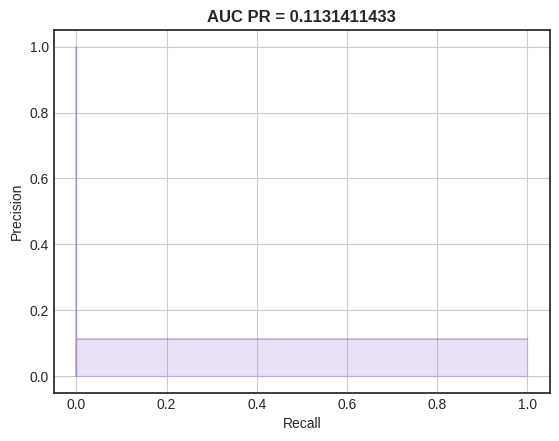

In [ ]:
precisions, recalls, _ = precision_recall_curve(y_test, y_pred_SVM_1)
ap = average_precision_score(y_test, y_pred_SVM_1)        
        
plt.figure()
        
plt.step(recalls, precisions, color='grey', alpha=0.2, where='post')
plt.fill_between(recalls, precisions, step='post', alpha=0.2, color='lightgray')
plt.xlabel('Recall', fontsize=10);
plt.ylabel('Precision', fontsize=10);
plt.title('AUC PR = %0.10f' % ap, fontsize=12,  weight='bold')
plt.grid(True)

plt.show()

In [ ]:
y_pred_SVM_proba_1 = model_SVM_1.predict_proba(X_test)[:, 1]  # прогнозные вероятности отношения к классу 0 

In [ ]:
mi_SVM_1 = ModelInspect(model_SVM_1, X_test, y_test)

AttributeError: ignored

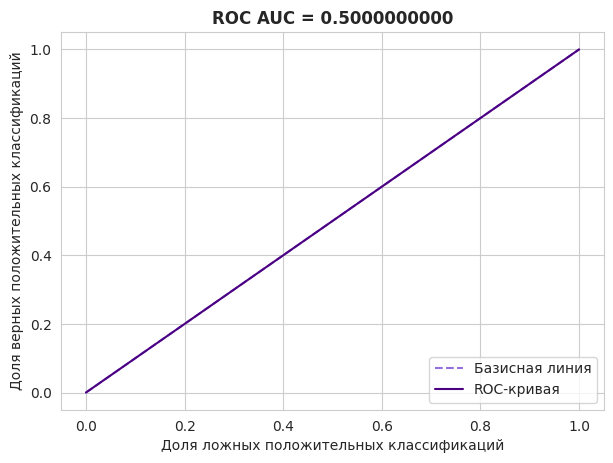

Коэффициент Джини:  0.0


In [ ]:
mi_SVM_1.roc_curve_plot()

In [ ]:
mi_SVM_1.get_metrics()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy     0.886859
precision    0.000000
recall       0.000000
F1           0.000000
ROC_AUC      0.500000
dtype: float64

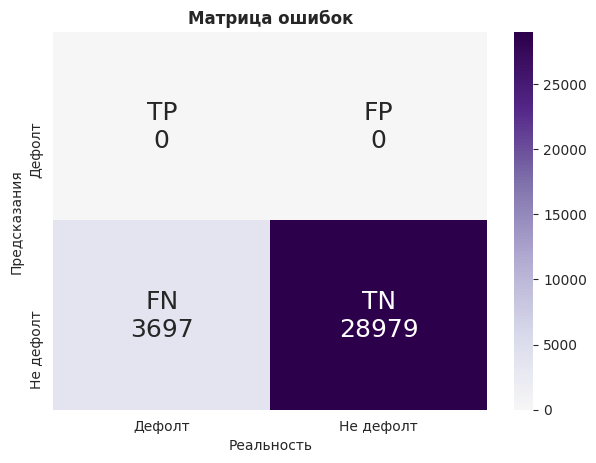

In [ ]:
mi_SVM_1.confusion_matrix_plot()

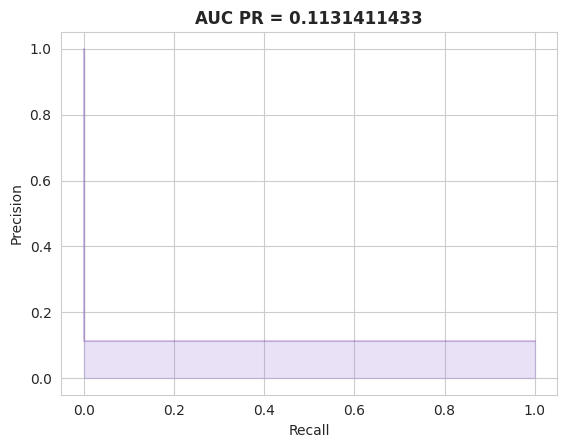

In [ ]:
mi_SVM_1.recall_precision_plot()

### Подбор параметров №1

In [ ]:
C = [0.1,1,100,1000]
kernel = ['rbf']
gamma = [100, 1, 0.1, 0.01, 0.001]
param_grid = dict(C=C, kernel=kernel, gamma=gamma)

In [ ]:
svm = SVC()
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
grid_search = GridSearchCV(svm, param_grid, scoring="f1", n_jobs=-1, cv=kfold, verbose=1)
result = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 83.5min


KeyboardInterrupt: ignored

In [ ]:
result.best_params_

AttributeError: ignored

In [ ]:
grid.best_params_

### Вторая модель

In [ ]:
train_data = df_features_1.query('sample_cd == 1').drop(['sample_cd'], axis=1)
test_data = df_features_1.query('sample_cd == 0').drop(['sample_cd'], axis=1)

y_1 = train_data['default_flg']
X_1 = train_data.drop(['default_flg'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=0.2, random_state=42)

In [ ]:
model_SVM_11 = SVC(kernel='rbf', C=100, gamma=1, class_weight='balanced')
model_SVM_11.fit(X_train, y_train) # оценим параметры модели

y_pred_SVM_11 = model_SVM_11.predict(X_test)  # прогноз отношения к классу 0 или 1

AttributeError: ignored

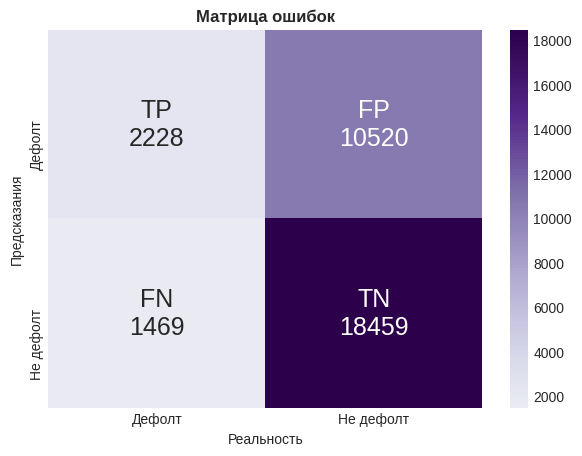

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_SVM_11).ravel()
cf_matrix = np.array([[tp,fp],[fn,tn]])
group_names = ['TP','FP','FN','TN']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(7,5))
sns.heatmap(cf_matrix, center=0, annot=labels, annot_kws={"size": 18}, fmt='', cmap= 'binary', cbar = True, \
            xticklabels = ['Дефолт','Не дефолт'], yticklabels= ['Дефолт','Не дефолт'])
plt.title('Матрица ошибок', fontsize=12,  weight='bold')
plt.xlabel('Реальность', fontsize=10)
plt.ylabel('Предсказания', fontsize=10)
plt.show()

In [ ]:
result = pd.Series({
            'accuracy' : accuracy_score(y_test, y_pred_SVM_11),
            'precision' : precision_score(y_test, y_pred_SVM_11),
            'recall' : recall_score(y_test, y_pred_SVM_11),
            'F1' : f1_score(y_test, y_pred_SVM_11),
            })
result

accuracy     0.633095
precision    0.174773
recall       0.602651
F1           0.270964
dtype: float64

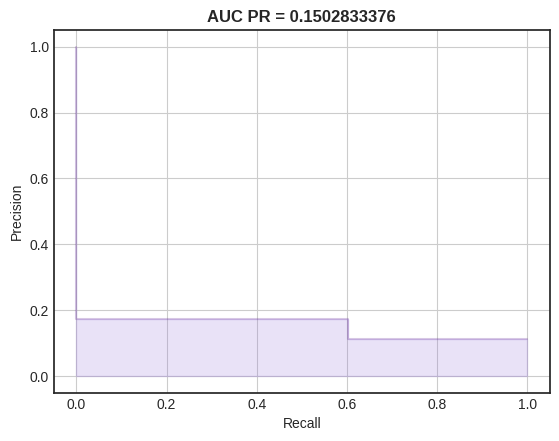

In [ ]:
precisions, recalls, _ = precision_recall_curve(y_test, y_pred_SVM_11)
ap = average_precision_score(y_test, y_pred_SVM_11)        
        
plt.figure()
        
plt.step(recalls, precisions, color='grey', alpha=0.2, where='post')
plt.fill_between(recalls, precisions, step='post', alpha=0.2, color='lightgray')
plt.xlabel('Recall', fontsize=10);
plt.ylabel('Precision', fontsize=10);
plt.title('AUC PR = %0.10f' % ap, fontsize=12,  weight='bold')
plt.grid(True)

plt.show()

In [ ]:
mi_SVM_11 = ModelInspect(model_SVM_11, X_test, y_test)

In [ ]:
mi_SVM_11.roc_curve_plot()

In [ ]:
metrics = pd.concat([mi_rndForest_2.get_metrics(), mi_rndForest_21.get_metrics()],axis = 1)
metrics.columns = ['best params 2', 'best params 21']
metrics

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


best params 2  best params 21
accuracy        0.886859        0.886859
precision       0.000000        0.000000
recall          0.000000        0.000000
F1              0.000000        0.000000
ROC_AUC         0.671816        0.655014

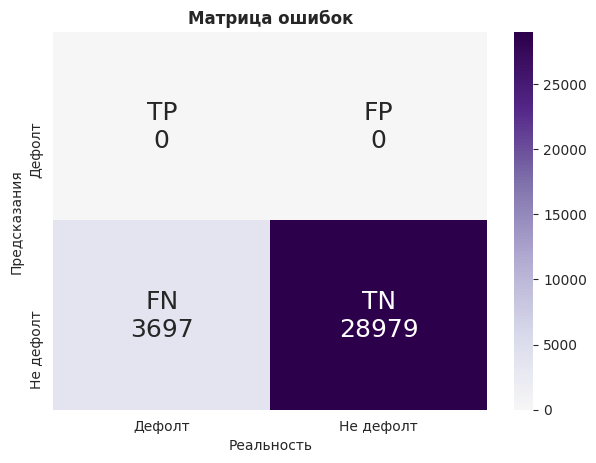

In [ ]:
mi_SVM_11.confusion_matrix_plot()

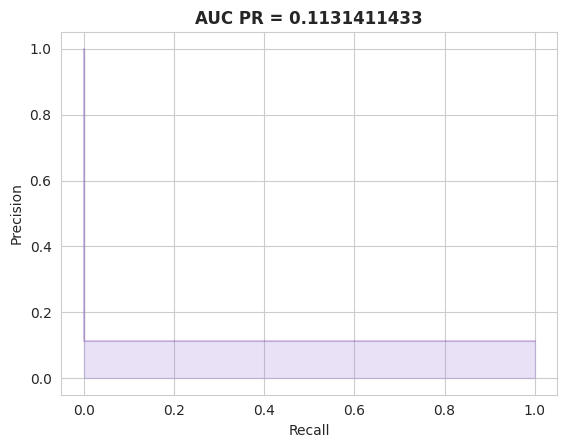

In [ ]:
mi_SVM_11.recall_precision_plot()

### Undersampling

In [ ]:
train_data = df_features_1.query('sample_cd == 1').drop(['sample_cd'], axis=1)
test_data = df_features_1.query('sample_cd == 0').drop(['sample_cd'], axis=1)

y_1 = train_data['default_flg']
X_1 = train_data.drop(['default_flg'], axis=1)

In [ ]:
rus = RandomUnderSampler(random_state=42)
X_us, y_us = rus.fit_resample(X_1, y_1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_us, y_us, test_size=0.10, shuffle = True, random_state=42)

In [ ]:
svm = SVC()
param_grid = {'C':[0.1,1,100], 'kernel':['linear', 'rbf'], 'gamma': [1, 0.1, 0.01]}
model_svm_us = GridSearchCV(SVC(),param_grid, n_jobs=-1)

In [ ]:
model_svm_us.fit(X_train,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.1, 1, 100], 'gamma': [1, 0.1, 0.01],
                         'kernel': ['linear', 'rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
model_svm_us.best_params_

{'C': 100, 'gamma': 1, 'kernel': 'rbf'}

In [ ]:
model_svm_us_1 = SVC(kernel='rbf', C=100, gamma=1)
model_svm_us_1.fit(X_train, y_train) # оценим параметры модели

y_pred_svm_us_1 = model_svm_us_1.predict(X_test)  # прогноз отношения к классу 0 или 1

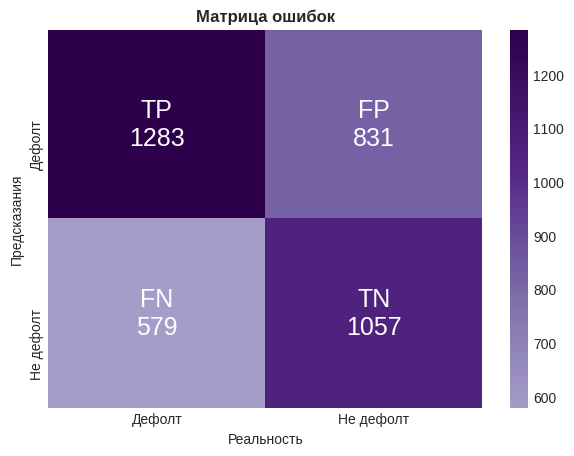

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_svm_us_1).ravel()
cf_matrix = np.array([[tp,fp],[fn,tn]])
group_names = ['TP','FP','FN','TN']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(7,5))
sns.heatmap(cf_matrix, center=0, annot=labels, annot_kws={"size": 18}, fmt='', cmap= 'binary', cbar = True, \
            xticklabels = ['Дефолт','Не дефолт'], yticklabels= ['Дефолт','Не дефолт'])
plt.title('Матрица ошибок', fontsize=12,  weight='bold')
plt.xlabel('Реальность', fontsize=10)
plt.ylabel('Предсказания', fontsize=10)
plt.show()

In [ ]:
result = pd.Series({
            'accuracy' : accuracy_score(y_test, y_pred_svm_us_1),
            'precision' : precision_score(y_test, y_pred_svm_us_1),
            'recall' : recall_score(y_test, y_pred_svm_us_1),
            'F1' : f1_score(y_test, y_pred_svm_us_1),
            })
result

accuracy     0.624000
precision    0.606906
recall       0.689044
F1           0.645372
dtype: float64

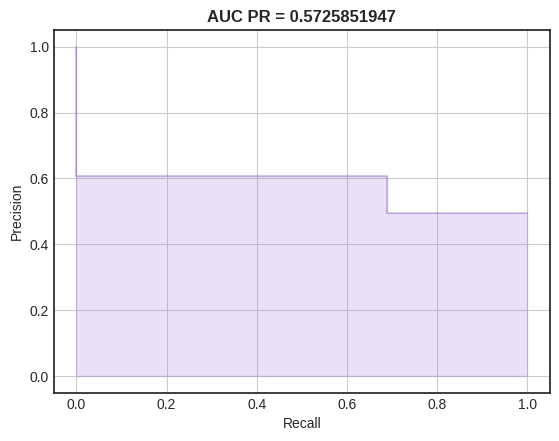

In [ ]:
precisions, recalls, _ = precision_recall_curve(y_test, y_pred_svm_us_1)
ap = average_precision_score(y_test, y_pred_svm_us_1)        
        
plt.figure()
        
plt.step(recalls, precisions, color='grey', alpha=0.2, where='post')
plt.fill_between(recalls, precisions, step='post', alpha=0.2, color='lightgray')
plt.xlabel('Recall', fontsize=10);
plt.ylabel('Precision', fontsize=10);
plt.title('AUC PR = %0.10f' % ap, fontsize=12,  weight='bold')
plt.grid(True)

plt.show()

## 5.2 SVM модель

In [ ]:
train_data = df_features_2.query('sample_cd == 1').drop(['sample_cd'], axis=1)
test_data = df_features_2.query('sample_cd == 0').drop(['sample_cd'], axis=1)

y_2 = train_data['default_flg']
X_2 = train_data.drop(['default_flg'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_2, y_2, test_size=0.2, random_state=42)

### Первая модель

In [ ]:
model_SVM_2 = SVC(kernel='rbf', C=100, gamma=1)
model_SVM_2.fit(X_train, y_train) # оценим параметры модели

y_pred_SVM_2 = model_SVM_2.predict(X_test)  # прогноз отношения к классу 0 или 1

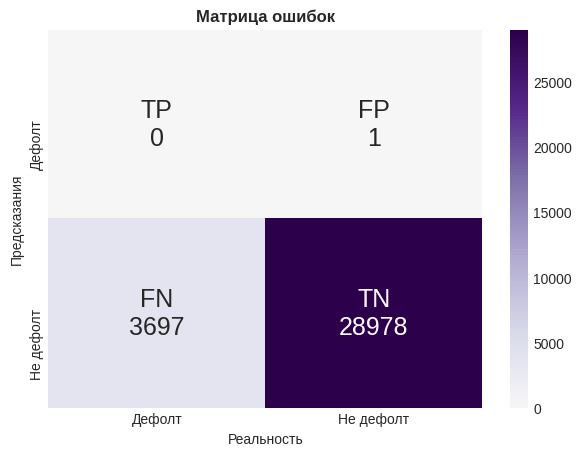

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_SVM_2).ravel()
cf_matrix = np.array([[tp,fp],[fn,tn]])
group_names = ['TP','FP','FN','TN']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(7,5))
sns.heatmap(cf_matrix, center=0, annot=labels, annot_kws={"size": 18}, fmt='', cmap= 'binary', cbar = True, \
            xticklabels = ['Дефолт','Не дефолт'], yticklabels= ['Дефолт','Не дефолт'])
plt.title('Матрица ошибок', fontsize=12,  weight='bold')
plt.xlabel('Реальность', fontsize=10)
plt.ylabel('Предсказания', fontsize=10)
plt.show()
#PuOr

In [ ]:
result = pd.Series({
            'accuracy' : accuracy_score(y_test, y_pred_SVM_2),
            'precision' : precision_score(y_test, y_pred_SVM_2),
            'recall' : recall_score(y_test, y_pred_SVM_2),
            'F1' : f1_score(y_test, y_pred_SVM_2),
            })
result

accuracy     0.886828
precision    0.000000
recall       0.000000
F1           0.000000
dtype: float64

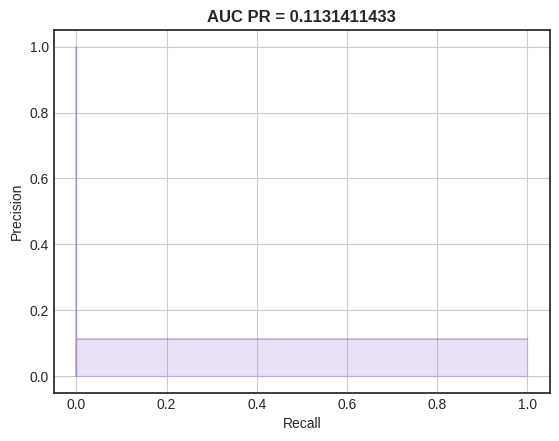

In [ ]:
precisions, recalls, _ = precision_recall_curve(y_test, y_pred_SVM_2)
ap = average_precision_score(y_test, y_pred_SVM_2)        
        
plt.figure()
        
plt.step(recalls, precisions, color='grey', alpha=0.2, where='post')
plt.fill_between(recalls, precisions, step='post', alpha=0.2, color='lightgray')
plt.xlabel('Recall', fontsize=10);
plt.ylabel('Precision', fontsize=10);
plt.title('AUC PR = %0.10f' % ap, fontsize=12,  weight='bold')
plt.grid(True)

plt.show()

In [ ]:
mi_SVM_2 = ModelInspect(model_SVM_2, X_test, y_test)

AttributeError: ignored

In [ ]:
mi_SVM_2.roc_curve_plot()

In [ ]:
mi_SVM_2.get_metrics()

In [ ]:
mi_SVM_2.confusion_matrix_plot()

In [ ]:
mi_SVM_2.recall_precision_plot()

### Подбор параметров №1

In [ ]:
svm = SVC()
param_grid = 'C':[0.1,1,100,1000], 'kernel':['rbf','poly','sigmoid','linear'], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}
grid = GridSearchCV(SVC(),param_grid)

In [ ]:
grid.fit(X_train,y_train)

KeyboardInterrupt: ignored

In [ ]:
grid.best_params_

### Вторая модель

In [ ]:
train_data = df_features_2.query('sample_cd == 1').drop(['sample_cd'], axis=1)
test_data = df_features_2.query('sample_cd == 0').drop(['sample_cd'], axis=1)

y_2 = train_data['default_flg']
X_2 = train_data.drop(['default_flg'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_2, y_2, test_size=0.2, random_state=42)

In [ ]:
model_SVM_21 = SVC(kernel='rbf', C=100, gamma=1, class_weight='balanced')
model_SVM_21.fit(X_train, y_train) # оценим параметры модели

y_pred_SVM_21 = model_SVM_21.predict(X_test)  # прогноз отношения к классу 0 или 1

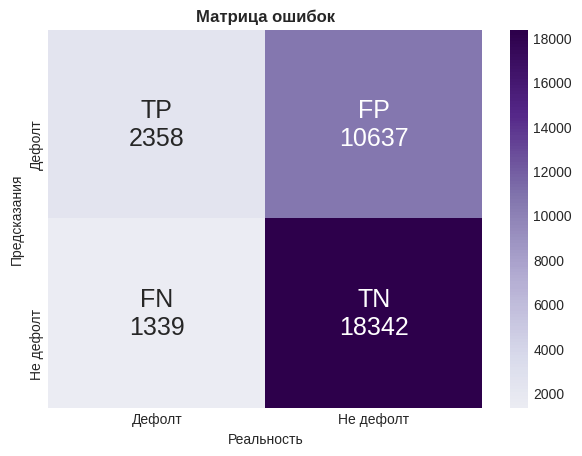

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_SVM_21).ravel()
cf_matrix = np.array([[tp,fp],[fn,tn]])
group_names = ['TP','FP','FN','TN']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(7,5))
sns.heatmap(cf_matrix, center=0, annot=labels, annot_kws={"size": 18}, fmt='', cmap= 'binary', cbar = True, \
            xticklabels = ['Дефолт','Не дефолт'], yticklabels= ['Дефолт','Не дефолт'])
plt.title('Матрица ошибок', fontsize=12,  weight='bold')
plt.xlabel('Реальность', fontsize=10)
plt.ylabel('Предсказания', fontsize=10)
plt.show()

In [ ]:
result = pd.Series({
            'accuracy' : accuracy_score(y_test, y_pred_SVM_21),
            'precision' : precision_score(y_test, y_pred_SVM_21),
            'recall' : recall_score(y_test, y_pred_SVM_21),
            'F1' : f1_score(y_test, y_pred_SVM_21),
            })
result

accuracy     0.633492
precision    0.181454
recall       0.637814
F1           0.282531
dtype: float64

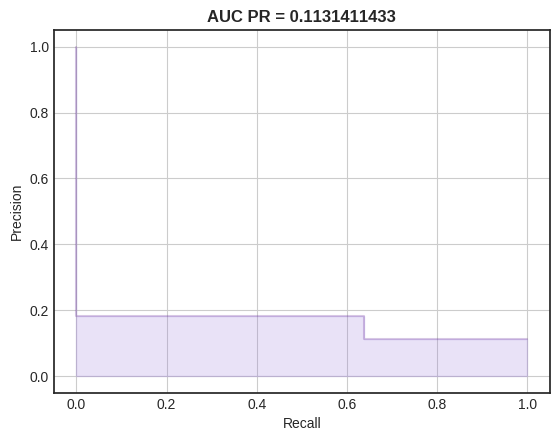

In [ ]:
precisions, recalls, _ = precision_recall_curve(y_test, y_pred_SVM_21)
ap = average_precision_score(y_test, y_pred_SVM_21)        
        
plt.figure()
        
plt.step(recalls, precisions, color='grey', alpha=0.2, where='post')
plt.fill_between(recalls, precisions, step='post', alpha=0.2, color='lightgray')
plt.xlabel('Recall', fontsize=10);
plt.ylabel('Precision', fontsize=10);
plt.title('AUC PR = %0.10f' % ap, fontsize=12,  weight='bold')
plt.grid(True)

plt.show()

In [ ]:
mi_SVM_21 = ModelInspect(model_SVM_21, X_test, y_test)

In [ ]:
mi_SVM_21.roc_curve_plot()

In [ ]:
metrics = pd.concat([mi_SVM_2.get_metrics(), mi_SVM_21.get_metrics()],axis = 1)
metrics.columns = ['best params 2', 'best params 21']
metrics

In [ ]:
mi_SVM_21.confusion_matrix_plot()

In [ ]:
mi_SVM_21.recall_precision_plot()

### Undersampling

In [ ]:
train_data = df_features_2.query('sample_cd == 1').drop(['sample_cd'], axis=1)
test_data = df_features_2.query('sample_cd == 0').drop(['sample_cd'], axis=1)

y_2 = train_data['default_flg']
X_2 = train_data.drop(['default_flg'], axis=1)

In [ ]:
rus = RandomUnderSampler(random_state=42)
X_us, y_us = rus.fit_resample(X_2, y_2)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_us, y_us, test_size=0.10, shuffle = True, random_state=42)

In [ ]:
model_svm_us_2 = SVC(kernel='rbf', C=100, gamma=1)
model_svm_us_2.fit(X_train, y_train) # оценим параметры модели

y_pred_svm_us_2 = model_svm_us_2.predict(X_test)  # прогноз отношения к классу 0 или 1

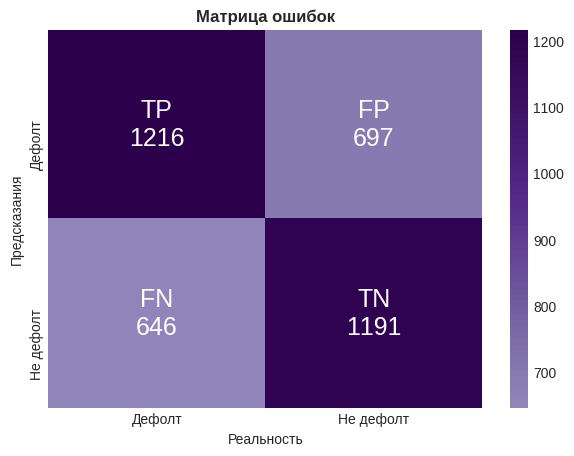

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_svm_us_2).ravel()
cf_matrix = np.array([[tp,fp],[fn,tn]])
group_names = ['TP','FP','FN','TN']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(7,5))
sns.heatmap(cf_matrix, center=0, annot=labels, annot_kws={"size": 18}, fmt='', cmap= 'binary', cbar = True, \
            xticklabels = ['Дефолт','Не дефолт'], yticklabels= ['Дефолт','Не дефолт'])
plt.title('Матрица ошибок', fontsize=12,  weight='bold')
plt.xlabel('Реальность', fontsize=10)
plt.ylabel('Предсказания', fontsize=10)
plt.show()

In [ ]:
result = pd.Series({
            'accuracy' : accuracy_score(y_test, y_pred_svm_us_2),
            'precision' : precision_score(y_test, y_pred_svm_us_2),
            'recall' : recall_score(y_test, y_pred_svm_us_2),
            'F1' : f1_score(y_test, y_pred_svm_us_2),
            })
result

accuracy     0.641867
precision    0.635651
recall       0.653061
F1           0.644238
dtype: float64

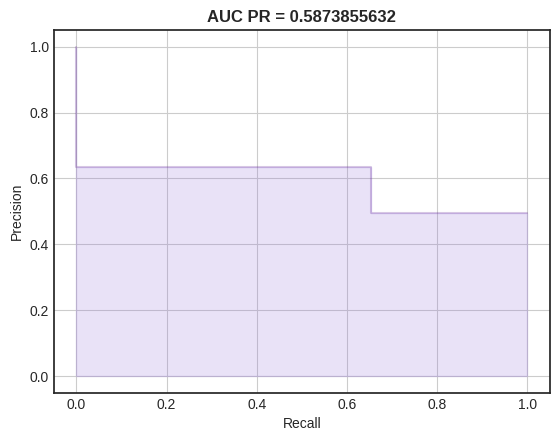

In [ ]:
precisions, recalls, _ = precision_recall_curve(y_test, y_pred_svm_us_2)
ap = average_precision_score(y_test, y_pred_svm_us_2)        
        
plt.figure()
        
plt.step(recalls, precisions, color='grey', alpha=0.2, where='post')
plt.fill_between(recalls, precisions, step='post', alpha=0.2, color='lightgray')
plt.xlabel('Recall', fontsize=10);
plt.ylabel('Precision', fontsize=10);
plt.title('AUC PR = %0.10f' % ap, fontsize=12,  weight='bold')
plt.grid(True)

plt.show()